# Analysis of Olink proteomics data from a cohort of 116 melanoma patients (discovery) and a second cohort of 58 patients (validation)

In [1]:
# load packages
library(dplyr)
library(ggplot2)
library(gplots)
library(ggrepel)
library(RColorBrewer)
library(heatmap3)
library(data.table)
library(tidyverse)
library(R.utils) # has gzip command
library(readxl)
library(writexl)
library(magrittr)
library(qwraps2)
library(ggfortify)
library(pROC)
library(Seurat)
library(umap)
library(GSVA)
library(ggpubr)
library(survival)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'gplots'


The following object is masked from 'package:stats':

    lowess



Attaching package: 'data.table'


The following objects are masked from 'package:dplyr':

    between, first, last


-- Attaching packages ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- tidyverse 1.3.0 --

v tibble  3.1.5     v purrr   0.3.4
v tidyr   1.1.4     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [2]:
# set working directory
folder <- "/seq/hacohenlab1/arnav/olink_melanoma/paper1/"
setwd(folder)

In [3]:
# load discovery dataset
load('./R data object_validation cohort/Filtered_annotated_data_frame-LongFormat.Rda')
# exclude patients getting other therapies, specifically WDVAX, GLUi, mRNA-4157, gluti, 
# cavatak, IMCgp100, TVEC only, or CMP001 only
patients_to_exclude <- c(311, 655, 712, 764, 848, 909, 913, 406, 689)
## Now filter out the samples to exclude.
discovery <- annotated.npx.df %>% filter(!(patient %in% patients_to_exclude))
# create a “grouped-response” field to combine the two “SD” patients into the “R” outcome group
discovery <- discovery %>% mutate(grouped_response = ifelse(response_simple=="SD", "R", response_simple))
str(discovery)

tibble [224,769 x 26] (S3: tbl_df/tbl/data.frame)
 $ SampleId        : chr [1:224769] "OL_B1_95" "OL_B1_137" "OL_B1_179" "OL_B1_12" ...
 $ Index           : int [1:224769] 1 2 3 4 5 6 8 9 10 11 ...
 $ Assay           : chr [1:224769] "OID01272" "OID01272" "OID01272" "OID01272" ...
 $ UniProt         : chr [1:224769] "P42785" "P42785" "P42785" "P42785" ...
 $ Name            : chr [1:224769] "PRCP" "PRCP" "PRCP" "PRCP" ...
 $ MissingFreq     : chr [1:224769] "0.15775" "0.15775" "0.15775" "0.15775" ...
 $ Panel           : chr [1:224769] "Olink CARDIOMETABOLIC(v.3602)" "Olink CARDIOMETABOLIC(v.3602)" "Olink CARDIOMETABOLIC(v.3602)" "Olink CARDIOMETABOLIC(v.3602)" ...
 $ Plate_ID        : chr [1:224769] "20190062-001_SP190219_CAM" "20190062-001_SP190219_CAM" "20190062-001_SP190219_CAM" "20190062-001_SP190219_CAM" ...
 $ QC_Warning      : chr [1:224769] "Pass" "Pass" "Pass" "Pass" ...
 $ LOD             : num [1:224769] -0.921 -0.921 -0.921 -0.921 -0.921 ...
 $ NPX             : num [1:224

In [4]:
# load validation dataset
load('./R data object_initial cohort/Filtered_annotated_data_frame_pilot-LongFormat.Rda')
# rename data frame
validation <- npx.df
str(validation)

tibble [151,466 x 25] (S3: tbl_df/tbl/data.frame)
 $ SampleId   : chr [1:151466] "307_pre_neg_64" "422_pre_neg_3" "485_pre_neg_10" "515_pre_0" ...
 $ Assay      : chr [1:151466] "OID01272" "OID01272" "OID01272" "OID01272" ...
 $ UniProt    : chr [1:151466] "P42785" "P42785" "P42785" "P42785" ...
 $ Name       : chr [1:151466] "PRCP" "PRCP" "PRCP" "PRCP" ...
 $ MissingFreq: chr [1:151466] "0.01307" "0.01307" "0.01307" "0.01307" ...
 $ Panel      : chr [1:151466] "Olink CARDIOMETABOLIC(v.3601)" "Olink CARDIOMETABOLIC(v.3601)" "Olink CARDIOMETABOLIC(v.3601)" "Olink CARDIOMETABOLIC(v.3601)" ...
 $ Plate ID   : chr [1:151466] "20180161-041_SP180102_CAM.csv" "20180161-041_SP180102_CAM.csv" "20180161-041_SP180102_CAM.csv" "20180161-041_SP180102_CAM.csv" ...
 $ QC Warning : chr [1:151466] "Pass" "Pass" "Pass" "Pass" ...
 $ LOD        : num [1:151466] 0.0866 0.0866 0.0866 0.0866 0.0866 ...
 $ NPX        : num [1:151466] 0.693 1.565 1.045 0.721 1.055 ...
 $ ID         : chr [1:151466] "307" "422

In [5]:
# load results of linear mixed effect models
# get genes from LME
lme.all <- read.csv("./LME_all_results.csv")
lme.sig <- filter(lme.all, Threshold == "Significant")

lme.timepoint <- filter(lme.sig, term=="Timepoint")
lme.response <- filter(lme.sig, term=="grouped_response")
lme.interaction <- filter(lme.sig, term=="Timepoint:grouped_response")

In [46]:
# upload metadata for all patients
upload.metadata <- "./051820_annotations-Table1"
discovery.metadata <- discovery %>% select(patient, age:censure_os)
discovery.metadata <- discovery.metadata[!duplicated(discovery.metadata$patient),]
discovery.metadata <- discovery.metadata %>% mutate(grouped_response = ifelse(response_simple=="SD", "R", response_simple))
clinical <- read_excel(paste0(upload.metadata,"/18may2020_olink_clinicaldata.xlsx"),sheet=2)
clinical <- clinical %>% filter(patient %in% discovery.metadata$patient) %>% select(patient, primary_site, ECOG_start, M1, brain_mets)
labs <- read_excel(paste0(upload.metadata,"/validation_cohort_Olink_FINAL_deidentified_covariateEW-052920.xlsx"),sheet=1)
discovery.metadata <- merge(discovery.metadata, labs, by="patient")
discovery.metadata <- merge(discovery.metadata, clinical, by="patient")
discovery.metadata <- discovery.metadata %>% mutate(AMC = as.numeric(AMC), LDH = as.numeric(LDH)) %>% filter(grouped_response %in% c("R","NR"))

str(discovery.metadata)

discovery.R <- filter(discovery.metadata, grouped_response=="R")
discovery.NR <- filter(discovery.metadata, grouped_response=="NR")

Warning message in mask$eval_all_mutate(quo):
"NAs introduced by coercion"
Warning message in mask$eval_all_mutate(quo):
"NAs introduced by coercion"


'data.frame':	116 obs. of  26 variables:
 $ patient         : num  26 35 38 40 61 69 78 99 107 136 ...
 $ age             : num  57 67 25 37 65.9 ...
 $ sex             : chr  "F" "F" "M" "F" ...
 $ treatment       : chr  "pembro (prior d+t)" "pembro (prior IPI, d+t, LGX+MEK)" "pembro (prior d+t, IPI, vem+IL2, IFN)" "pembro (prior d+t, vem+IL2, IFN)" ...
 $ response_simple : chr  "NR" "R" "R" "SD" ...
 $ pfs             : chr  "82" "210" "1558" "1409" ...
 $ censure_pfs     : chr  "0" "0" "1" "1" ...
 $ os              : chr  "764" "1138" "1604" "1482" ...
 $ censure_os      : chr  "1" "1" "1" "1" ...
 $ grouped_response: chr  "NR" "R" "R" "R" ...
 $ LDH             : num  163 291 46 133 251 205 NA 192 223 210 ...
 $ PDL1            : chr  "UN" "UN" "UN" "UN" ...
 $ t-cell-inf      : chr  "UN" "scattered CD8<U+00A0>positive cells throughout" "intratumoral and peritumoral lymphocytes" "Absent" ...
 $ ECOG PS         : chr  "0" "0" "1" "0" ...
 $ WBC             : num  7.53 6.83 7.1 3.17

## Converting to wide format

In [47]:
# convert data to wide format
discovery.wide = discovery %>%
  dplyr::select(patient, Timepoint, Assay, Name, NPX) %>%
  dcast(patient + Timepoint ~ Assay, value.var="NPX", fun.aggregate=mean)
discovery.wide <- merge(discovery.wide, discovery.metadata, by.x="patient", by.y="patient", all.x=T)
discovery.wide <- discovery.wide %>% mutate(label.full=paste0(patient,"_",Timepoint))

Warning message in dcast(., patient + Timepoint ~ Assay, value.var = "NPX", fun.aggregate = mean):
"The dcast generic in data.table has been passed a tbl_df and will attempt to redirect to the reshape2::dcast; please note that reshape2 is deprecated, and this redirection is now deprecated as well. Please do this redirection yourself like reshape2::dcast(.). In the next version, this warning will become an error."


In [48]:
discovery.wide

patient Timepoint OID00131 OID00132 OID00287 OID00288 OID00290 OID00291
1    26     6-week    3.22029  5.44092  7.54318  4.91610  3.20473  1.30714 
2    26     Baseline  2.66869  5.70237  6.78502  4.86993  2.99687  1.33206 
3    35     6-month   3.23515  4.82066  4.72067  5.69936  4.04869  1.52167 
4    35     6-week    4.63968  5.13340  4.96495  5.20163  3.73605  1.80675 
5    35     Baseline  4.24640  4.53330  6.40396  4.74316  2.44674  0.93733 
6    38     6-week    2.55989  6.01934  6.51358  4.29218  2.95982  1.58910 
7    38     6-month   2.33108  5.62541  4.64713  4.14764  2.40073  1.27391 
8    40     6-month   2.46682  5.71494  5.43454  4.59923  2.78330  1.32579 
9    40     6-week    2.94740  5.33872  5.85868  4.59461  3.08684  1.03730 
10   40     Baseline  2.42205  4.77048  5.21387  4.93482  3.09949  1.20002 
11   61     6-week    4.61158  5.99852  7.64819  5.14473  3.49259  1.78495 
12   61     Baseline  4.49094  5.80779  6.10137  5.05045  3.18582  1.79054 
13   61     6-month   5.97254  5.36905  5.76206  5.58119  3.95929  1.69514 
14   69     6-month   4.11497  6.10692  4.97063  4.83293  3.86344  1.64286 
15   69     Baseline  5.35488  5.88421  4.35353  5.12669  4.13082  1.76192 
16   69     6-week    4.28127  6.27824  5.21013  4.89469  3.67692  1.63066 
17   78     6-week    8.85947  6.33125  5.17317  5.28345  4.49958  1.83874 
18   99     6-week    4.22242  5.78771  6.49313  5.31853  2.96470  2.23127 
19   99     Baseline  4.42181  6.09379  6.95532  5.75178  3.06074  2.04553 
20   99     6-month   7.43192  6.45312  6.52794  5.48215  4.16285  2.59270 
21  107     Baseline  3.84492  5.09302  7.49129  5.70125  2.56823  2.40319 
22  107     6-week    4.01196  5.15069  7.68491  5.47331  2.58946  2.03275 
23  107     6-month   5.09980  5.40416  7.31657  5.66490  3.26116  2.60902 
24  136     6-month   3.01598  5.16465  5.40822  4.37138  2.50032  1.34056 
25  136     Baseline  2.56855  5.18622  5.70109  4.38060  2.68891  1.25959 
26  137     6-month   4.06281  5.48397  5.20416  5.05447  3.47998  2.02437 
27  137     Baseline  2.94322  5.77475  7.98409  5.23322  3.44575  2.07028 
28  137     6-week    3.20036  5.56267  5.43223  4.92613  3.10945  1.67342 
29  143     6-month   4.57451  5.90761  6.88486  5.22464  3.58116  2.45680 
30  143     6-week    3.53677  6.01052  5.63743  4.68011  2.74637  1.30590 
... ...     ...       ...      ...      ...      ...      ...      ...     
292 801     6-month   2.18709  5.54832  4.92373  4.61634  3.06238  1.55220 
293 801     Baseline  3.22570  5.35592  6.73157  5.06480  3.00563  1.25643 
294 822     Baseline  4.84654  6.44487  5.00797  4.58898  3.55298  1.22919 
295 822     6-month   3.06342  6.00959  4.17351  4.80427  3.43604  1.46026 
296 822     6-week    4.52960  6.08550  5.59686  4.54069  3.22418  1.33573 
297 826     Baseline  6.17929  6.02529  5.21505  4.52117  3.75422  1.73199 
298 826     6-week    6.65110  6.53595  4.93012  4.64550  4.41244  1.70934 
299 826     6-month   6.82728  6.23116  4.29945  4.92240  4.04248  1.48599 
300 828     6-month   4.80734  6.04127  4.05723  4.73179  3.10760  1.58531 
301 828     6-week    5.35337  5.72626  4.86704  4.49456  3.00598  1.67448 
302 828     Baseline  5.43443  5.41731  5.71578  4.62094  2.75307  1.47660 
303 838     6-week    6.68915  4.89917  5.76502  6.14547  3.53156  2.41574 
304 838     Baseline  6.56751  4.94421  4.03661  5.19545  3.06000  2.09089 
305 856     6-month   3.55487  5.22890  3.99950  6.88455  2.39238  1.41214 
306 856     6-week    2.31159  5.20671  8.02059  6.19680  2.41931  1.55929 
307 856     Baseline  2.73058  4.74796  5.36453  6.58201  1.74049  1.12307 
308 869     6-month   3.96315  6.15565  4.61200  5.01670  2.87155  2.74921 
309 869     6-week    3.19042  6.77769  4.50234  4.83326  2.99026  2.61426 
310 869     Baseline  3.65915  6.00359  6.09881  5.09949  2.91781  2.53708 
311 870     6-month   6.24945  4.98486  6.03145  5.75829  2.67855  1.44952 
312 870     6-week    6.52035  5.26038  7.97572  5.2

In [49]:
dim(discovery.wide)

[1] 321 735

In [50]:
# convert data to wide format
validation.wide = validation %>%
  dplyr::select(ID, OnTr.3, Assay, Name, NPX) %>%
  dcast(ID + OnTr.3 ~ Assay, value.var="NPX", fun.aggregate=mean)
validation.wide <- validation.wide %>% mutate(label.full=paste0(ID,"_",OnTr.3))

Warning message in dcast(., ID + OnTr.3 ~ Assay, value.var = "NPX", fun.aggregate = mean):
"The dcast generic in data.table has been passed a tbl_df and will attempt to redirect to the reshape2::dcast; please note that reshape2 is deprecated, and this redirection is now deprecated as well. Please do this redirection yourself like reshape2::dcast(.). In the next version, this warning will become an error."


In [51]:
validation.wide

ID  OnTr.3 OID00287  OID00288 OID00290    OID00291  OID00292 OID00293
1   102 pre     3.807080 1.604810  0.77471000 0.5959028 1.506150 3.604590
2   102 6w      4.965680 1.450960  0.40713000 1.1370300 1.446210 3.567730
3   115 pre     5.609360 1.915830 -0.68180000 1.2105700 0.525910 2.487540
4   115 NA      4.846705 1.540325  0.16398000 1.0325621 1.232285 3.033540
5   122 pre     5.012370 1.474930  0.35245000 0.9591030 1.882930 3.346050
6   122 NA      5.588477 1.322873  0.41248000 0.9420500 1.749903 3.265120
7   131 NA      5.884505 1.607150  1.23521500 1.1740400 2.467845 4.574135
8   142 NA      2.452910 1.526505  0.41252500 1.3874650 2.113685 3.715350
9   144 NA      1.532800 1.273890  0.65451000 0.9422043 1.783640 2.858110
10  156 NA      5.388150 2.171530  1.46846000 1.5073600 2.172230 4.527500
11  166 NA      5.594165 1.483270  0.74747000 1.4486550 1.939370 3.699835
12  178 pre     3.593130 1.280960  1.69203000 0.6980232 2.514470 4.065640
13  178 NA      5.189715 1.534825  1.45790000 0.6584948 2.234375 4.285125
14  196 NA      4.397180 1.475617  0.23261667 1.3427710 1.928160 3.775137
15  208 pre     5.571310 1.742690  1.41621000 1.0877241 2.328130 5.251370
16  212 pre     4.693770 1.874820  1.34298000 0.9515442 2.195720 3.877450
17  212 6w      4.759030 1.327040  1.36017000 1.1050047 2.169660 3.768430
18  212 NA      7.829030 1.461160  0.87953000 0.9036945 1.919230 3.490870
19  214 NA      6.206050 1.527053 -0.06149667 1.5210733 1.745347 3.135387
20  239 NA      3.237740 1.177120 -0.03785500 0.5443095 0.920070 2.766840
21  276 pre    10.406730 2.228590  1.20096000 0.8502344 1.997470 3.963280
22  276 NA      8.267390 1.753660  1.64221000 1.3037400 2.260720 3.813410
23  307 pre          NaN      NaN         NaN       NaN      NaN      NaN
24  307 NA      4.891360 1.344560  1.03216000 1.3424100 1.675650 3.055990
25  389 pre     4.160300 2.044600  1.06633000 1.2656200 2.457200 3.920220
26  389 NA      4.350970 1.871420  0.49986000 0.8164252 2.255280 3.578760
27  400 pre     2.298790 2.330790  1.26237000 0.8424233 2.280300 4.334040
28  400 NA      3.625000 1.847080  1.25721000 1.4359000 2.284450 4.194330
29  401 pre          NaN      NaN         NaN       NaN      NaN      NaN
30  401 NA      5.044400 1.301370 -0.28582000 1.1828600 1.127490 2.720710
... ... ...    ...       ...      ...         ...       ...      ...     
90  596 6w     4.438500  1.542640 -0.1871400  0.9486931 1.906640 1.396470
91  596 NA     5.647070  2.015280  0.4220700  1.4955600 2.141880 4.001750
92  601 pre    4.207910  1.387650 -0.3003100  1.0112542 1.379350 3.168790
93  601 6w     3.774500  1.286180 -0.4783100  0.1980742 1.516690 2.750920
94  603 pre    3.558180  1.356480 -0.1304800  0.5992850 1.362130 2.845130
95  603 6w     3.069220  1.646670 -0.5483800  0.7852448 2.133120 1.995240
96  603 NA     6.910730  1.347460 -0.1673700  0.8955735 1.485410 2.672260
97  628 pre    4.463420  1.077230  0.5675300  0.5291747 1.800490 3.687090
98  628 6w     2.713420  0.929710  1.0628800  1.1164740 2.392240 3.862700
99  628 NA     3.097940  1.359740  0.5894600  1.1775900 2.077460 3.422750
100 642 pre    2.510490  1.455050 -0.3935000  0.8293446 1.180770 3.159940
101 642 NA     4.342360  1.728325 -0.1882550  1.0578868 1.358145 3.349540
102 654 pre    6.581150  2.016690  0.8202300  0.7218941 1.817320 3.190780
103 654 6w     6.205820  1.865700  0.8826700  1.2058800 2.055270 3.513840
104 654 NA     3.133360  1.388330  0.6525300  1.2916500 1.583370 2.762230
105 662 pre    2.810290  1.285480  0.1419300  0.7078031 1.479250 3.248450
106 662 NA     3.384780  2.714255 -0.2258700  0.7992643 1.145075 2.513190
107 98  NA     4.703205  1.689923  0.6012800  0.9986295 2.179385 3.433933
108 A   pre    4.191130  3.077070  0.2896200  1.4718700 2.110200 3.012770
109 A   6w     3.556420  0.236160 -0.3520900  0.8448232 1.294040 2.204410
110 A   NA     3.989540  1.224550 -0.0116700  0.9852146 1.826050 2.713360
111 BI1 pre    3.198700  1.481390 -0.3048300  1.1246000 1.676960 3.392670
112 BI1 

In [53]:
dim(validation.wide)

[1]  119 1043

## Clustering data 

### PCA and UMAP plot on entire dataset

In [137]:
discovery.plot <- discovery.wide %>% drop_na(OID00131:OID05548)
discovery.plot.filtered <- discovery.plot %>% select(union(lme.interaction$OlinkID, lme.response$OlinkID))
mplot <- as.matrix(discovery.plot.filtered[,1:284])
rownames(mplot) <- discovery.plot$label.full

In [138]:
dim(mplot)

[1] 304 284

In [139]:
# PCA and loadings
pca.calc <- prcomp(mplot, scale=TRUE)
plot(pca.calc)
pca.loadings <- pca.calc$x

cairo_pdf 
        2

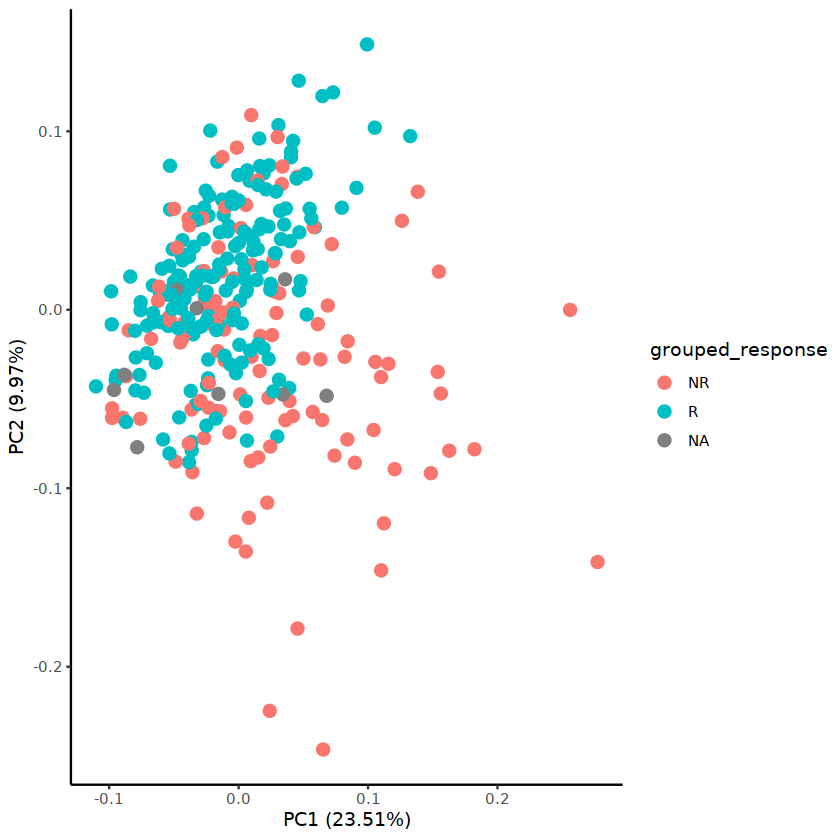

In [140]:
#plot PCA results
color.code = "grouped_response"
pca.plot <- autoplot(pca.calc, data=discovery.plot, colour=color.code, size=3) +
    theme_classic()
pca.plot

pdf("/seq/hacohenlab1/arnav/olink_melanoma/paper1/PCA-plot_response.pdf")
pca.plot
dev.off()

cairo_pdf 
        2

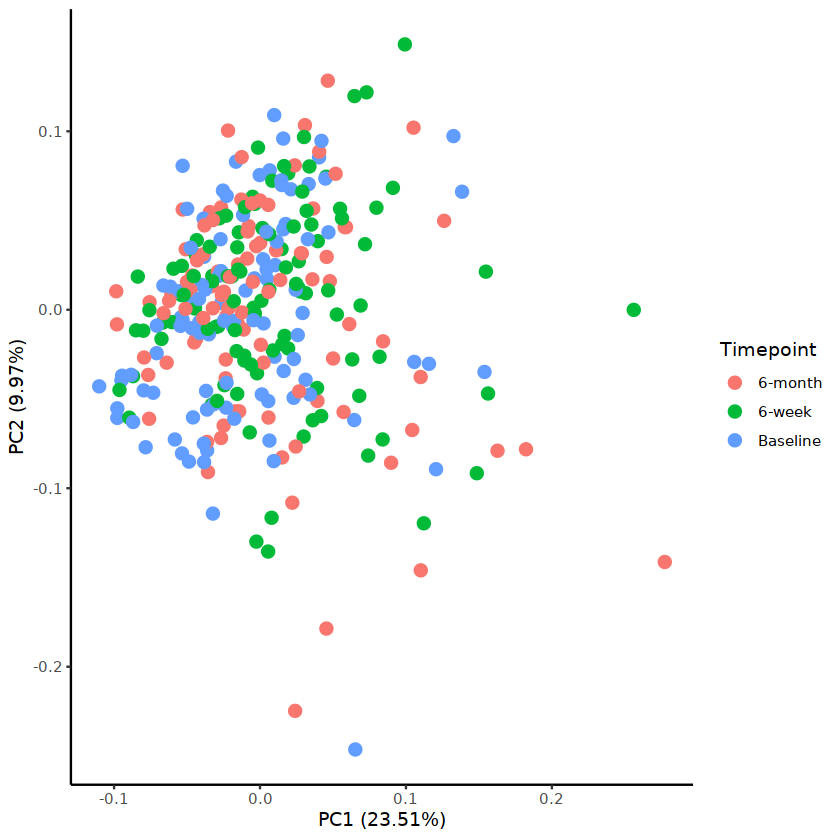

In [166]:
color.code = "Timepoint"
pca.plot <- autoplot(pca.calc, data=discovery.plot, colour=color.code, size=3) +
    theme_classic()
pca.plot

pdf("/seq/hacohenlab1/arnav/olink_melanoma/paper1/PCA-plot_timepoint.pdf")
pca.plot
dev.off()

cairo_pdf 
        2

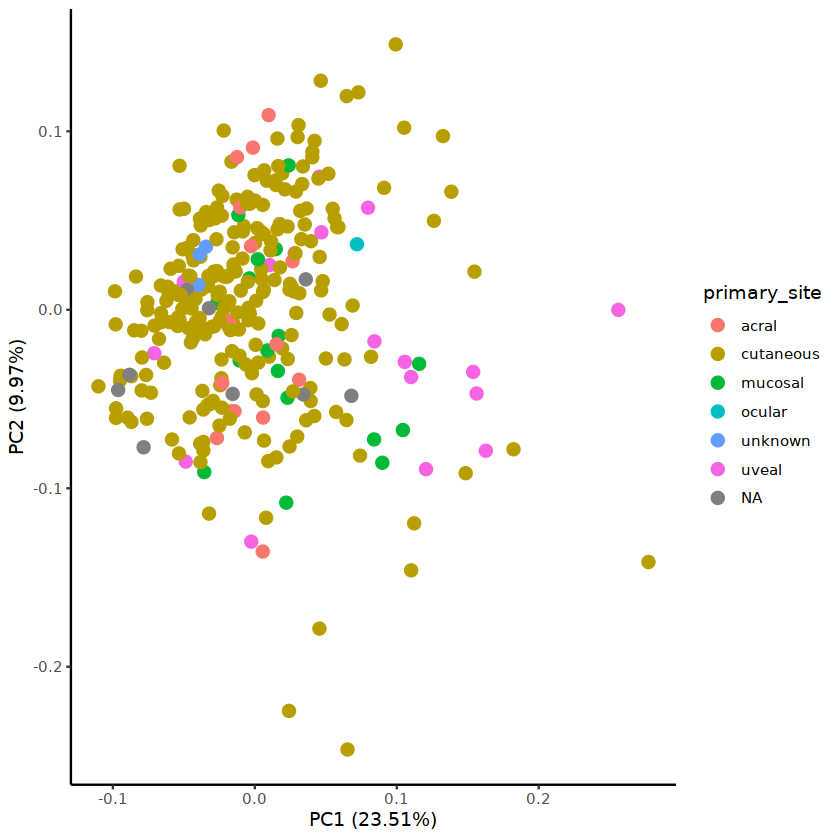

In [167]:
color.code = "primary_site"
pca.plot <- autoplot(pca.calc, data=discovery.plot, colour=color.code, size=3) +
    theme_classic()
pca.plot

pdf("/seq/hacohenlab1/arnav/olink_melanoma/paper1/PCA-plot_site.pdf")
pca.plot
dev.off()

In [169]:
color.code = "nr.module.es"
pca.plot <- autoplot(pca.calc, data=discovery.plot, colour=color.code, size=3) +
    theme_classic()
pca.plot

pdf("/seq/hacohenlab1/arnav/olink_melanoma/paper1/PCA-plot_NS-module.pdf")
pca.plot
dev.off()

cairo_pdf 
        2

Warning message in umap_plot(umap.calc, labels = discovery.plot$grouped_response, :
"there is NA values in the labels vector, setting to unknown"
Warning message in umap_plot(umap.calc, labels = discovery.plot$grouped_response, :
"there is NA values in the labels vector, setting to unknown"


cairo_pdf 
        2

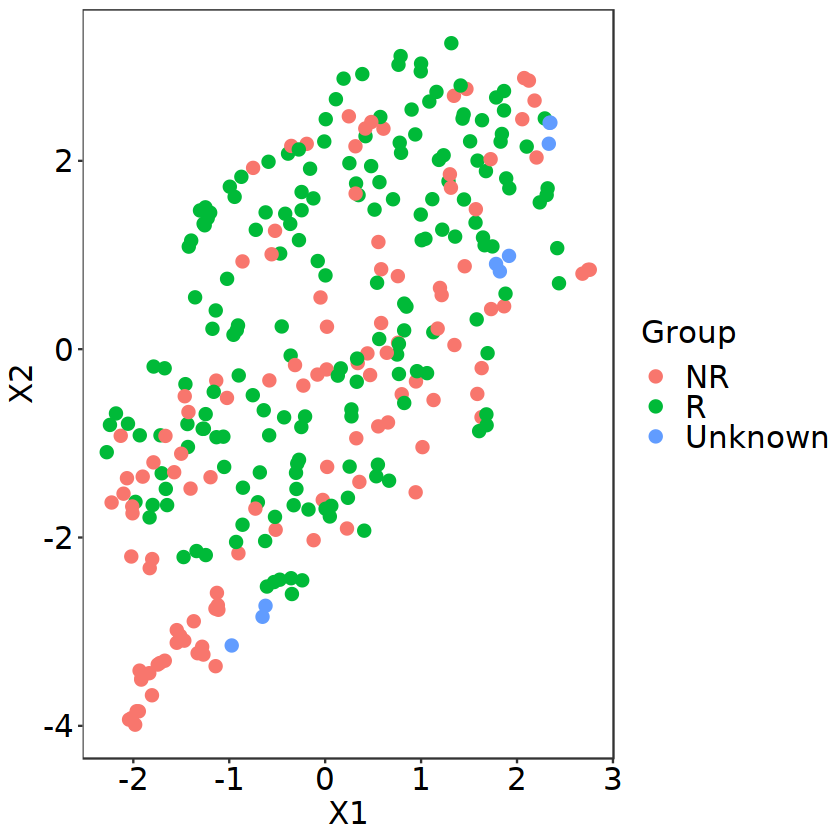

cairo_pdf 
        2

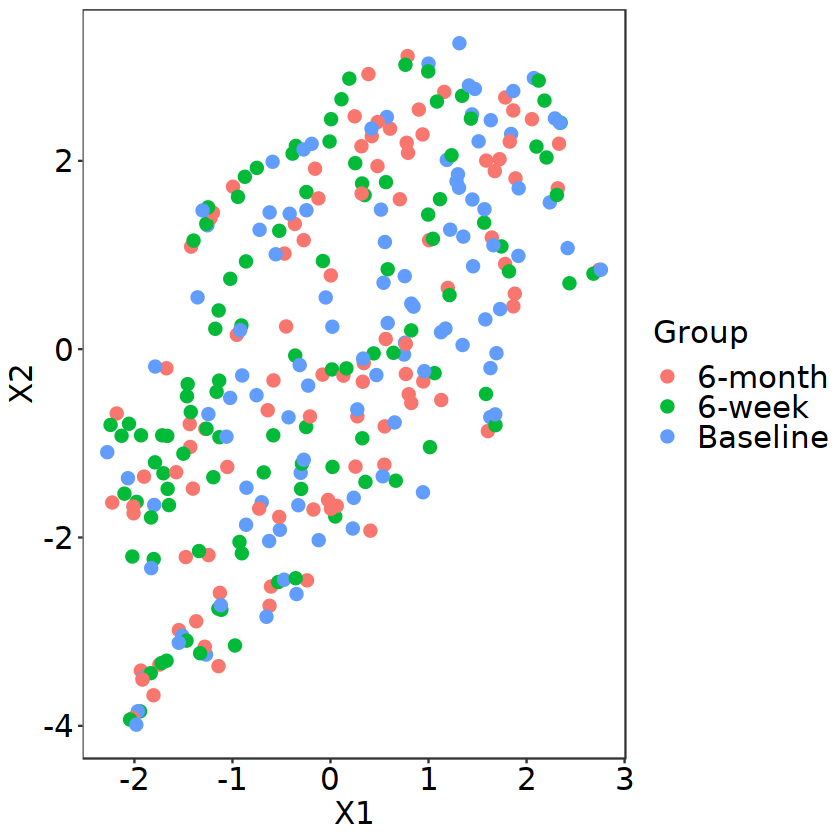

In [141]:
# UMAP calculation
umap.calc <- umap(mplot)

# custom UMAP plotting function in umap_plot.R
source("./umap_plot.R")

# by response
plot <- umap_plot(umap.calc, labels=discovery.plot$grouped_response, dotsize=3)
plot

pdf("./UMAP-all-samples-response.pdf")
plot <- umap_plot(umap.calc, labels=discovery.plot$grouped_response, dotsize=3)
plot
dev.off()

# by timepoint
plot <- umap_plot(umap.calc, labels=discovery.plot$Timepoint, dotsize=3)
plot

pdf("./UMAP-all-samples-timepoint.pdf")
plot <- umap_plot(umap.calc, labels=discovery.plot$Timepoint, dotsize=3)
plot
dev.off()

### PCA and UMAP plot at baseline only

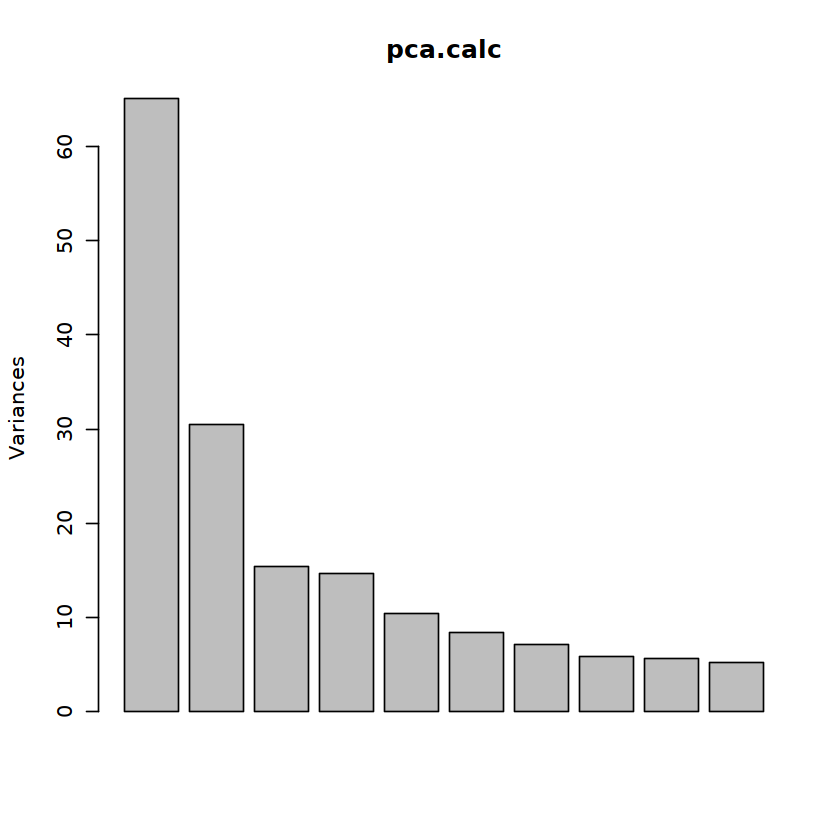

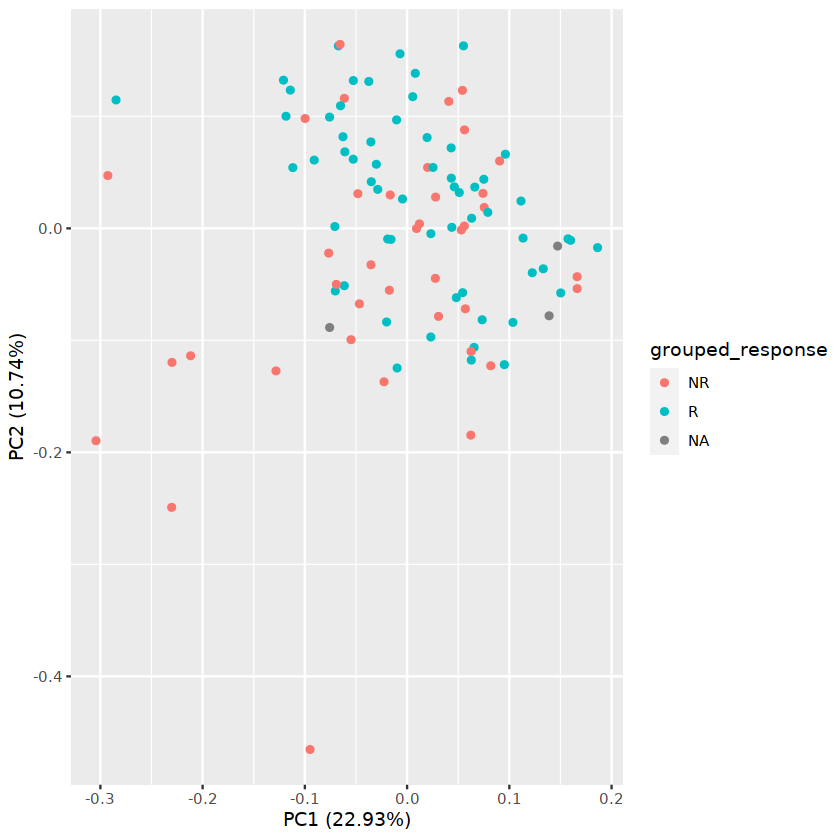

In [135]:
discovery.plot <- discovery.wide %>% filter(Timepoint=='Baseline') %>% drop_na(OID00131:OID05548) 
discovery.plot.filtered <- discovery.plot %>% select(union(lme.interaction$OlinkID, lme.response$OlinkID))
mplot <- as.matrix(discovery.plot.filtered[,1:284])
rownames(mplot) <- discovery.plot$label.full

# PCA and loadings
pca.calc <- prcomp(mplot, scale=TRUE)
plot(pca.calc)
pca.loadings <- pca.calc$x

#plot PCA results
color.code = "grouped_response"
pca.plot <- autoplot(pca.calc, data=discovery.plot, colour=color.code)
pca.plot

Warning message in umap_plot(umap.calc, labels = discovery.plot$grouped_response, :
"there is NA values in the labels vector, setting to unknown"
Warning message in umap_plot(umap.calc, labels = discovery.plot$grouped_response, :
"there is NA values in the labels vector, setting to unknown"


cairo_pdf 
        2

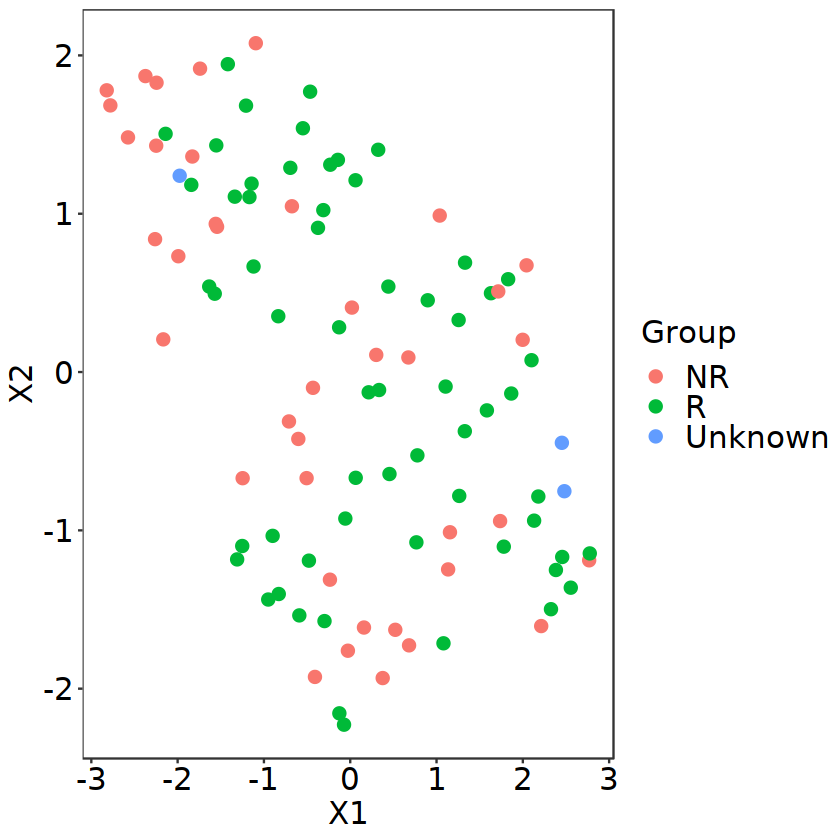

In [136]:
# UMAP calculation
umap.calc <- umap(mplot)

# custom UMAP plotting function in umap_plot.R
source("./umap_plot.R")

# by response
plot <- umap_plot(umap.calc, labels=discovery.plot$grouped_response, dotsize=3)
plot

pdf("./UMAP-baseline-response.pdf")
plot <- umap_plot(umap.calc, labels=discovery.plot$grouped_response, dotsize=3)
plot
dev.off()

### PCA and UMAP plot on 6-week only

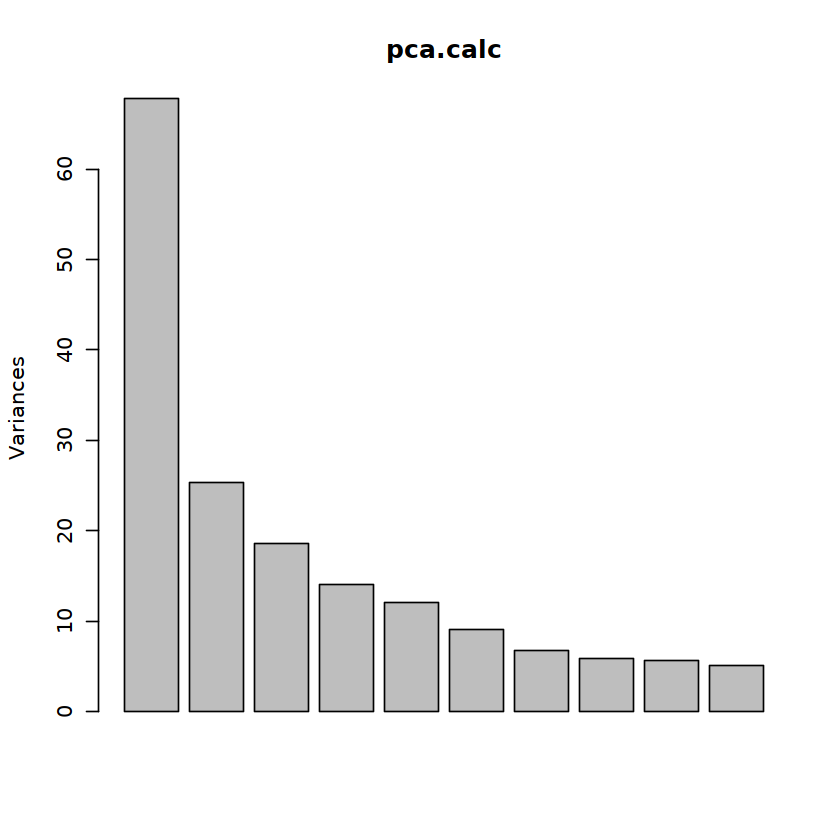

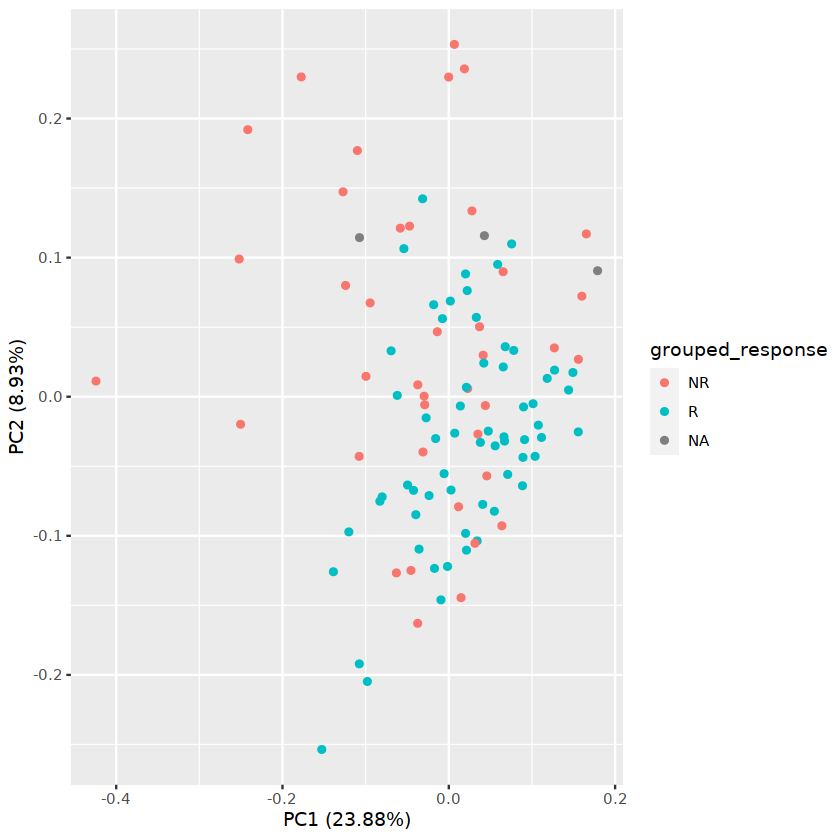

In [133]:
discovery.plot <- discovery.wide %>% filter(Timepoint=='6-week') %>% drop_na(OID00131:OID05548) 
discovery.plot.filtered <- discovery.plot %>% select(union(lme.interaction$OlinkID, lme.response$OlinkID))
mplot <- as.matrix(discovery.plot.filtered[,1:284])
rownames(mplot) <- discovery.plot$label.full

# PCA and loadings
pca.calc <- prcomp(mplot, scale=TRUE)
plot(pca.calc)
pca.loadings <- pca.calc$x

#plot PCA results
color.code = "grouped_response"
pca.plot <- autoplot(pca.calc, data=discovery.plot, colour=color.code)
pca.plot

Warning message in umap_plot(umap.calc, labels = discovery.plot$grouped_response, :
"there is NA values in the labels vector, setting to unknown"
Warning message in umap_plot(umap.calc, labels = discovery.plot$grouped_response, :
"there is NA values in the labels vector, setting to unknown"


cairo_pdf 
        2

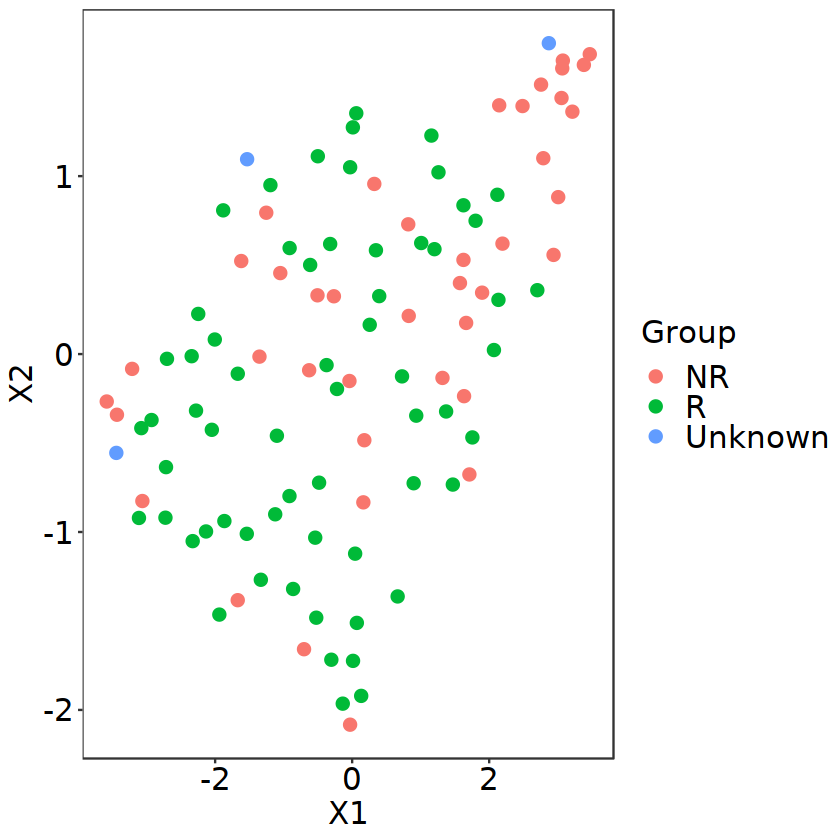

In [134]:
# UMAP calculation
umap.calc <- umap(mplot)

# custom UMAP plotting function in umap_plot.R
source("./umap_plot.R")

# by response
plot <- umap_plot(umap.calc, labels=discovery.plot$grouped_response, dotsize=3)
plot

pdf("./UMAP-6w-response.pdf")
plot <- umap_plot(umap.calc, labels=discovery.plot$grouped_response, dotsize=3)
plot
dev.off()

### PCA and UMAP plot on 6-months only

In [18]:
discovery.plot <- discovery.wide %>% filter(Timepoint=='6-month') %>% drop_na(OID00131:OID05548) 
discovery.plot.filtered <- discovery.plot %>% select(union(lme.interaction$OlinkID, lme.response$OlinkID))
mplot <- as.matrix(discovery.plot.filtered[,1:284])
rownames(mplot) <- discovery.plot$label.full

# PCA and loadings
pca.calc <- prcomp(mplot, scale=TRUE)
plot(pca.calc)
pca.loadings <- pca.calc$x

#plot PCA results
color.code = "grouped_response"
pca.plot <- autoplot(pca.calc, data=discovery.plot, colour=color.code)
pca.plot

Warning message in umap_plot(umap.calc, labels = discovery.plot$grouped_response, :
"there is NA values in the labels vector, setting to unknown"
Warning message in umap_plot(umap.calc, labels = discovery.plot$grouped_response, :
"there is NA values in the labels vector, setting to unknown"


cairo_pdf 
        2

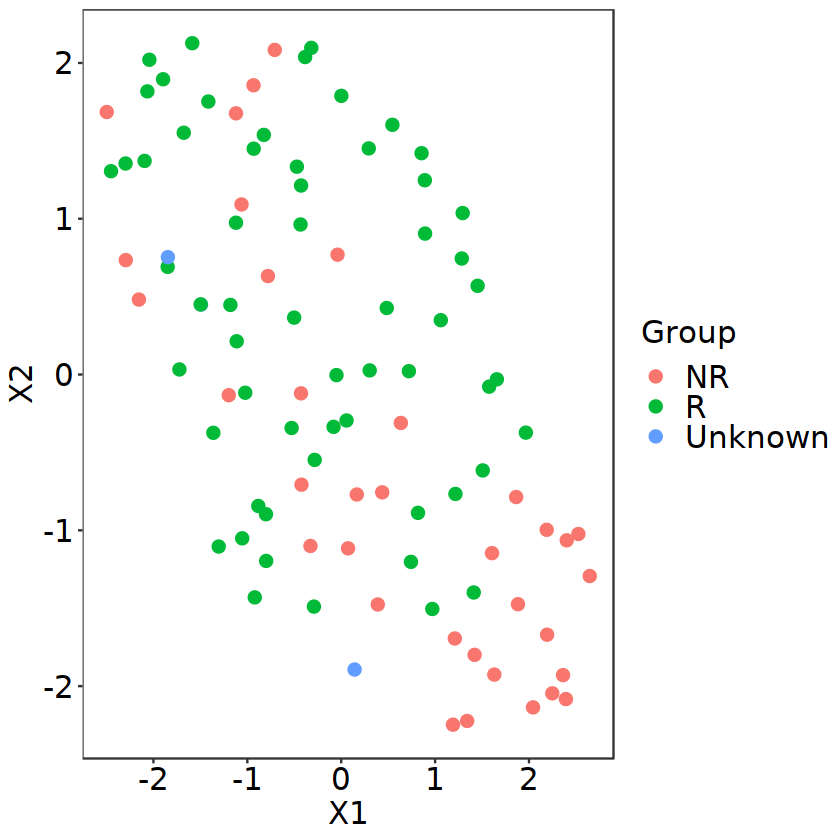

In [19]:
# UMAP calculation
umap.calc <- umap(mplot)

# custom UMAP plotting function in umap_plot.R
source("./umap_plot.R")

# by response
plot <- umap_plot(umap.calc, labels=discovery.plot$grouped_response, dotsize=3)
plot

pdf("./UMAP-6m-response.pdf")
plot <- umap_plot(umap.calc, labels=discovery.plot$grouped_response, dotsize=3)
plot
dev.off()

## Create heatmaps of cytokine plasma protein data

In [20]:
# create heatmaps of key cytokines changed over time and between responders and non-responders
cytokines <- c("CCL3", "CCL4", "CCL5", "CCL14", "CCL15", "CCL16", "CCL17", "CCL18", 
                 "CCL19", "CCL20", "CCL23", "CCL24", "CCL25", "CCL27", "CCL28", "CD40-L", "CSF-1",
                 "CX3CL1", "CXCL1", "CXCL5", "CXCL6", "CXCL9", "CXCL10", "CXCL11", "CXCL12", "CXCL13", "CXCL14",
                 "CXCL16", "Flt3L", "G-CSF", "IFN-gamma", "IL-1 alpha", "IL1B", "IL-2", "IL4",
                 "IL5", "IL6", "IL7", "IL8", "IL10", "IL12", "IL-12B", "IL13", "IL-17A",
                 "IL-17C", "IL-17D", "IL17F", "IL15", "IL16", "IL-20", "IL-24", "IL-27", "IL32", "IL-33",
                 "MCP-2", "MCP-3", "MCP-4", "TGF-alpha", "TNF", "TNFB", "XCL1")
cytokine.receptors <- c("FAS", "IFN-gamma-R1", "IL-1ra", "IL1RL2", "IL2-RA", "IL-2RB", "IL3RA", "IL-4RA", "IL-5R-alpha",  
                        "IL-6RA", "IL-10RA", "IL-10RB","IL13RA1", "IL-15RA", "IL-17RA", "IL-18BP", "IL-18R1", 
                        "IL-20RA", "IL-22 RA1", "LTBR", "ST2", "TNF-R1", "TNF-R2", "TNFRSF9", "TNFRSF10C", 
                        "TNFRSF12A", "TNFSF14", "TNFRSF14", "TNFRSF21")
t.cell.naive <- c("IL7R", "SELL", "CD28", "GZMA", "GZMH", "CD5", "CD27")
t.cell.dys <- c("GZMB", "LAG3", "PDCD1", "LAYN", "CD38", "CXCL13", "TNFRSF9", "TNFRSF4", "TNFRSF14", "TWEAK")
t.cell <- c("CD5", "CD8A", "IL7R", "SELL", "LAG3", "CD28", "PDCD1", "PD-L1", "CXCL13", "ICOSLG", "GZMA", 
                "GZMB", "GZMH", "CD38", "GNLY", "LAYN", "TNFRSF14", "TNFRSF9", "TNFRSF4", "CD27", "CD40-L")
myeloid <- c("CD33", "VCAN", "CLEC4C", "IL3RA")

In [21]:
# function to generate heatmaps
heatmap_cytokines_time <- function(data.v, cytokine.receptors, label, folder, factor, variable=NULL) {
  
  temp <- data.v %>% filter(Name %in% cytokine.receptors) %>% select(Name, NPX, Timepoint, patient, response_simple)
  temp$Name <- gsub("-","",temp$Name)
  temp <- temp[order(temp$Name),]
  data.cytokines <- dcast(temp, patient + Timepoint + response_simple ~ Name, value.var="NPX", fun.aggregate=mean)
  data.cytokines <- data.cytokines[order(data.cytokines$Timepoint),]
  index_cytokines <- 1:dim(data.cytokines)[1]
  data.cytokines <- cbind(index_cytokines, data.cytokines)

  # change column index in line below
  cytokines_NPX <- as.matrix(select(data.cytokines, 5:length(data.cytokines[1,])))
  rownames(cytokines_NPX) <- index_cytokines
  cytokines_NPX <- scale(cytokines_NPX, scale=TRUE, center=TRUE)
  cytokines_metaData <- select(data.cytokines, index_cytokines:response_simple)
  
  if (factor == "time") {
    cytokines_baseline.i <- filter(cytokines_metaData, Timepoint == "Baseline")
    cytokines_6w.i <- filter(cytokines_metaData, Timepoint == "6-week")
    cytokines_6m.i <- filter(cytokines_metaData, Timepoint == "6-month")
    
    heatmap.cytokines.baseline <- colMeans(cytokines_NPX[cytokines_baseline.i$index_cytokines,], na.rm = TRUE)
    heatmap.cytokines.6w <- colMeans(cytokines_NPX[cytokines_6w.i$index_cytokines,], na.rm = TRUE)
    heatmap.cytokines.6m <- colMeans(cytokines_NPX[cytokines_6m.i$index_cytokines,], na.rm = TRUE)
    cytokines.plot <- rbind(heatmap.cytokines.baseline, heatmap.cytokines.6w, heatmap.cytokines.6m)
    row.labels <- c("Baseline", "6 weeks", "6 months")
  }
  
  if (factor == "response") {
    cytokines_baseline.i.R <- cytokines_metaData %>% filter(Timepoint == "Baseline", response_simple=="R")
    cytokines_6w.i.R <- cytokines_metaData %>% filter(Timepoint == "6-week", response_simple=="R")
    cytokines_6m.i.R <- cytokines_metaData %>% filter(Timepoint == "6-month", response_simple=="R")
    cytokines_baseline.i.NR <- cytokines_metaData %>% filter(Timepoint == "Baseline", response_simple=="NR")
    cytokines_6w.i.NR <- cytokines_metaData %>% filter( Timepoint == "6-week", response_simple=="NR")
    cytokines_6m.i.NR <- cytokines_metaData %>% filter(Timepoint == "6-month", response_simple=="NR")
    
    heatmap.cytokines.baseline.R <- colMeans(cytokines_NPX[cytokines_baseline.i.R$index_cytokines,], na.rm = TRUE)
    heatmap.cytokines.6w.R <- colMeans(cytokines_NPX[cytokines_6w.i.R$index_cytokines,], na.rm = TRUE)
    heatmap.cytokines.6m.R <- colMeans(cytokines_NPX[cytokines_6m.i.R$index_cytokines,], na.rm = TRUE)
    heatmap.cytokines.baseline.NR <- colMeans(cytokines_NPX[cytokines_baseline.i.NR$index_cytokines,], na.rm = TRUE)
    heatmap.cytokines.6w.NR <- colMeans(cytokines_NPX[cytokines_6w.i.NR$index_cytokines,], na.rm = TRUE)
    heatmap.cytokines.6m.NR <- colMeans(cytokines_NPX[cytokines_6m.i.NR$index_cytokines,], na.rm = TRUE)
    cytokines.plot <- rbind(heatmap.cytokines.baseline.R, heatmap.cytokines.baseline.NR, 
                            heatmap.cytokines.6w.R, heatmap.cytokines.6w.NR, 
                            heatmap.cytokines.6m.R, heatmap.cytokines.6m.NR)
    row.labels <- c("Baseline,R", "Baseline,NR", "6 weeks, R", "6 weeks, NR", "6 months, R", "6 months, NR")
  }
    
  # heatmap.2 function to plot heatmaps
  
  # label <- "all-cytokines"
  # factor <- "time"
  # pdf(paste0(folder, "/", label, "_", factor, ".pdf"))
  color.range<-seq(-1,1,0.02)
  # pdf(paste0("./Differential expression/051820_cytokine-heatmaps/cytokines-receptors_v3.pdf"))
  heatmap.2(cytokines.plot, col=bluered(100), trace="none", density.info="none", Rowv = "NULL", Colv = "NULL",
            dendrogram = "none", key=TRUE, keysize=1, labRow=row.labels, breaks=color.range, scale="none")
  # heatmap.2(cytokines.plot, col=bluered(100), trace="none", density.info="none", Rowv = "NULL", Colv = "NULL",
  #           dendrogram = "none", key=TRUE, keysize=1, labRow=row.labels)
  # heatmap.2(cytokines.plot, col=bluered(50), trace="none", density.info="none", Rowv = "NULL", Colv = "NULL",
  #       dendrogram = "none", key=FALSE, keysize=1, labRow=row.labels, 
  #       lmat=rbind(4:3, 2:1), lhei=c(4, 1), lwid=c(1, 4), cexRow = 1)
  # heatmap3(cytokines.plot, Rowv = NA, Colv = NA)
  # dev.off()

}

Warning message in dcast(temp, patient + Timepoint + response_simple ~ Name, value.var = "NPX", :
"The dcast generic in data.table has been passed a tbl_df and will attempt to redirect to the reshape2::dcast; please note that reshape2 is deprecated, and this redirection is now deprecated as well. Please do this redirection yourself like reshape2::dcast(temp). In the next version, this warning will become an error."
Warning message in image.default(z = matrix(z, ncol = 1), col = col, breaks = tmpbreaks, :
"unsorted 'breaks' will be sorted before use"


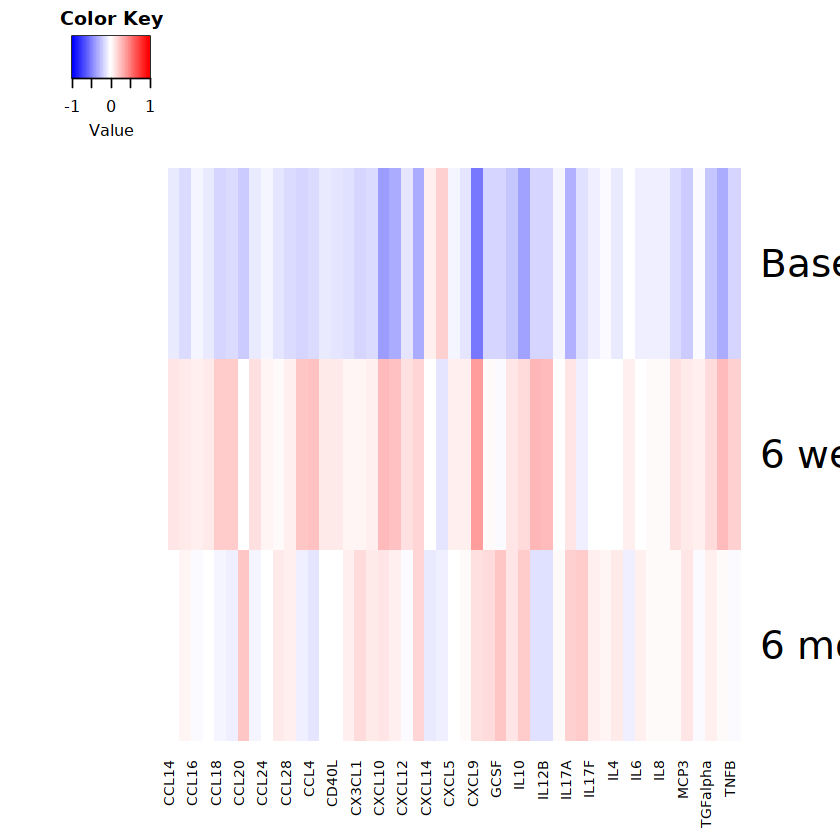

In [22]:
# generate heatmap example
heatmap_cytokines_time(discovery, cytokines, label = "cytokines", folder, factor = "time")

## Looking at the non-responder co-regulated module

In [21]:
NR.module <- list(c("VIM", "ABL1", "S100A11", "EGLN1", "DFFA", "EN-RAGE", "TNFSF14", "OSM", "NAMPT", "LIF", "CSCL13", "IL10", "Beta-NGF", 
               "BRK1", "BCAN", "MUC-16", "STC1", "MIA", "ADGRG1", "IL8", "DCTPP1", "OPN", "NRP2", "GDF-15", "IGF1R",
               "NT-proBNP", "KLK4", "IL6", "MK", "HGB", "TNC", "vWF", "AREG", "ST2", "MATN3", "CCL20", "PRTN3", 
               "CLEC4D", "TNF-alpha", "FGF-23", "TFPI-2", "LTBP2", "TIMP1", "IL-18R1", "VWA1", "OPG", "CDH3", "DRAXIN",
               "WISP-1", "PGF", "EPHA2", "TNFRSF19", "SCARF2", "EDA2R", "TNFRSF6B", "CLM-1", "CD300E", "U-PAR", 
               "TNF-R2", "IL-18BP", "SIGLEC1", "GFR-alpha-1", "SCARB2", "N2DL-2", "LTBR", "TNFRSF14", "TNF-R1",
               "FGF-21", "CSTB", "FABP4", "CKAP4", "VEGFA"))

### Scoring each sample for the co-regulated model

In [148]:
# wide dataframe that is transposed and with unique common gene names
discovery.gsva = discovery %>% mutate(label.full=paste0(patient,"_",Timepoint)) %>% 
    dplyr::select(label.full, Assay, Name, NPX) %>%
    group_by(label.full) %>%
    distinct(Name, .keep_all = TRUE) %>%
    ungroup() %>%
    dcast(Name ~ label.full, value.var="NPX", fun.aggregate=mean)
rownames(discovery.gsva) <- discovery.gsva$Name
discovery.gsva <- select(discovery.gsva, -Name)
discovery.gsva

Warning message in dcast(., Name ~ label.full, value.var = "NPX", fun.aggregate = mean):
"The dcast generic in data.table has been passed a tbl_df and will attempt to redirect to the reshape2::dcast; please note that reshape2 is deprecated, and this redirection is now deprecated as well. Please do this redirection yourself like reshape2::dcast(.). In the next version, this warning will become an error."


107_6-month 107_6-week 107_Baseline 136_6-month 136_Baseline
4E-BP1     10.77898    10.76720   10.76938      8.75949     8.45759    
5'-NT      13.48842    13.68420   13.41801     11.37363    11.46277    
ABL1        5.60399     5.23629    5.30018      3.47586     3.45033    
ACAA1       4.05994     4.70648    4.40997      1.98166     1.78969    
ADA         4.04078     6.64461    4.39401      3.44866     3.21437    
ADAM 22     4.76978     4.29653    4.41919      4.47723     4.64567    
ADAM 23     7.63530     7.36211    7.51716      4.25777     4.02839    
ADAM 8      5.29415     5.76367    5.43820      4.75121     4.31416    
ADAM-TS 15  4.95425     4.85964    5.53388      3.53202     3.26581    
ADGRG1      5.86020         NaN    5.99899      1.85141     1.65141    
AFP         5.24693     5.25407    5.72899      5.36162     5.15227    
AIF1        2.71491     2.79490    3.00448      1.42657     1.47959    
AIMP1       4.89197     4.79241    4.89255      3.33443     3.53357    
AKR1B1      6.05804     5.67455    5.88866      4.14603     4.09115    
ALCAM       8.41171     8.15633    8.42145      7.05119     7.16928    
ALPP        6.04563     6.06978    5.89550      5.49969     5.92999    
ANG         6.91288     7.08597    6.63430      6.50111     6.28873    
ANG-1       9.29078         NaN    9.21301      7.09452     8.12829    
ANGPT2      5.71861         NaN    5.96334      5.43244     4.76416    
ANGPTL3     4.30444     4.80723    4.14945      4.80270     3.61835    
ANXA1       6.34492     6.23529    6.15023      4.33614     3.91541    
AOC3        3.19789     3.47596    3.48440      2.73419     3.07154    
AP-N        6.90052     6.71494    7.27153      5.07899     5.00943    
APOM        6.68428     6.64036    6.56820      6.62662     6.20941    
AREG        2.95102     3.78139    2.33597      2.53868     1.43715    
ARHGAP25    1.81658     2.15953    1.67534     -0.00191     0.66786    
ARNT       -0.14419     0.19423   -0.46764     -0.86746    -0.59849    
ARTN        1.20893     1.34159    1.26769      0.40601     0.30187    
ATP6V1D     0.58807     0.96823    0.75194      0.24063     0.20504    
AXIN1       4.55281     5.07452    4.85370      3.49290     4.41587    
...        ...         ...        ...          ...         ...         
UNC5C      6.54292      6.19114   6.12860       5.86371    5.27388     
USO1       3.06455      3.14390   3.03493       1.80102    2.11196     
VASN       2.01292      2.07307   1.68410       2.10681    1.60346     
VAT1       6.14113      5.74271   6.07519       4.27539    4.26447     
VCAM1      5.86254      6.11947   5.99089       5.43117    5.00064     
VEGFA      9.64629     11.32019   9.70059       8.47199    8.07957     
VEGFC      1.78757          NaN   2.17975      -0.18591    0.28815     
VEGFR-2    7.13859      8.03846   7.22877       6.96140    6.92584     
VEGFR-3    8.78315      8.82022   8.64652       8.24237    7.84638     
VIM        7.60390      6.91845   7.45302       4.17720    4.87623     
VMO1       4.95937      4.09329   4.21096       3.17338    2.66598     
VPS37A     2.28282      2.09033   2.19142       0.86340    0.97158     
VPS53      1.73674      1.78355   1.72864       0.65115    1.17753     
VWA1       4.67525      4.42658   6.09174       3.78648    3.44900     
VWC2       5.35906      4.76969   4.78734       4.03693    4.04572     
WFDC2      9.83281      9.58037   9.14718       9.16974    8.80182     
WFIKKN1    3.39277      3.30861   3.42979       3.10302    3.31843     
WIF-1      6.48875      6.16496   6.29065       5.87583    5.78900     
WISP-1     7.84197      7.68129   7.73370       6.98117    6.29924     
XPNPEP2    7.07853      7.55266   7.49472       8.25031    8.32890     
YTHDF3     1.00153      0.96178   1.22062       0.14313    0.12021     
ZBTB16     2.50583      2.61146   2.66452       1.42228    2.05092     
gal-8      9.44252      8.80386   9.30180       8.51461    8.43901     
hK11       7.35067      7.18494   7.17300       7.2

In [149]:
# count matrix that is scaled
mat.gsva <- t(scale(t(as.matrix(discovery.gsva))))

In [150]:
# run gsva
nr.module.es <- gsva(mat.gsva, NR.module, method="gsva", 
                 kcdf="Gaussian", 
                 min.sz=1, 
                 max.sz=Inf, 
                 verbose=TRUE)
nr.module.es <- data.frame(t(nr.module.es))

Warning message in .filterFeatures(expr, method):
"406 genes with constant expression values throuhgout the samples."
Warning message in .filterFeatures(expr, method):
"Since argument method!="ssgsea", genes with constant expression values are discarded."


Estimating GSVA scores for 1 gene sets.
Estimating ECDFs with Gaussian kernels
  |======================================================================| 100%



In [151]:
nr.module.es$label.full <- rownames(nr.module.es)

In [152]:
discovery.wide <- merge(discovery.wide, nr.module.es, by="label.full")

In [153]:
discovery.wide <- discovery.wide %>% rename(nr.module.es = t.nr.module.es.)

In [154]:
# plot over all samples
fig <- ggplot(filter(discovery.wide, grouped_response == c("R", "NR")), aes(x=grouped_response, y=nr.module.es)) +
  geom_violin(trim=FALSE, fill=heat.colors(1024), alpha=0.5, size=1) +
  geom_boxplot(width=0.1, fill="white") +
  theme_classic() 
fig + stat_compare_means(label.x=1.25, label.y=1.5)

pdf("/seq/hacohenlab1/arnav/olink_melanoma/paper1/NR_module_violinplot_all.pdf")
fig + stat_compare_means(label.x=1.25, label.y=1.5)
dev.off()

Warning message in grouped_response == c("R", "NR"):
"longer object length is not a multiple of shorter object length"


cairo_pdf 
        2

Warning message in grouped_response == c("R", "NR"):
"longer object length is not a multiple of shorter object length"


cairo_pdf 
        2

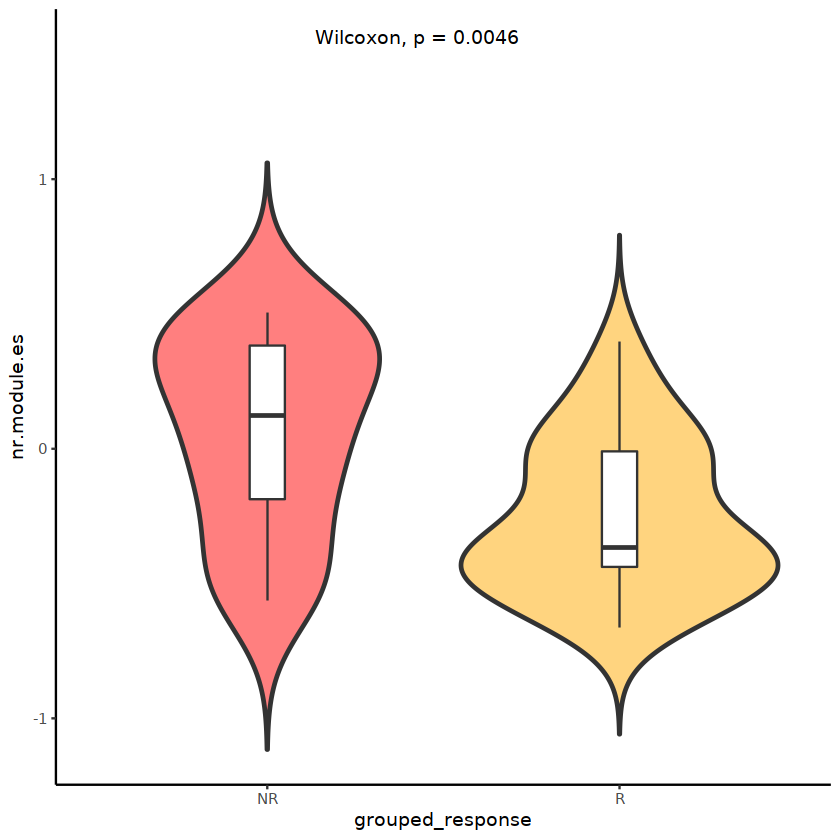

In [155]:
# plot over baseline samples
fig <- ggplot(filter(discovery.wide, Timepoint=="Baseline", grouped_response == c("R", "NR")), aes(x=grouped_response, y=nr.module.es)) +
  geom_violin(trim=FALSE, fill=heat.colors(1024), alpha=0.5, size=1) +
  geom_boxplot(width=0.1, fill="white") +
  theme_classic() 
fig + stat_compare_means(label.x=1.25, label.y=1.5)

pdf("/seq/hacohenlab1/arnav/olink_melanoma/paper1/NR_module_violinplot_baseline.pdf")
fig + stat_compare_means(label.x=1.25, label.y=1.5)
dev.off()

Warning message in grouped_response == c("R", "NR"):
"longer object length is not a multiple of shorter object length"


cairo_pdf 
        2

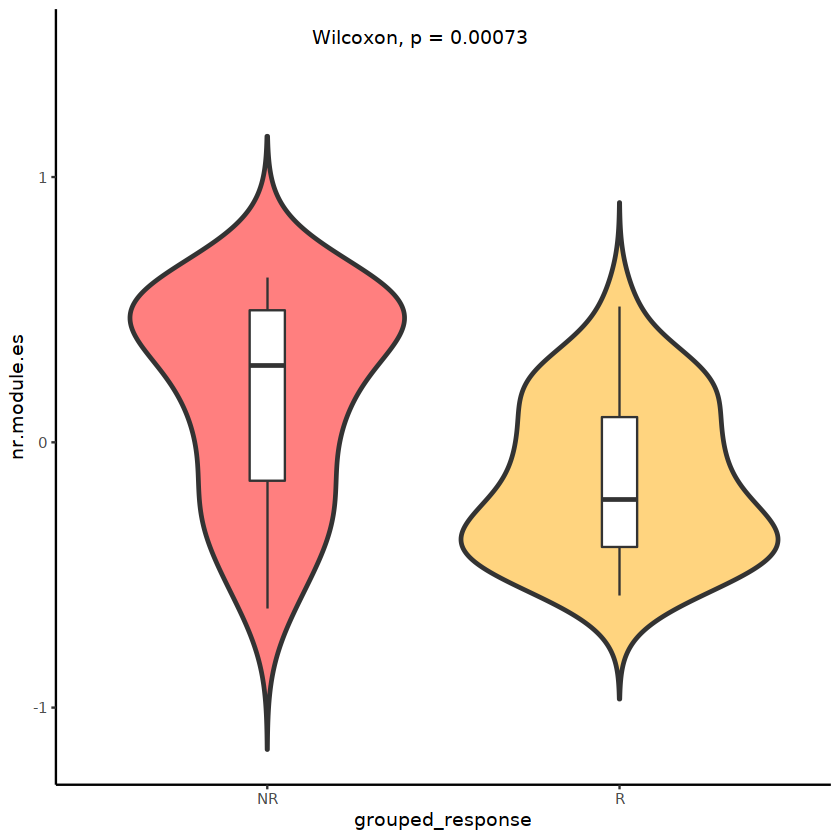

In [156]:
# plot over 6 week samples
fig <- ggplot(filter(discovery.wide, Timepoint=="6-week", grouped_response == c("R", "NR")), aes(x=grouped_response, y=nr.module.es)) +
  geom_violin(trim=FALSE, fill=heat.colors(1024), alpha=0.5, size=1) +
  geom_boxplot(width=0.1, fill="white") +
  theme_classic() 
fig + stat_compare_means(label.x=1.25, label.y=1.5)

pdf("/seq/hacohenlab1/arnav/olink_melanoma/paper1/NR_module_violinplot_6-week.pdf")
fig + stat_compare_means(label.x=1.25, label.y=1.5)
dev.off()

In [157]:
export <- discovery.wide %>% select(patient, Timepoint, nr.module.es)
write.csv(export, "/seq/hacohenlab1/arnav/olink_melanoma/paper1/gsva_nr-module_training.csv")

### Perform same scoring for validation dataset

In [158]:
# wide dataframe that is transposed and with unique common gene names
validation.gsva = validation %>% mutate(label.full=paste0(ID,"_",OnTr.3)) %>% 
    dplyr::select(label.full, Assay, Name, NPX) %>%
    group_by(label.full) %>%
    distinct(Name, .keep_all = TRUE) %>%
    ungroup() %>%
    dcast(Name ~ label.full, value.var="NPX", fun.aggregate=mean)
rownames(validation.gsva) <- validation.gsva$Name
validation.gsva <- select(validation.gsva, -Name)
validation.gsva

Warning message in dcast(., Name ~ label.full, value.var = "NPX", fun.aggregate = mean):
"The dcast generic in data.table has been passed a tbl_df and will attempt to redirect to the reshape2::dcast; please note that reshape2 is deprecated, and this redirection is now deprecated as well. Please do this redirection yourself like reshape2::dcast(.). In the next version, this warning will become an error."


102_6w    102_pre    115_NA     115_pre    122_NA     122_pre  
4E-BP1     5.029900   5.3037500  6.5561300  7.0228900  5.8016200  6.41156 
5'-NT      9.143810   8.9231200 10.6912700 10.3877400  9.3212200  9.49841 
ABL1       1.978340   1.9235300  2.0529300  2.2933900  1.9247300  2.26676 
ACAN       1.779750   1.8891900  1.7933700  1.9415600  2.2980100  2.08916 
ACE2       2.098460   1.8378200  2.5290000  2.7486000  2.0933200  2.43049 
ACP6       2.345720   2.3705500  1.9998000  1.6819200  2.5539600  2.45186 
ADA        1.257010   1.2869000  2.2219900  2.2064500  1.6658000  1.54011 
ADAM 22    2.538790   2.7059000  2.5797200  1.8887100  3.2227200  3.32665 
ADAM 23    2.737930   2.7701200  1.6598200  0.9247800  2.8567900  2.75576 
ADAM 8     2.591680   2.5909500  2.8337600  2.9186600  2.7304800  2.92208 
ADAM-TS 15 2.182520   2.1728600  2.4503000  2.1442700  1.6194000  1.68537 
ADAM-TS13  5.425470   5.4937300  5.2359600  5.1394500  5.2940600  5.53537 
ADGRE2     1.809730   1.6629700  2.4083300  2.6119800  2.6103300  2.49278 
ADGRG1     0.272076   0.3903636  0.5951346  0.6964950  0.9645051  1.12870 
ADGRG2     1.115790   1.3691900  0.7036700  0.7761200  0.4926700  0.52714 
ADM        5.135020   5.2618900  5.5866100  5.4199500  6.0881200  6.13546 
AGR2       2.031990   1.7495100  0.5267300 -0.2508567  3.4456900  0.86008 
AGRP       2.604980   2.8354400  3.0950800  3.4552900  3.3867700  3.46939 
AIFM1      0.026060   0.0151400  0.0041900  0.0944200 -0.0956900 -0.04576 
ALCAM      3.873280   4.1709000  4.1436800  3.9944700  4.4227400  4.14876 
ALDH1A1    0.675132   0.9366300  1.2328600  1.1985500  1.3919600  1.08799 
ALDH3A1    0.466740  -0.0252800  0.3015700 -0.3517993  0.1081700  0.30996 
AMBP       4.903620   4.8984900  4.3731200  4.4352500  4.8649400  4.99415 
AMIGO2     2.169380   1.8946300  2.2081500  1.7131400  2.3830400  2.39511 
AMN        0.715370   1.0616700  1.3750100  0.9345600  2.0960300  2.11687 
ANG        6.426740   6.4525000  5.6078500  6.0757900  6.0122100  6.06058 
ANG-1      6.776840   6.1539400  5.9326000  6.4995700  6.0972600  6.93842 
ANGPT2     3.508240   3.0346200  2.6339300  2.8144700  3.4530700  3.45785 
ANGPTL1    3.046190   3.3077000  2.3227200  2.5969800  2.3204200  2.35112 
ANGPTL3    1.500260   1.5384000  1.9946500  2.0343500  1.6977900  1.64777 
...        ...       ...        ...        ...        ...        ...      
VEGFD      7.0947700 7.081080   5.6956400  5.9693300  6.1934600  6.4177800
VEGFR-2    5.9181500 5.862860   5.5420300  5.3276800  5.5279300  5.5586000
VEGFR-3    6.3622600 6.424610   5.5953000  5.7011900  5.5796700  5.8503400
VIM        2.7161300 2.345150   2.1890100  3.4087100  2.0448400  2.6356900
VSIG2      1.6546100 1.591711   1.5382222  1.9015100  2.2848900  2.1284100
VSIG4      3.2239400 3.652710   3.2150600  4.0580900  4.9154000  4.3342500
VWC2       3.5677300 3.604590   2.5318800  2.4875400  3.1669700  3.3460500
WAS        0.4315889 1.330719   0.9138668  0.4239385  0.9999273  0.6590183
WASF1      0.1241300 0.477830   0.8251900  1.2587400  0.9379300  1.1139800
WFDC2      8.0290300 8.163270   7.6463800  7.1843900  7.7867400  7.9204700
WFIKKN1    0.8112300 0.566060   0.9509000  0.5469000  1.8756400  1.8453400
WFIKKN2    2.1573500 2.265460   1.9756200  2.0349700  2.8173600  2.6890700
WIF-1      4.6310700 4.227150   3.7623700  3.7086600  4.2390800  4.4169600
WISP-1     4.1587800 3.982140   5.0443100  4.7526900  4.5231100  4.8697700
WNT9A      0.3448700 0.966830   1.0461100  1.0440400  1.0377200  1.4463700
XCL1       3.1139400 3.023550   3.5360600  4.1958300  4.0052600  3.8562800
XG         3.2975000 3.374870   2.5501700  2.6904600  3.8818300  3.6002200
XPNPEP2    7.9613700 8.041470   5.6073300  5.4200800  7.1798700  7.3803200
YES1       3.3167900 3.676800   4.1965100  4.3683000  3.3405400  3.9852400
ZBTB16     1.5173500 1.879750   1.2298000  1.1975200  0.2932900  0.6570000
ZBTB17     0.2178700 0.686810   0.9370600  0.8408400  1.1642200  1.4083500
gal-8      5.2773200 5.260460   4.98

In [159]:
# count matrix that is scaled
mat.gsva <- t(scale(t(as.matrix(validation.gsva))))

# run gsva
nr.module.es <- gsva(mat.gsva, NR.module, method="gsva", 
                 kcdf="Gaussian", 
                 min.sz=1, 
                 max.sz=Inf, 
                 verbose=TRUE)
nr.module.es <- data.frame(t(nr.module.es))

nr.module.es$label.full <- rownames(nr.module.es)

Warning message in .filterFeatures(expr, method):
"570 genes with constant expression values throuhgout the samples."
Warning message in .filterFeatures(expr, method):
"Since argument method!="ssgsea", genes with constant expression values are discarded."


Estimating GSVA scores for 1 gene sets.
Estimating ECDFs with Gaussian kernels
  |======================================================================| 100%



In [160]:
validation.wide <- merge(validation.wide, nr.module.es, by="label.full")
validation.wide <- validation.wide %>% rename(nr.module.es = t.nr.module.es.)

In [161]:
export <- validation.wide %>% select(ID, OnTr.3, nr.module.es)
write.csv(export, "/seq/hacohenlab1/arnav/olink_melanoma/paper1/gsva_nr-module_testing.csv")

### Comparison of NR module to tumor bulk

In [162]:
prot <- "IL6"
OID <- discovery %>% 
    filter(Name==prot) %>% 
    pull(Assay) %>%
    unique()

plot <- ggplot(data=filter(discovery.wide, Timepoint=="6-week"), aes(x=LDH,y=OID00947))+
  geom_point(alpha=1)+
  # geom_hline(yintercept=0)+
  # geom_vline(xintercept=0)+
  # geom_abline()+
  geom_smooth(method="lm")+
  # labs(x=var1.name,y=var2.name)+
  # expand_limits(x = 0, y = 0)+
  theme_bw() +
  theme(panel.grid.major = element_blank(),
       panel.grid.minor = element_blank(),
       panel.border = element_blank(),
       axis.line = element_line(size = 0.5),
       strip.background = element_rect(fill = "white"))
plot

pdf(paste0("/seq/hacohenlab1/arnav/olink_melanoma/paper1/scatter_LDH-vs-", prot, "6-week.pdf"))
print(plot)
dev.off()

# linear model
lm.temp <- lm(data=filter(discovery.wide, Timepoint=="6-week"), LDH~OID00947)
summary(lm.temp)

`geom_smooth()` using formula 'y ~ x'

Warning message:
"Removed 6 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 6 rows containing missing values (geom_point)."
`geom_smooth()` using formula 'y ~ x'

Warning message:
"Removed 6 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 6 rows containing missing values (geom_point)."


cairo_pdf 
        2


Call:
lm(formula = LDH ~ OID00947, data = filter(discovery.wide, Timepoint == 
    "6-week"))

Residuals:
    Min      1Q  Median      3Q     Max 
-221.44  -68.88  -33.50   20.90 1104.16 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept)   107.30      48.51   2.212  0.02914 * 
OID00947       34.23      11.47   2.984  0.00353 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 167.5 on 105 degrees of freedom
  (6 observations deleted due to missingness)
Multiple R-squared:  0.07819,	Adjusted R-squared:  0.06941 
F-statistic: 8.907 on 1 and 105 DF,  p-value: 0.003535


In [163]:
# linear model
lm.temp <- lm(data=filter(discovery.wide, Timepoint=="Baseline"), LDH~OID00947)
summary(lm.temp)


Call:
lm(formula = LDH ~ OID00947, data = filter(discovery.wide, Timepoint == 
    "Baseline"))

Residuals:
    Min      1Q  Median      3Q     Max 
-194.71  -74.24  -36.62    5.60 1081.74 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)   136.60      55.45   2.464   0.0155 *
OID00947       29.95      13.70   2.187   0.0311 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 176.4 on 100 degrees of freedom
  (6 observations deleted due to missingness)
Multiple R-squared:  0.04563,	Adjusted R-squared:  0.03609 
F-statistic: 4.781 on 1 and 100 DF,  p-value: 0.03111


`geom_smooth()` using formula 'y ~ x'

Warning message:
"Removed 7 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 7 rows containing missing values (geom_point)."
`geom_smooth()` using formula 'y ~ x'

Warning message:
"Removed 7 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 7 rows containing missing values (geom_point)."


cairo_pdf 
        2


Call:
lm(formula = LDH ~ OID00752, data = filter(discovery.wide, Timepoint == 
    "6-week"))

Residuals:
    Min      1Q  Median      3Q     Max 
-344.08  -58.59  -16.06   44.05  893.31 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -344.32      82.38  -4.180 6.10e-05 ***
OID00752       90.24      12.46   7.245 7.85e-11 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 142.9 on 104 degrees of freedom
  (7 observations deleted due to missingness)
Multiple R-squared:  0.3354,	Adjusted R-squared:  0.329 
F-statistic: 52.49 on 1 and 104 DF,  p-value: 7.847e-11


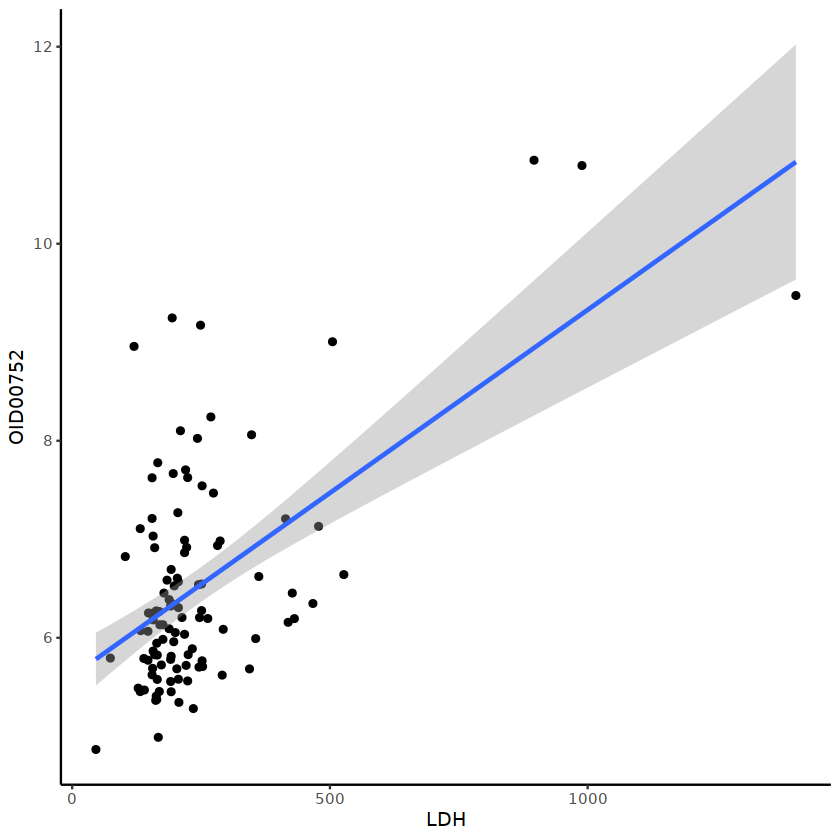

In [164]:
prot <- "IL8"

plot <- ggplot(data=filter(discovery.wide, Timepoint=="6-week"), aes(x=LDH,y=OID00752))+
  geom_point(alpha=1)+
  # geom_hline(yintercept=0)+
  # geom_vline(xintercept=0)+
  # geom_abline()+
  geom_smooth(method="lm")+
  # labs(x=var1.name,y=var2.name)+
  # expand_limits(x = 0, y = 0)+
  theme_bw() +
  theme(panel.grid.major = element_blank(),
       panel.grid.minor = element_blank(),
       panel.border = element_blank(),
       axis.line = element_line(size = 0.5),
       strip.background = element_rect(fill = "white"))
plot

pdf(paste0("/seq/hacohenlab1/arnav/olink_melanoma/paper1/scatter_LDH-vs-", prot, "6-week.pdf"))
print(plot)
dev.off()

# linear model
lm.temp <- lm(data=filter(discovery.wide, Timepoint=="6-week"), LDH~OID00752)
summary(lm.temp)

In [165]:
lm.temp <- lm(data=filter(discovery.wide, Timepoint=="Baseline"), LDH~OID00752)
summary(lm.temp)


Call:
lm(formula = LDH ~ OID00752, data = filter(discovery.wide, Timepoint == 
    "Baseline"))

Residuals:
    Min      1Q  Median      3Q     Max 
-336.30  -68.57  -17.87   26.31  861.71 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -362.65      87.47  -4.146 7.10e-05 ***
OID00752       95.30      13.38   7.124 1.65e-10 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 147.1 on 100 degrees of freedom
  (6 observations deleted due to missingness)
Multiple R-squared:  0.3367,	Adjusted R-squared:   0.33 
F-statistic: 50.75 on 1 and 100 DF,  p-value: 1.645e-10


`geom_smooth()` using formula 'y ~ x'

Warning message:
"Removed 8 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 8 rows containing missing values (geom_point)."
`geom_smooth()` using formula 'y ~ x'

Warning message:
"Removed 8 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 8 rows containing missing values (geom_point)."


cairo_pdf 
        2


Call:
lm(formula = LDH ~ OID00701, data = filter(discovery.wide, Timepoint == 
    "6-week"))

Residuals:
    Min      1Q  Median      3Q     Max 
-227.42  -75.97  -33.96   20.10 1082.70 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept)  -906.76     345.95  -2.621  0.01009 * 
OID00701      100.19      30.06   3.333  0.00119 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 167 on 103 degrees of freedom
  (8 observations deleted due to missingness)
Multiple R-squared:  0.09737,	Adjusted R-squared:  0.0886 
F-statistic: 11.11 on 1 and 103 DF,  p-value: 0.001193


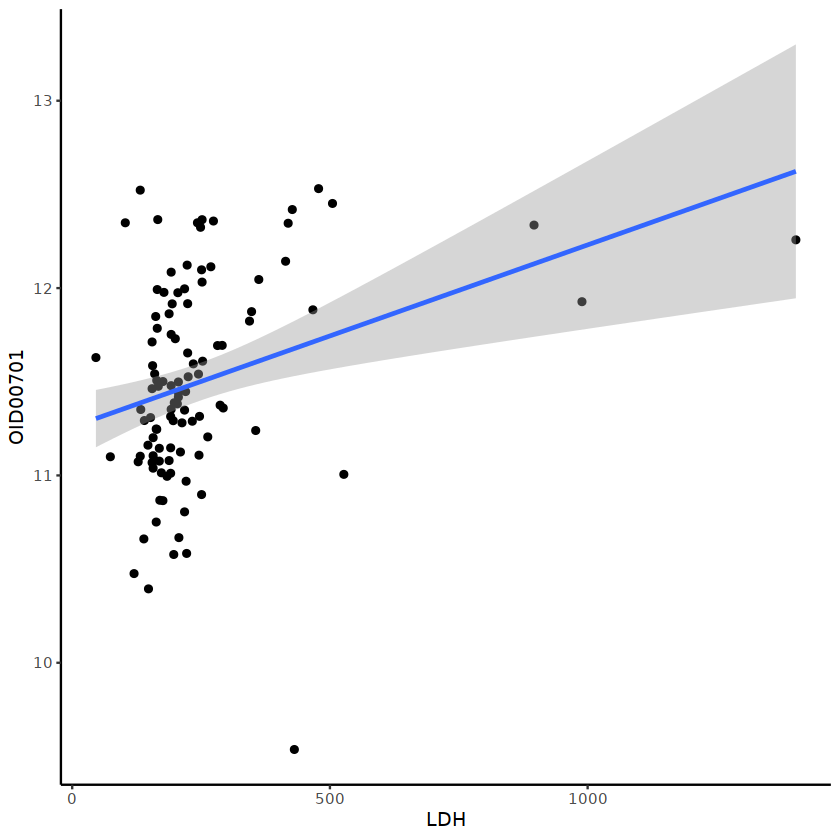

In [166]:
prot <- "MIA"

plot <- ggplot(data=filter(discovery.wide, Timepoint=="6-week"), aes(x=LDH,y=OID00701))+
  geom_point(alpha=1)+
  # geom_hline(yintercept=0)+
  # geom_vline(xintercept=0)+
  # geom_abline()+
  geom_smooth(method="lm")+
  # labs(x=var1.name,y=var2.name)+
  # expand_limits(x = 0, y = 0)+
  theme_bw() +
  theme(panel.grid.major = element_blank(),
       panel.grid.minor = element_blank(),
       panel.border = element_blank(),
       axis.line = element_line(size = 0.5),
       strip.background = element_rect(fill = "white"))
plot

pdf(paste0("/seq/hacohenlab1/arnav/olink_melanoma/paper1/scatter_LDH-vs-", prot, "6-week.pdf"))
print(plot)
dev.off()

# linear model
lm.temp <- lm(data=filter(discovery.wide, Timepoint=="6-week"), LDH~OID00701)
summary(lm.temp)

In [167]:
lm.temp <- lm(data=filter(discovery.wide, Timepoint=="Baseline"), LDH~OID00701)
summary(lm.temp)


Call:
lm(formula = LDH ~ OID00701, data = filter(discovery.wide, Timepoint == 
    "Baseline"))

Residuals:
    Min      1Q  Median      3Q     Max 
-200.83  -79.57  -38.77   10.78 1097.94 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept)  -804.90     372.00  -2.164  0.03287 * 
OID00701       91.27      32.10   2.843  0.00541 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 173.7 on 100 degrees of freedom
  (6 observations deleted due to missingness)
Multiple R-squared:  0.0748,	Adjusted R-squared:  0.06554 
F-statistic: 8.084 on 1 and 100 DF,  p-value: 0.005414


In [168]:
prot <- "LIF"

plot <- ggplot(data=filter(discovery.wide, Timepoint=="6-week"), aes(x=LDH,y=OID00547))+
  geom_point(alpha=1)+
  # geom_hline(yintercept=0)+
  # geom_vline(xintercept=0)+
  # geom_abline()+
  geom_smooth(method="lm")+
  # labs(x=var1.name,y=var2.name)+
  # expand_limits(x = 0, y = 0)+
  theme_bw() +
  theme(panel.grid.major = element_blank(),
       panel.grid.minor = element_blank(),
       panel.border = element_blank(),
       axis.line = element_line(size = 0.5),
       strip.background = element_rect(fill = "white"))
plot

pdf(paste0("/seq/hacohenlab1/arnav/olink_melanoma/paper1/scatter_LDH-vs-", prot, "6-week.pdf"))
print(plot)
dev.off()

# linear model
lm.temp <- lm(data=filter(discovery.wide, Timepoint=="6-week"), LDH~OID00547)
summary(lm.temp)

`geom_smooth()` using formula 'y ~ x'

Warning message:
"Removed 7 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 7 rows containing missing values (geom_point)."
`geom_smooth()` using formula 'y ~ x'

Warning message:
"Removed 7 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 7 rows containing missing values (geom_point)."


cairo_pdf 
        2


Call:
lm(formula = LDH ~ OID00547, data = filter(discovery.wide, Timepoint == 
    "6-week"))

Residuals:
    Min      1Q  Median      3Q     Max 
-234.66  -72.03  -28.30   21.62 1072.56 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   129.16      28.99   4.456 2.11e-05 ***
OID00547      140.01      30.23   4.632 1.05e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 159.2 on 104 degrees of freedom
  (7 observations deleted due to missingness)
Multiple R-squared:  0.171,	Adjusted R-squared:  0.163 
F-statistic: 21.46 on 1 and 104 DF,  p-value: 1.052e-05


In [169]:
# linear model
lm.temp <- lm(data=filter(discovery.wide, Timepoint=="Baseline"), LDH~OID00547)
summary(lm.temp)


Call:
lm(formula = LDH ~ OID00547, data = filter(discovery.wide, Timepoint == 
    "Baseline"))

Residuals:
    Min      1Q  Median      3Q     Max 
-218.57  -80.47  -36.40    2.23 1081.05 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   195.07      28.98   6.731 1.07e-09 ***
OID00547       73.22      29.25   2.504   0.0139 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 175.4 on 100 degrees of freedom
  (6 observations deleted due to missingness)
Multiple R-squared:  0.05898,	Adjusted R-squared:  0.04957 
F-statistic: 6.268 on 1 and 100 DF,  p-value: 0.01391


In [170]:
plot <- ggplot(data=filter(discovery.wide, Timepoint=="Baseline"), aes(x=LDH,y=nr.module.es))+
  geom_point(alpha=1)+
  # geom_hline(yintercept=0)+
  # geom_vline(xintercept=0)+
  # geom_abline()+
  geom_smooth(method="lm")+
  # labs(x=var1.name,y=var2.name)+
  # expand_limits(x = 0, y = 0)+
  theme_bw() +
  theme(panel.grid.major = element_blank(),
       panel.grid.minor = element_blank(),
       panel.border = element_blank(),
       axis.line = element_line(size = 0.5),
       strip.background = element_rect(fill = "white"))
plot

pdf("/seq/hacohenlab1/arnav/olink_melanoma/paper1/scatter_LDH-vs-NRmodule_baseline.pdf")
print(plot)
dev.off()

# linear model
lm.temp <- lm(data=filter(discovery.wide, Timepoint=="Baseline"), LDH~nr.module.es)
summary(lm.temp)

`geom_smooth()` using formula 'y ~ x'

Warning message:
"Removed 4 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 4 rows containing missing values (geom_point)."
`geom_smooth()` using formula 'y ~ x'

Warning message:
"Removed 4 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 4 rows containing missing values (geom_point)."


cairo_pdf 
        2


Call:
lm(formula = LDH ~ nr.module.es, data = filter(discovery.wide, 
    Timepoint == "Baseline"))

Residuals:
    Min      1Q  Median      3Q     Max 
-218.61  -74.54  -27.83   16.00 1042.50 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)    263.11      16.49  15.953  < 2e-16 ***
nr.module.es   186.50      45.47   4.101 8.27e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 166 on 102 degrees of freedom
  (4 observations deleted due to missingness)
Multiple R-squared:  0.1416,	Adjusted R-squared:  0.1332 
F-statistic: 16.82 on 1 and 102 DF,  p-value: 8.27e-05


`geom_smooth()` using formula 'y ~ x'

Warning message:
"Removed 5 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 5 rows containing missing values (geom_point)."
`geom_smooth()` using formula 'y ~ x'

Warning message:
"Removed 5 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 5 rows containing missing values (geom_point)."


cairo_pdf 
        2


Call:
lm(formula = LDH ~ nr.module.es, data = filter(discovery.wide, 
    Timepoint == "6-week"))

Residuals:
    Min      1Q  Median      3Q     Max 
-216.20  -75.30  -41.86   26.28 1085.37 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)    248.79      15.89  15.654  < 2e-16 ***
nr.module.es   153.77      43.36   3.546 0.000583 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 164.3 on 106 degrees of freedom
  (5 observations deleted due to missingness)
Multiple R-squared:  0.1061,	Adjusted R-squared:  0.09763 
F-statistic: 12.58 on 1 and 106 DF,  p-value: 0.0005832


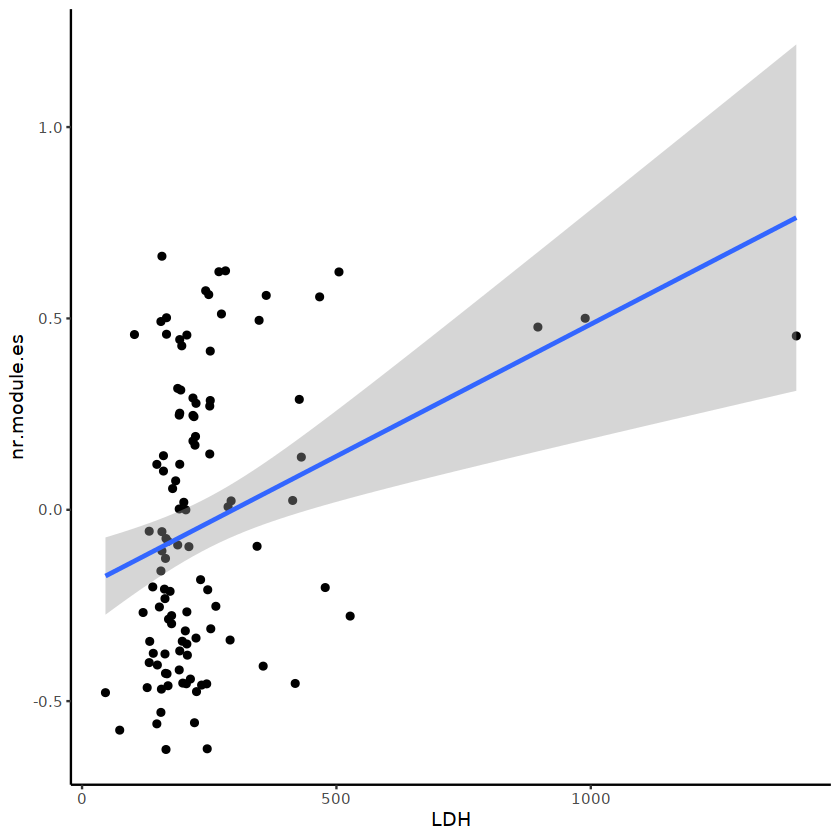

In [171]:
plot <- ggplot(data=filter(discovery.wide, Timepoint=="6-week"), aes(x=LDH,y=nr.module.es))+
  geom_point(alpha=1)+
  # geom_hline(yintercept=0)+
  # geom_vline(xintercept=0)+
  # geom_abline()+
  geom_smooth(method="lm")+
  # labs(x=var1.name,y=var2.name)+
  # expand_limits(x = 0, y = 0)+
  theme_bw() +
  theme(panel.grid.major = element_blank(),
       panel.grid.minor = element_blank(),
       panel.border = element_blank(),
       axis.line = element_line(size = 0.5),
       strip.background = element_rect(fill = "white"))
plot

pdf("/seq/hacohenlab1/arnav/olink_melanoma/paper1/scatter_LDH-vs-NRmodule_6-week.pdf")
print(plot)
dev.off()

# linear model
lm.temp <- lm(data=filter(discovery.wide, Timepoint=="6-week"), LDH~nr.module.es)
summary(lm.temp)

### Module score vs ANC/AMC

`geom_smooth()` using formula 'y ~ x'

Warning message:
"Removed 3 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 3 rows containing missing values (geom_point)."
`geom_smooth()` using formula 'y ~ x'

Warning message:
"Removed 3 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 3 rows containing missing values (geom_point)."


cairo_pdf 
        2


Call:
lm(formula = ANC ~ nr.module.es, data = filter(discovery.wide, 
    Timepoint == "Baseline"))

Residuals:
    Min      1Q  Median      3Q     Max 
-4.1269 -1.5163 -0.3157  1.1796  5.5784 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)    4.8359     0.1973  24.515  < 2e-16 ***
nr.module.es   1.9970     0.5460   3.657 0.000403 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.994 on 103 degrees of freedom
  (3 observations deleted due to missingness)
Multiple R-squared:  0.1149,	Adjusted R-squared:  0.1064 
F-statistic: 13.38 on 1 and 103 DF,  p-value: 0.0004034


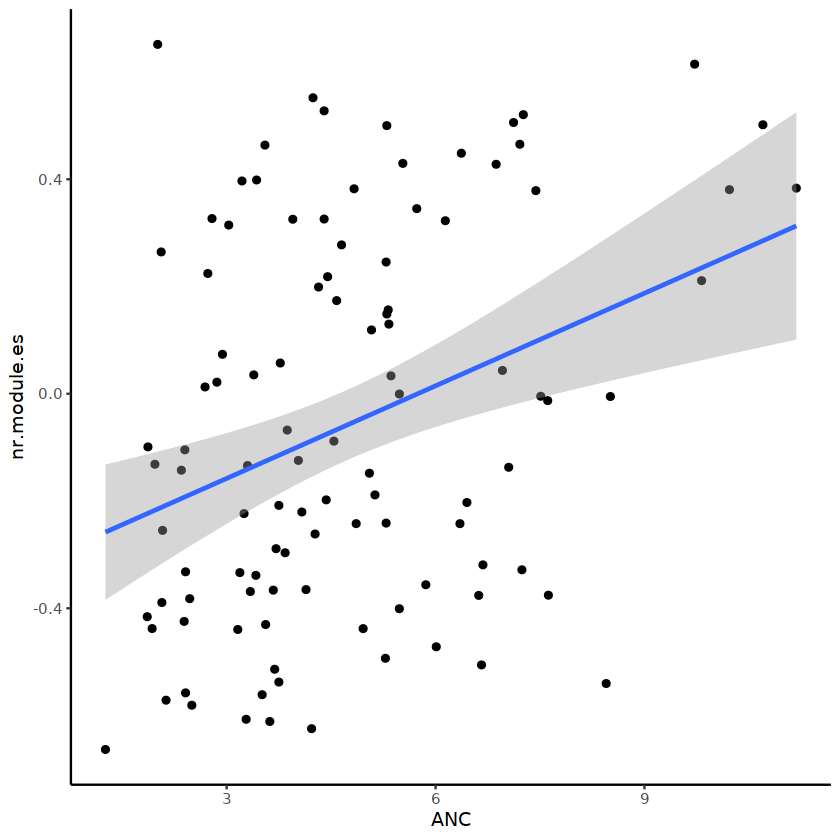

In [172]:
plot <- ggplot(data=filter(discovery.wide, Timepoint=="Baseline"), aes(x=ANC,y=nr.module.es))+
  geom_point(alpha=1)+
  # geom_hline(yintercept=0)+
  # geom_vline(xintercept=0)+
  # geom_abline()+
  geom_smooth(method="lm")+
  # labs(x=var1.name,y=var2.name)+
  # expand_limits(x = 0, y = 0)+
  theme_bw() +
  theme(panel.grid.major = element_blank(),
       panel.grid.minor = element_blank(),
       panel.border = element_blank(),
       axis.line = element_line(size = 0.5),
       strip.background = element_rect(fill = "white"))
plot

pdf("/seq/hacohenlab1/arnav/olink_melanoma/paper1/scatter_ANC-vs-NRmodule_baseline.pdf")
print(plot)
dev.off()

# linear model
lm.temp <- lm(data=filter(discovery.wide, Timepoint=="Baseline"), ANC~nr.module.es)
summary(lm.temp)

`geom_smooth()` using formula 'y ~ x'

Warning message:
"Removed 4 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 4 rows containing missing values (geom_point)."
`geom_smooth()` using formula 'y ~ x'

Warning message:
"Removed 4 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 4 rows containing missing values (geom_point)."


cairo_pdf 
        2


Call:
lm(formula = AMC ~ nr.module.es, data = filter(discovery.wide, 
    Timepoint == "Baseline"))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.55142 -0.15358 -0.00695  0.13988  0.73394 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   0.66422    0.02347  28.300  < 2e-16 ***
nr.module.es  0.30269    0.06469   4.679 8.88e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.236 on 102 degrees of freedom
  (4 observations deleted due to missingness)
Multiple R-squared:  0.1767,	Adjusted R-squared:  0.1686 
F-statistic: 21.89 on 1 and 102 DF,  p-value: 8.875e-06


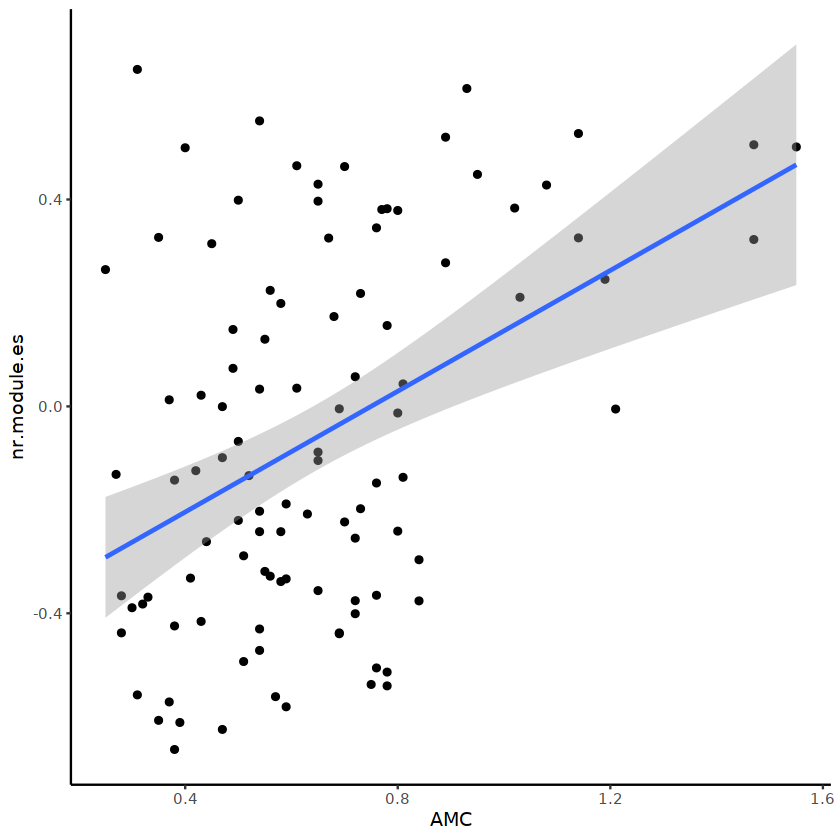

In [173]:
plot <- ggplot(data=filter(discovery.wide, Timepoint=="Baseline"), aes(x=AMC,y=nr.module.es))+
  geom_point(alpha=1)+
  # geom_hline(yintercept=0)+
  # geom_vline(xintercept=0)+
  # geom_abline()+
  geom_smooth(method="lm")+
  # labs(x=var1.name,y=var2.name)+
  # expand_limits(x = 0, y = 0)+
  theme_bw() +
  theme(panel.grid.major = element_blank(),
       panel.grid.minor = element_blank(),
       panel.border = element_blank(),
       axis.line = element_line(size = 0.5),
       strip.background = element_rect(fill = "white"))
plot

pdf("/seq/hacohenlab1/arnav/olink_melanoma/paper1/scatter_AMC-vs-NRmodule_baseline.pdf")
print(plot)
dev.off()

# linear model
lm.temp <- lm(data=filter(discovery.wide, Timepoint=="Baseline"), AMC~nr.module.es)
summary(lm.temp)

### Survival curves using NR module

In [174]:
# first define a function that takes timepoint, type of analysis (os/pfs), expression data frame, significant genes
# and then produces K-M curves for each gene and perfoms log-rank test for difference between curves

# R function that takes timepoint (Baseline, 6-week or 6-month), type of survival (os or pfs), data frame with data, and data frame with differentially expressed genes
kmplot <- function(tp, analysis_type, df) {
  
  if (analysis_type == "os") {
      survival.data <- df %>% filter(Timepoint == tp)
      
      # original data is such that 0 = "dead" and 1 = "alive", which is not convention for survival analysis
      # fix census_os so "0" is no event or alive, and "1" is an event or death
      survival.data <- mutate(survival.data, censure_os = ifelse(censure_os == 0, 1, 0))
      
      # perform survival analysis
      # want quantiles for NPX, for now we will just split into two groups based on median
      NR.quantile <- quantile(survival.data$nr.module.es)
      survival.data <- mutate(survival.data, NR.level = factor(nr.module.es > median(nr.module.es, na.rm = TRUE), labels = c("low", "high")))
      survival.object <- Surv(as.numeric(survival.data$os), as.numeric(survival.data$censure_os))
      fit <- survfit(survival.object ~ NR.level, data = survival.data)
      summary(fit) 
      # print(summary(fit))
      
      # plot survival curves
      # ggsurvplot(fit, data = survival.data, pval=TRUE)
      plot(fit, col=c("blue","red"), xlab = "Days", ylab = "Overall survival probability", lwd=3)
      legend("topright",c("low expression","high expression"),col=c("blue","red"),lty=1, lwd=3)
      
      pdf("/seq/hacohenlab1/arnav/olink_melanoma/paper1/NR-module-KM-curve_OS.pdf")
      plot(fit, col=c("blue","red"), xlab = "Days", ylab = "Overall survival probability", lwd=3)
      legend("topright",c("low expression","high expression"),col=c("blue","red"),lty=1, lwd=3)
      dev.off()
      
      # Log rank test for differences between groups
      log.rank <- survdiff(survival.object ~ NR.level, data = survival.data)
      print(log.rank)
  }
  
  else if (analysis_type == "pfs") {
      
      data.v.NAremoved <- df %>% filter(pfs != "UN" & pfs != "NA" & censure_pfs != "NA")
      survival.data <- data.v.NAremoved %>% filter(Timepoint == tp)
      
      # original data is such that 0 = "dead" and 1 = "alive", which is not convention for survival analysis
      # fix census_os so "0" is no event or alive, and "1" is an event or death
      survival.data <- mutate(survival.data, censure_pfs = ifelse(censure_pfs == 1, 0, 1))
      survival.data <- mutate(survival.data, pfs = ifelse(pfs == "quickly", "42", pfs))
      
      # perform survival analysis
      # want quantiles for NPX, for now we will just split into two groups based on median
      NR.quantile <- quantile(survival.data$nr.module.es)
      survival.data <- mutate(survival.data, NR.level = factor(nr.module.es > median(nr.module.es, na.rm = TRUE), labels = c("low", "high")))
      survival.object <- Surv(as.numeric(survival.data$pfs), as.numeric(survival.data$censure_pfs))
      fit <- survfit(survival.object ~ NR.level, data = survival.data)
      summary(fit) 
      # print(summary(fit))
      
      # plot survival curves
      # ggsurvplot(fit, data = survival.data, pval=TRUE)
      plot(fit, col=c("blue","red"), xlab = "Days", ylab = "Overall survival probability", lwd=3)
      legend("topright",c("low expression","high expression"),col=c("blue","red"),lty=1, lwd=3)
      
      pdf("/seq/hacohenlab1/arnav/olink_melanoma/paper1/NR-module-KM-curve_PFS.pdf")
      plot(fit, col=c("blue","red"), xlab = "Days", ylab = "Overall survival probability", lwd=3)
      legend("topright",c("low expression","high expression"),col=c("blue","red"),lty=1, lwd=3)
      dev.off()
      
      # Log rank test for differences between groups
      log.rank <- survdiff(survival.object ~ NR.level, data = survival.data)
      print(log.rank)
  }
  
  else print("invalid analysis type")
  
}

Call:
survdiff(formula = survival.object ~ NR.level, data = survival.data)

n=105, 3 observations deleted due to missingness.

               N Observed Expected (O-E)^2/E (O-E)^2/V
NR.level=low  52        9     19.8      5.87      13.1
NR.level=high 53       27     16.2      7.16      13.1

 Chisq= 13.1  on 1 degrees of freedom, p= 3e-04 


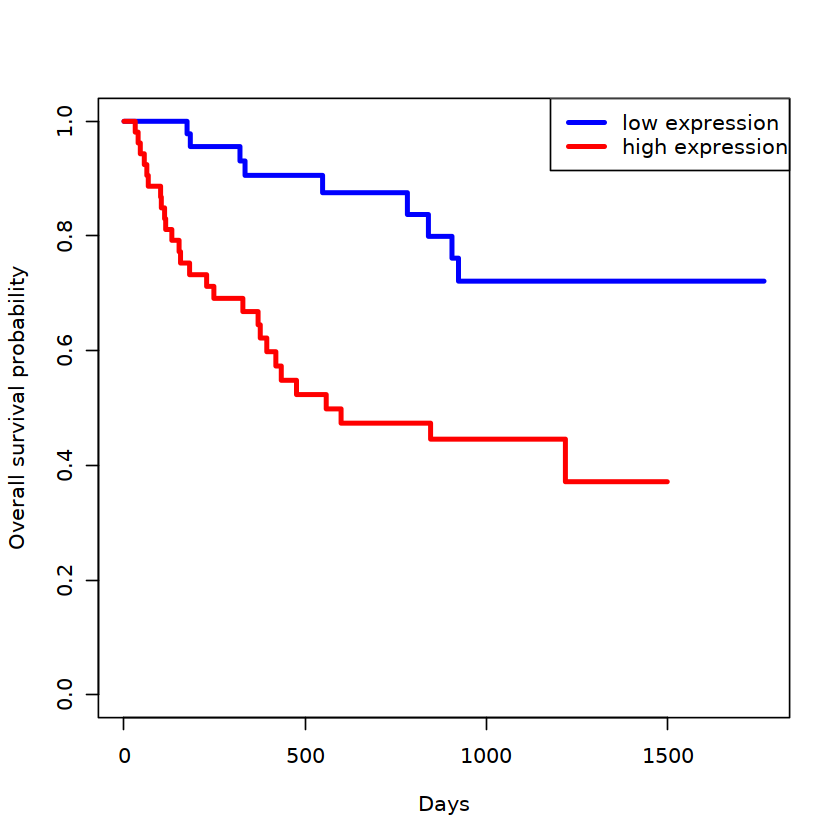

In [175]:
# survival analysis for overall survical (os) at baseline timepoint
tp <- "Baseline"
analysis_type = "os"
kmplot(tp, analysis_type, discovery.wide)

Call:
survdiff(formula = survival.object ~ NR.level, data = survival.data)

               N Observed Expected (O-E)^2/E (O-E)^2/V
NR.level=low  53       29       42      4.02      10.4
NR.level=high 52       40       27      6.24      10.4

 Chisq= 10.4  on 1 degrees of freedom, p= 0.001 


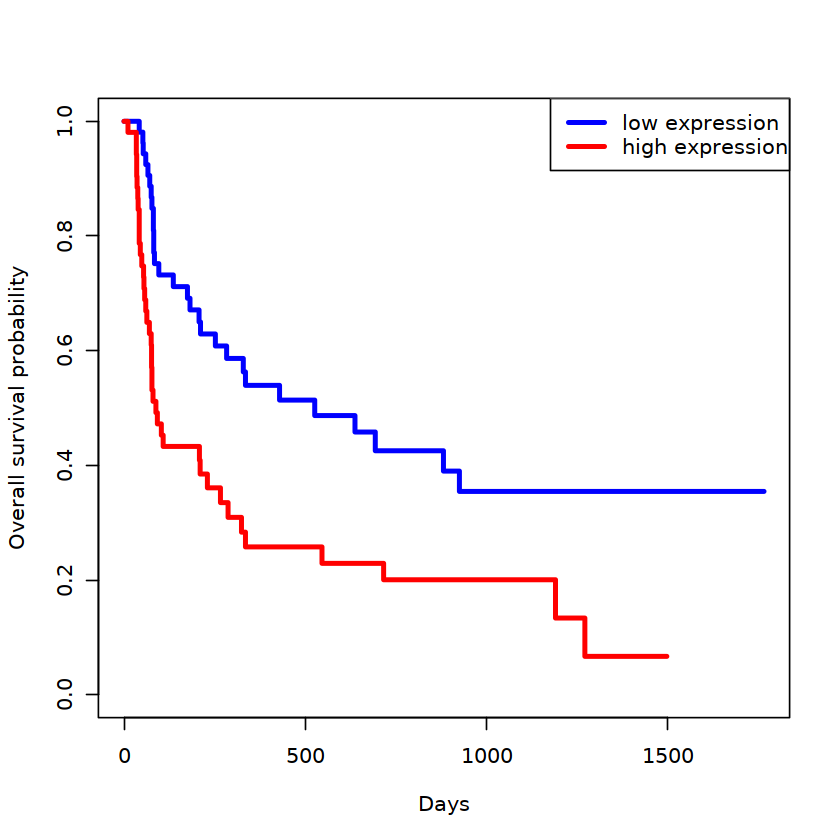

In [176]:
# survival analysis for overall survical (os) at baseline timepoint
tp <- "Baseline"
analysis_type = "pfs"
kmplot(tp, analysis_type, discovery.wide)

## Analysis of single-cell gene expression data 

In [5]:
immune <- readRDS("/seq/hacohenlab1/arnav/olink_melanoma/paper1/single-cell-data/immune_cells_merge.RDS")

In [6]:
myeloid <- readRDS("/seq/hacohenlab1/arnav/olink_melanoma/paper1/single-cell-data/myeloid_cells.RDS")

In [7]:
# macs <- subset(x = myeloid, subset = cluster == "3")
macs <- readRDS("/seq/hacohenlab1/arnav/olink_melanoma/paper1/macs_cells.rds")

In [8]:
tumor <- readRDS("/seq/hacohenlab1/arnav/olink_melanoma/paper1/single-cell-data/tumor_cells_merge.RDS")

### Exploration of immune cell population

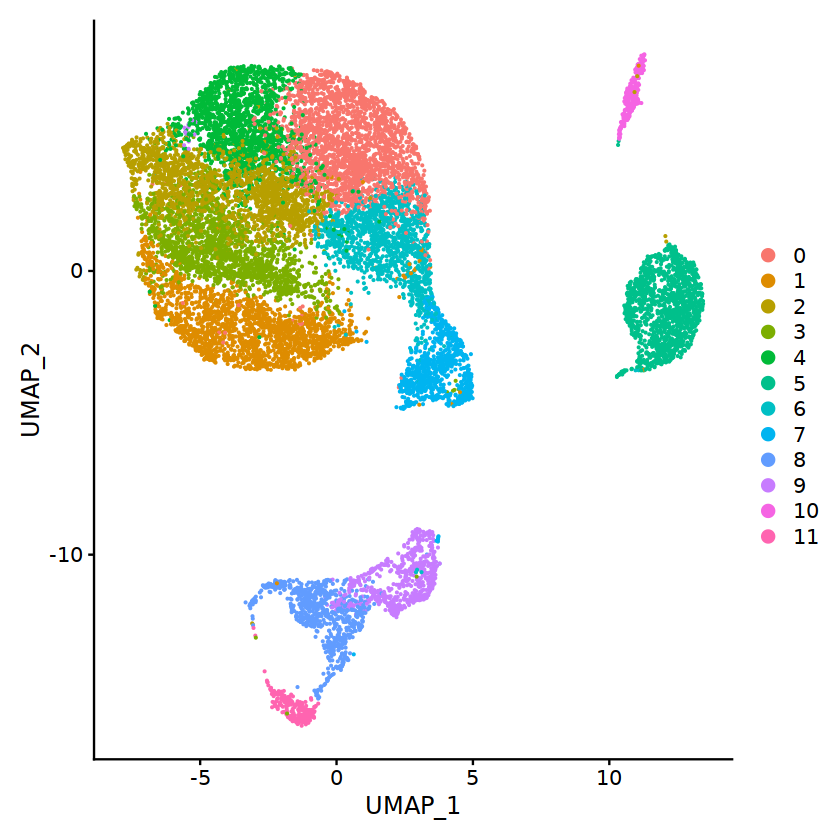

In [180]:
DimPlot(immune, reduction = "umap")

In [181]:
immune <- AddModuleScore(immune, NR.module, name='NR_module')

Warning message:
"The following features are not present in the object: EN-RAGE, CSCL13, Beta-NGF, BCAN, MUC-16, STC1, MIA, ADGRG1, OPN, GDF-15, NT-proBNP, KLK4, MK, HGB, vWF, ST2, MATN3, PRTN3, TNF-alpha, FGF-23, TFPI-2, IL-18R1, VWA1, OPG, CDH3, DRAXIN, WISP-1, TNFRSF19, SCARF2, EDA2R, CLM-1, U-PAR, TNF-R2, IL-18BP, GFR-alpha-1, N2DL-2, TNF-R1, FGF-21, FABP4, not searching for symbol synonyms"


In [182]:
genes <- c("VIM", "ABL1", "S100A11", "EGLN1", "DFFA", "EN-RAGE", "TNFSF14", "OSM", "NAMPT", "LIF", "CSCL13", "IL10", "Beta-NGF", 
               "BRK1", "BCAN", "MUC-16", "STC1", "MIA", "ADGRG1", "IL8", "DCTPP1", "OPN", "NRP2", "GDF-15", "IGF1R",
               "NT-proBNP", "KLK4", "IL6", "MK", "HGB", "TNC", "vWF", "AREG", "ST2", "MATN3", "CCL20", "PRTN3", 
               "CLEC4D", "TNF-alpha", "FGF-23", "TFPI-2", "LTBP2", "TIMP1", "IL-18R1", "VWA1", "OPG", "CDH3", "DRAXIN",
               "WISP-1", "PGF", "EPHA2", "TNFRSF19", "SCARF2", "EDA2R", "TNFRSF6B", "CLM-1", "CD300E", "U-PAR", 
               "TNF-R2", "IL-18BP", "SIGLEC1", "GFR-alpha-1", "SCARB2", "N2DL-2", "LTBR", "TNFRSF14", "TNF-R1",
               "FGF-21", "CSTB", "FABP4", "CKAP4", "VEGFA")

Warning message in DoHeatmap(immune, features = genes, group.by = "cluster", size = 4, :
"The following features were omitted as they were not found in the scale.data slot for the RNA assay: FABP4, FGF-21, TNF-R1, N2DL-2, GFR-alpha-1, IL-18BP, TNF-R2, U-PAR, CLM-1, EDA2R, SCARF2, TNFRSF19, WISP-1, DRAXIN, CDH3, OPG, VWA1, IL-18R1, TFPI-2, FGF-23, TNF-alpha, PRTN3, MATN3, ST2, vWF, HGB, MK, KLK4, NT-proBNP, GDF-15, OPN, ADGRG1, MIA, STC1, MUC-16, BCAN, Beta-NGF, CSCL13, EN-RAGE"
Warning message in DoHeatmap(immune, features = genes, group.by = "cluster", size = 4, :
"The following features were omitted as they were not found in the scale.data slot for the RNA assay: FABP4, FGF-21, TNF-R1, N2DL-2, GFR-alpha-1, IL-18BP, TNF-R2, U-PAR, CLM-1, EDA2R, SCARF2, TNFRSF19, WISP-1, DRAXIN, CDH3, OPG, VWA1, IL-18R1, TFPI-2, FGF-23, TNF-alpha, PRTN3, MATN3, ST2, vWF, HGB, MK, KLK4, NT-proBNP, GDF-15, OPN, ADGRG1, MIA, STC1, MUC-16, BCAN, Beta-NGF, CSCL13, EN-RAGE"


cairo_pdf 
        2

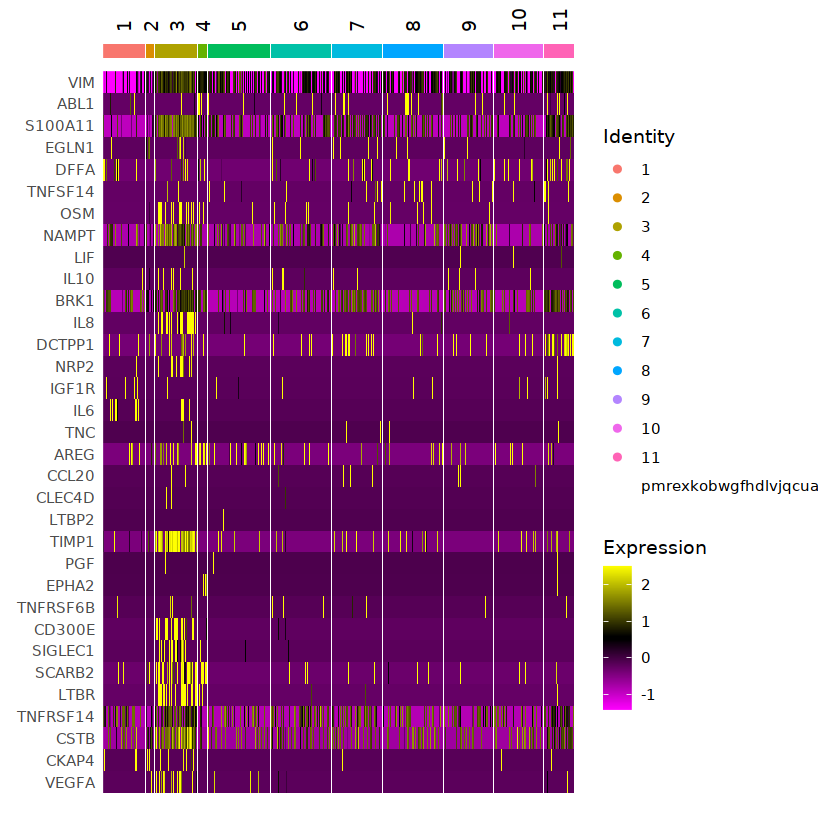

In [183]:
DoHeatmap(immune, features=genes, group.by="cluster", size = 4, angle = 90)

pdf("/seq/hacohenlab1/arnav/olink_melanoma/paper1/NR-module_single-cell-immune-heatmap.pdf")
DoHeatmap(immune, features=genes, group.by="cluster", size = 4, angle = 90)
dev.off()

Warning message in FetchData(object = object, vars = features, cells = cells):
"The following requested variables were not found (10 out of 39 shown): EN-RAGE, CSCL13, Beta-NGF, BCAN, MUC-16, STC1, MIA, ADGRG1, OPN, GDF-15"
Warning message in FetchData(object = object, vars = features, cells = cells):
"The following requested variables were not found (10 out of 39 shown): EN-RAGE, CSCL13, Beta-NGF, BCAN, MUC-16, STC1, MIA, ADGRG1, OPN, GDF-15"


cairo_pdf 
        2

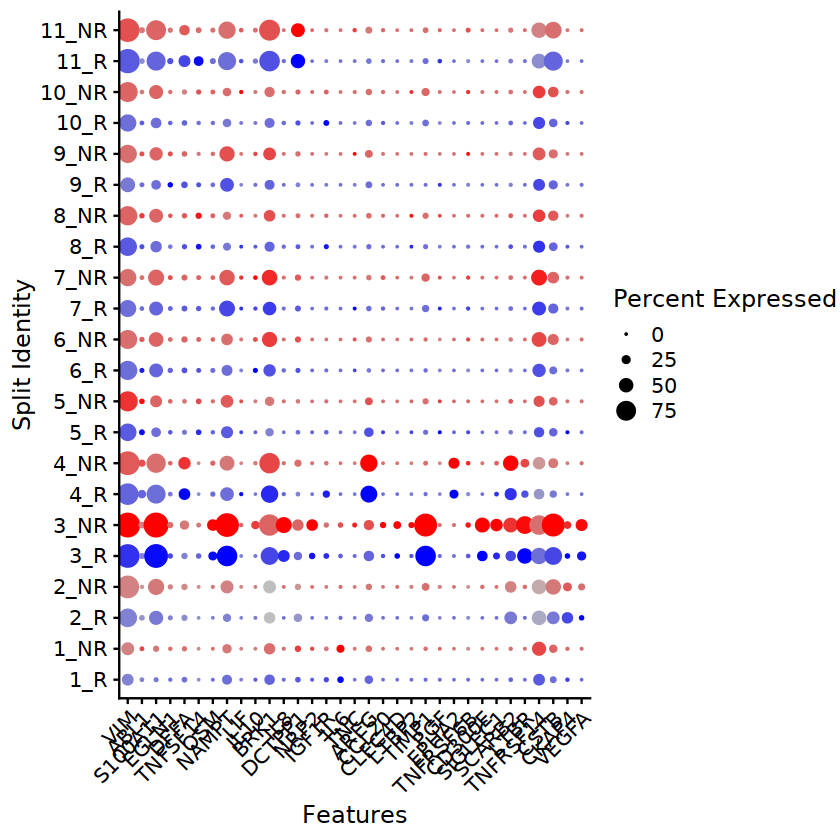

In [184]:
DotPlot(immune, features=genes, group.by="cluster", split.by="response", cols = c("blue", "red")) + RotatedAxis()

pdf("/seq/hacohenlab1/arnav/olink_melanoma/paper1/NR-module_single-cell-immune-dotplot.pdf")
DotPlot(immune, features=genes, group.by="cluster", cols = c("blue", "red")) + RotatedAxis()
dev.off()

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



cairo_pdf 
        2

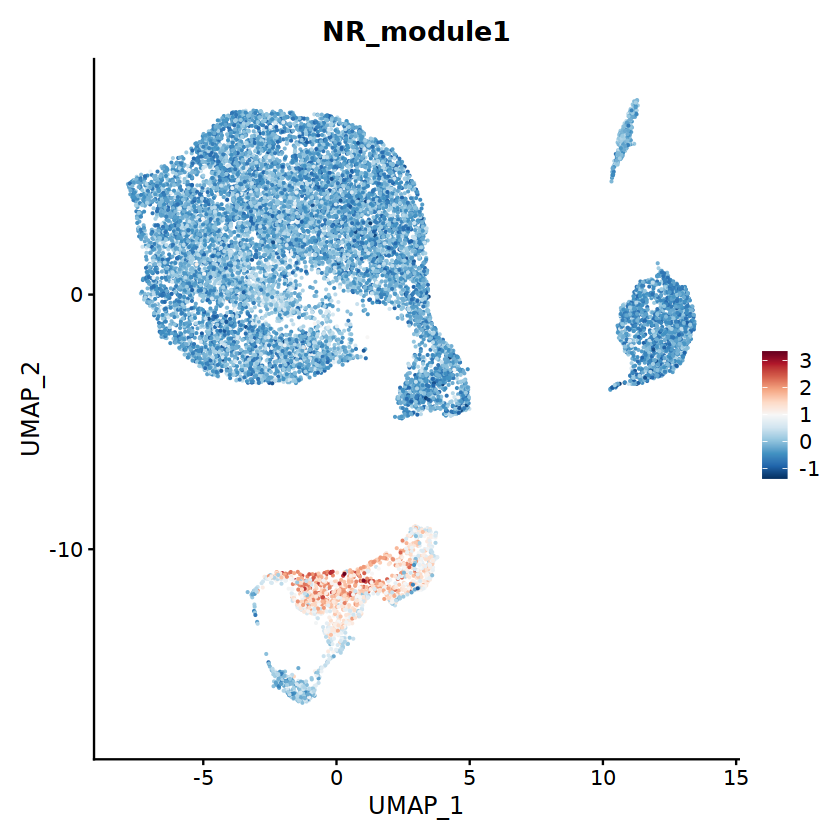

In [185]:
FeaturePlot(immune, features = "NR_module1") +
            scale_colour_gradientn(colours = rev(brewer.pal(n = 11, name = "RdBu")))

pdf("/seq/hacohenlab1/arnav/olink_melanoma/paper1/NR-module_single-cell-immune-tsne.pdf")
FeaturePlot(immune, features = "NR_module1") +
            scale_colour_gradientn(colours = rev(brewer.pal(n = 11, name = "RdBu")))
dev.off()

Picking joint bandwidth of 0.0823

Picking joint bandwidth of 0.0823



cairo_pdf 
        2

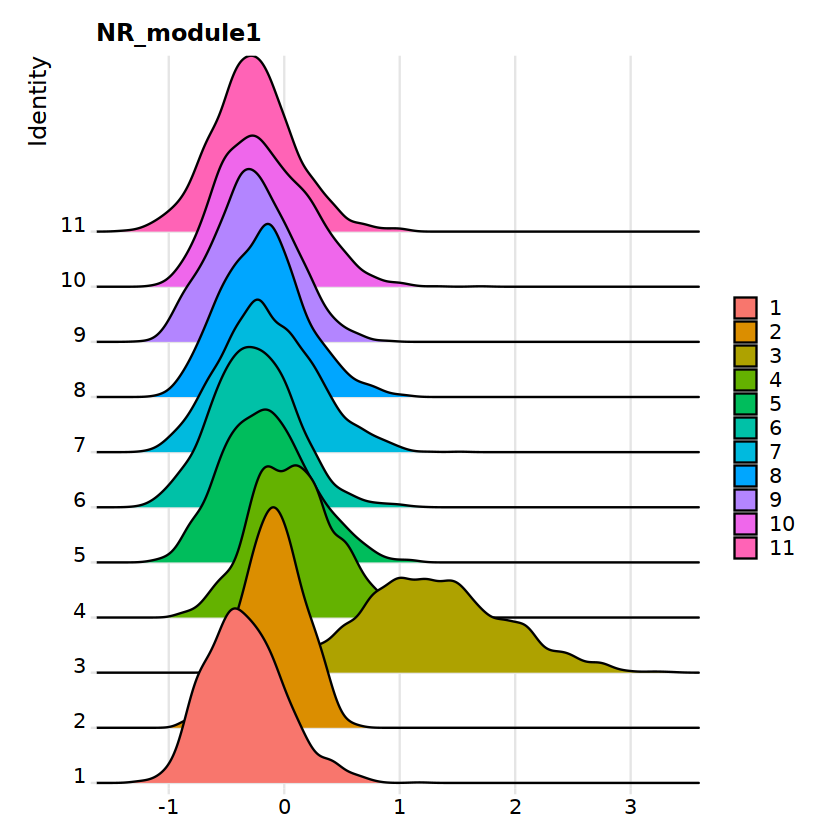

In [186]:
RidgePlot(immune, features="NR_module1", group.by="cluster")

pdf("/seq/hacohenlab1/arnav/olink_melanoma/paper1/NR-module_single-cell-immune-ridgeplot.pdf")
RidgePlot(immune, features="NR_module1", group.by="cluster")
dev.off()

### Exploration of myeloid cell population

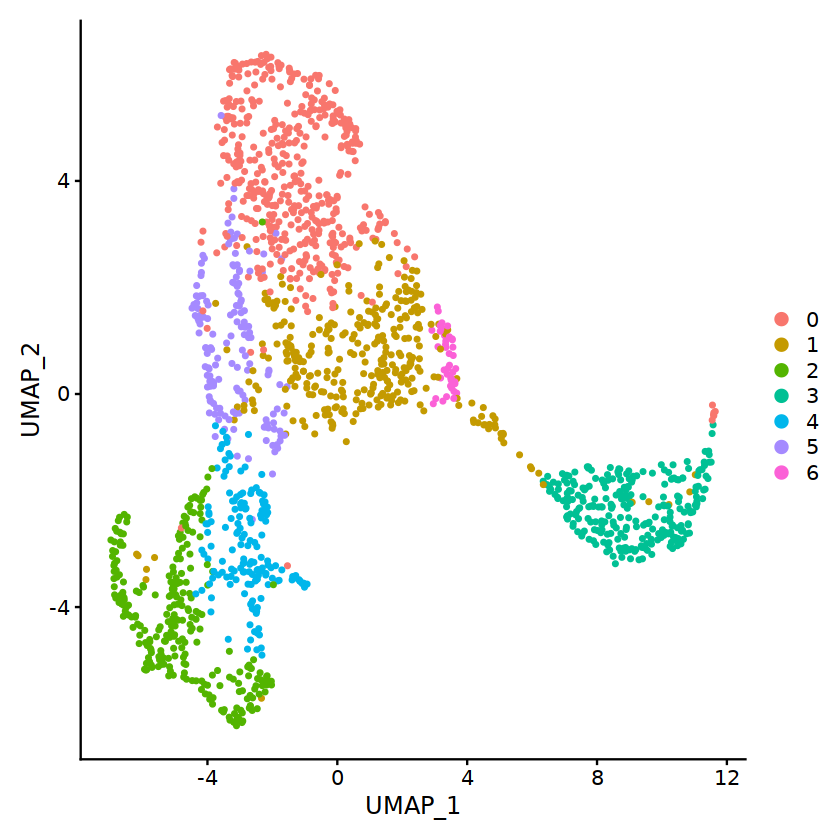

In [7]:
DimPlot(myeloid, reduction = "umap")

In [188]:
myeloid <- AddModuleScore(myeloid, NR.module, name='NR_module')

Warning message:
"The following features are not present in the object: EN-RAGE, CSCL13, Beta-NGF, BCAN, MUC-16, STC1, MIA, ADGRG1, OPN, GDF-15, NT-proBNP, KLK4, MK, HGB, vWF, ST2, MATN3, PRTN3, TNF-alpha, FGF-23, TFPI-2, IL-18R1, VWA1, OPG, CDH3, DRAXIN, WISP-1, TNFRSF19, SCARF2, EDA2R, CLM-1, U-PAR, TNF-R2, IL-18BP, GFR-alpha-1, N2DL-2, TNF-R1, FGF-21, FABP4, not searching for symbol synonyms"


In [189]:
DoHeatmap(myeloid, features=genes, size = 4, angle = 90)

pdf("/seq/hacohenlab1/arnav/olink_melanoma/paper1/NR-module_single-cell-myeloid-heatmap.pdf")
DoHeatmap(myeloid, features=genes, size = 4, angle = 90)
dev.off()

Warning message in DoHeatmap(myeloid, features = genes, size = 4, angle = 90):
"The following features were omitted as they were not found in the scale.data slot for the RNA assay: FABP4, FGF-21, TNF-R1, N2DL-2, GFR-alpha-1, IL-18BP, TNF-R2, U-PAR, CLM-1, EDA2R, SCARF2, TNFRSF19, WISP-1, DRAXIN, CDH3, OPG, VWA1, IL-18R1, TFPI-2, FGF-23, TNF-alpha, PRTN3, MATN3, ST2, vWF, HGB, MK, KLK4, NT-proBNP, GDF-15, OPN, ADGRG1, MIA, STC1, MUC-16, BCAN, Beta-NGF, CSCL13, EN-RAGE"
Warning message in DoHeatmap(myeloid, features = genes, size = 4, angle = 90):
"The following features were omitted as they were not found in the scale.data slot for the RNA assay: FABP4, FGF-21, TNF-R1, N2DL-2, GFR-alpha-1, IL-18BP, TNF-R2, U-PAR, CLM-1, EDA2R, SCARF2, TNFRSF19, WISP-1, DRAXIN, CDH3, OPG, VWA1, IL-18R1, TFPI-2, FGF-23, TNF-alpha, PRTN3, MATN3, ST2, vWF, HGB, MK, KLK4, NT-proBNP, GDF-15, OPN, ADGRG1, MIA, STC1, MUC-16, BCAN, Beta-NGF, CSCL13, EN-RAGE"


cairo_pdf 
        2

In [190]:
DotPlot(myeloid, features=genes) + RotatedAxis()

pdf("/seq/hacohenlab1/arnav/olink_melanoma/paper1/NR-module_single-cell-myeloid-dotplot.pdf")
DotPlot(myeloid, features=genes) + RotatedAxis()
dev.off()

Warning message in FetchData(object = object, vars = features, cells = cells):
"The following requested variables were not found (10 out of 39 shown): EN-RAGE, CSCL13, Beta-NGF, BCAN, MUC-16, STC1, MIA, ADGRG1, OPN, GDF-15"
Warning message in FetchData(object = object, vars = features, cells = cells):
"The following requested variables were not found (10 out of 39 shown): EN-RAGE, CSCL13, Beta-NGF, BCAN, MUC-16, STC1, MIA, ADGRG1, OPN, GDF-15"


cairo_pdf 
        2

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



cairo_pdf 
        2

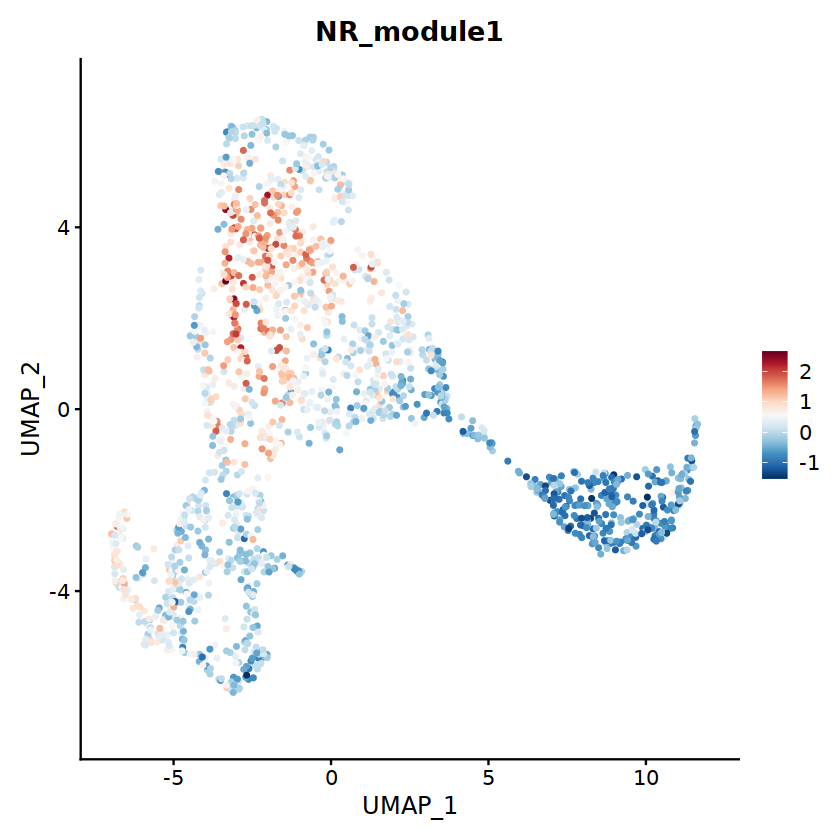

In [191]:
FeaturePlot(myeloid, features = "NR_module1") +
            scale_colour_gradientn(colours = rev(brewer.pal(n = 11, name = "RdBu")))

pdf("/seq/hacohenlab1/arnav/olink_melanoma/paper1/NR-module_single-cell-myeloid-tsne.pdf")
FeaturePlot(myeloid, features = "NR_module1") +
            scale_colour_gradientn(colours = rev(brewer.pal(n = 11, name = "RdBu")))
dev.off()

In [192]:
RidgePlot(myeloid, features="NR_module1")

pdf("/seq/hacohenlab1/arnav/olink_melanoma/paper1/NR-module_single-cell-myeloid-ridgeplot.pdf")
RidgePlot(myeloid, features="NR_module1")
dev.off()

Picking joint bandwidth of 0.154

Picking joint bandwidth of 0.154



cairo_pdf 
        2

In [193]:
myeloid.markers <- FindAllMarkers(myeloid, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
myeloid.markers %>%
    group_by(cluster) %>%
    slice_max(n = 10, order_by = avg_log2FC)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6



p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster gene    
1    1.372083e-15 3.304899   0.559 0.439  1.696444e-11 0       NLRP3   
2    6.060910e-04 3.272184   0.265 0.200  1.000000e+00 0       MXD3    
3    2.119647e-18 3.139682   0.349 0.184  2.620731e-14 0       C19orf38
4    4.644129e-23 3.131397   0.603 0.433  5.742002e-19 0       LYST    
5    7.338075e-27 3.043921   0.311 0.104  9.072796e-23 0       MEFV    
6    3.087279e-11 3.025581   0.279 0.153  3.817112e-07 0       GABBR1  
7    4.668901e-09 2.947703   0.276 0.174  5.772629e-05 0       FCAR    
8    2.079324e-11 2.902950   0.272 0.140  2.570877e-07 0       LDLR    
9    1.766124e-17 2.795522   0.318 0.151  2.183636e-13 0       ALDH1A2 
10   6.647819e-98 2.780857   0.866 0.387  8.219364e-94 0       FCN1    
11   1.836378e-84 5.294808   0.488 0.076  2.270498e-80 1       CD1C    
12   2.207903e-34 3.858980   0.286 0.062  2.729851e-30 1       CD1E    
13   4.634331e-37 3.714587   0.277 0.051  5.729887e-33 1       FCER1A  
14   2.724031e-84 3.495786   0.664 0.180  3.367991e-80 1       CLEC10A 
15   9.512965e-42 3.398836   0.307 0.057  1.176183e-37 1       CXCL9   
16   7.210857e-63 3.204031   0.682 0.256  8.915503e-59 1       AXL     
17   1.001969e-49 3.015454   0.381 0.078  1.238834e-45 1       CXCL10  
18   3.935333e-30 2.980853   0.336 0.099  4.865646e-26 1       RSAD2   
19   1.119767e-46 2.743348   0.366 0.077  1.384480e-42 1       CST7    
20   6.625714e-77 2.701714   0.440 0.054  8.192032e-73 1       IDO1    
21   4.788173e-80 6.352477   0.316 0.014  5.920097e-76 2       SULT1C2 
22   5.317271e-46 6.300247   0.283 0.038  6.574274e-42 2       CCNA2   
23   3.787264e-90 6.250016   0.309 0.006  4.682573e-86 2       NDP     
24   7.554222e-55 5.939781   0.265 0.021  9.340040e-51 2       RRM2    
25   5.860127e-72 5.378946   0.254 0.006  7.245461e-68 2       CLLU1OS 
26  4.120536e-120 4.989993   0.978 0.466 5.094631e-116 2       FBP1    
27   3.945366e-48 4.964053   0.312 0.045  4.878050e-44 2       TYMS    
28   9.472589e-90 4.697177   0.349 0.014  1.171191e-85 2       SLC28A3 
29   8.680069e-47 4.646487   0.353 0.066  1.073204e-42 2       KIAA0101
30   8.989902e-53 4.515973   0.257 0.021  1.111511e-48 2       BIRC5   
... ...           ...        ...   ...   ...           ...     ...     
41   2.913280e-54 5.592812   0.331 0.030  3.601979e-50 4       CCL13   
42  9.551407e-127 4.979871   0.637 0.044 1.180936e-122 4       FCGBP   
43  4.398087e-101 3.652660   0.812 0.135  5.437795e-97 4       FOLR2   
44   4.205333e-88 3.648633   0.594 0.060  5.199473e-84 4       SEPP1   
45   1.317123e-95 3.641683   0.706 0.101  1.628491e-91 4       COLEC12 
46   3.907184e-62 3.592863   0.369 0.032  4.830842e-58 4       EMP2    
47   7.681592e-83 3.549334   0.381 0.020  9.497521e-79 4       CXADR   
48  1.991169e-114 3.537927   0.838 0.118 2.461882e-110 4       GPR34   
49   5.282238e-96 3.506193   0.831 0.161  6.530959e-92 4       SLC2A5  
50   5.890011e-03 3.486161   0.425 0.313  1.000000e+00 4       WWTR1   
51   4.499460e-21 3.944641   0.273 0.062  5.563132e-17 5       CXCL1   
52   4.258047e-10 3.813688   0.318 0.149  5.264649e-06 5       C3      
53   7.879890e-10 3.774908   0.552 0.400  9.742696e-06 5       LILRB5  
54   3.505942e-48 3.762435   0.961 0.529  4.334746e-44 5       CTSL    
55   3.898531e-34 3.654908   0.552 0.192  4.820144e-30 5       VMO1    
56   3.560576e-38 3.585782   0.545 0.140  4.402296e-34 5       SDS     
57   1.325701e-21 3.578630   0.474 0.190  1.639097e-17 5       OLFML2B 
58   9.043737e-13 3.505581   0.351 0.148  1.118168e-08 5       HS3ST1  
59   3.958647e-31 3.384537   0.890 0.510  4.894471e-27 5       CD163   
60   3.119951e-19 3.300114   0.403 0.142  3.857507e-15 5       IL10    
61  2.374989e-182 8.721492   0.732 0.009 2.936436e-178 6       CLNK    
62  6.941237e-150 7.648766   0.610 0.007 8.582145e-146 6       ENPP1   
63   1.670195e-44 6.766676   0.341 0.015  2.065029e-40 6       TACSTD2 
64   8.246179e-69 6.147776   0.341 0.007  1.

In [194]:
myeloid.markers %>%
    group_by(cluster) %>%
    top_n(n = 10, wt = avg_log2FC) -> top10
DoHeatmap(myeloid, features = top10$gene) + NoLegend()

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



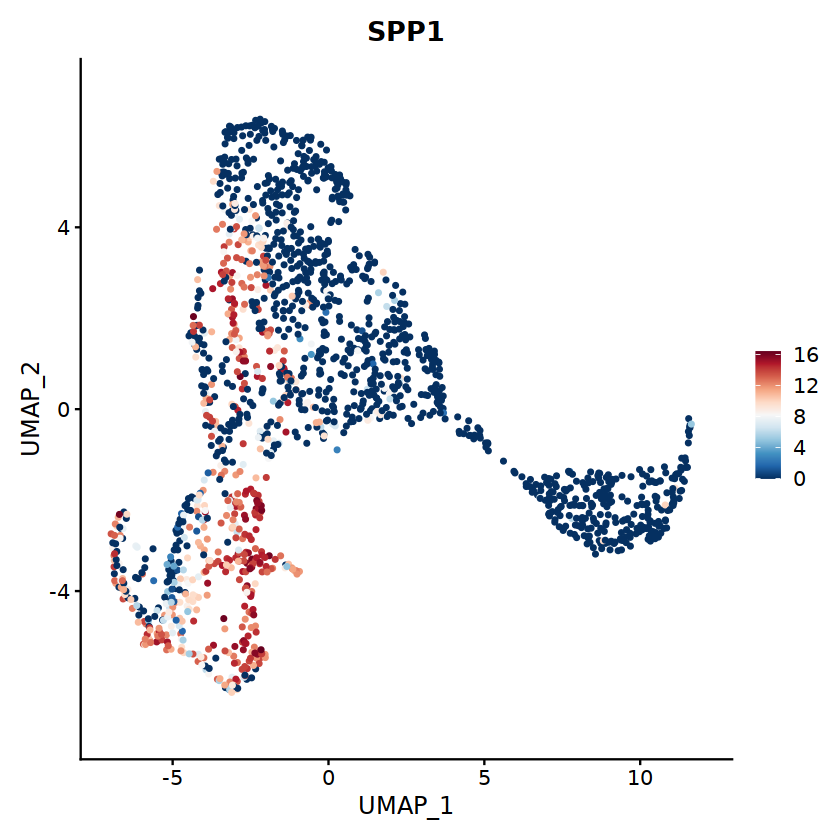

In [24]:
FeaturePlot(myeloid, features = "SPP1") +
            scale_colour_gradientn(colours = rev(brewer.pal(n = 11, name = "RdBu")))

### Explore of macrophage subsets

In [9]:
macs <- RunPCA(macs, features = VariableFeatures(object = macs))

Warning message in PrepDR(object = object, features = features, verbose = verbose):
"The following 5 features requested have zero variance (running reduction without them): IGLV8-61, HTR3A, IGHV7-81, TRAV39, IGHV3-74"
PC_ 1 
Positive:  MT1F, MT1E, MT1G, MT1X, MT1H, MGST3, PLTP, GSN, FN1, APOC1 
	   RAB13, TREM2, HNMT, DNPH1, PRDX2, SLAMF8, MDH1, FBP1, VSIG4, MT1M 
	   TUBB, ACP2, PROCR, PDPN, NME1, SLC38A6, IL7R, PLAU, SLCO2B1, CLEC5A 
Negative:  CFP, APOBEC3A, SAT1, LILRA5, DDX3Y, PLAC8, PADI4, ISG20, RPS4Y1, BIRC3 
	   LIPN, SELL, IFI44L, C19orf38, ICAM3, CD300E, CFD, S100A12, IFITM1, IRF7 
	   HSH2D, DUSP2, ASGR2, CD52, THBS1, AGPAT9, FCN1, CD36, VNN2, OASL 
PC_ 2 
Positive:  CST7, CD1C, HLA-DOB, IDO1, SLC38A1, ASB2, RPS23, AMICA1, BCL11A, NDRG2 
	   PPA1, P2RY14, HLA-DQA1, RPL10A, RPSA, RPS5, EEF1B2, SELL, PLD4, RPS27 
	   RPL23A, HLA-DPB1, SLAMF7, LGALS2, CLNK, CD74, SPIB, IL2RG, RPS13, RPL31 
Negative:  CTSL, CTSD, CD14, SLC11A1, GPNMB, FCGR3A, FTL, CD163, NPL, CD68 
	   CTSB, FC

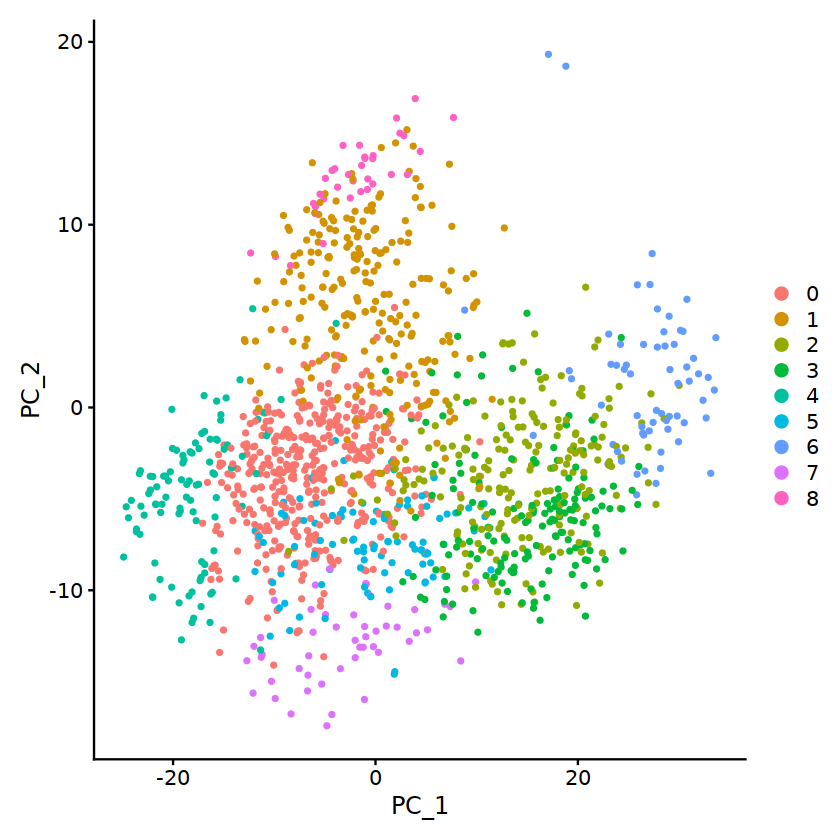

In [10]:
DimPlot(macs, reduction = "pca")

In [11]:
macs <- FindNeighbors(macs, dims = 1:40)
macs <- FindClusters(macs, resolution = 0.1)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1391
Number of edges: 47156

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9362
Number of communities: 3
Elapsed time: 0 seconds


In [12]:
macs <- RunUMAP(macs, dims = 1:40)

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
03:17:13 UMAP embedding parameters a = 0.9922 b = 1.112

03:17:13 Read 1391 rows and found 40 numeric columns

03:17:13 Using Annoy for neighbor search, n_neighbors = 30

03:17:13 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

03:17:13 Writing NN index file to temp file /local/scratch/29180762.1.interactive/RtmpRFhaly/file1ce9053637a2d

03:17:13 Searching Annoy index using 1 thread, search_k = 3000

03:17:14 Annoy recall = 100%

03:17:15 Commencing smooth kNN distance calibration using 1

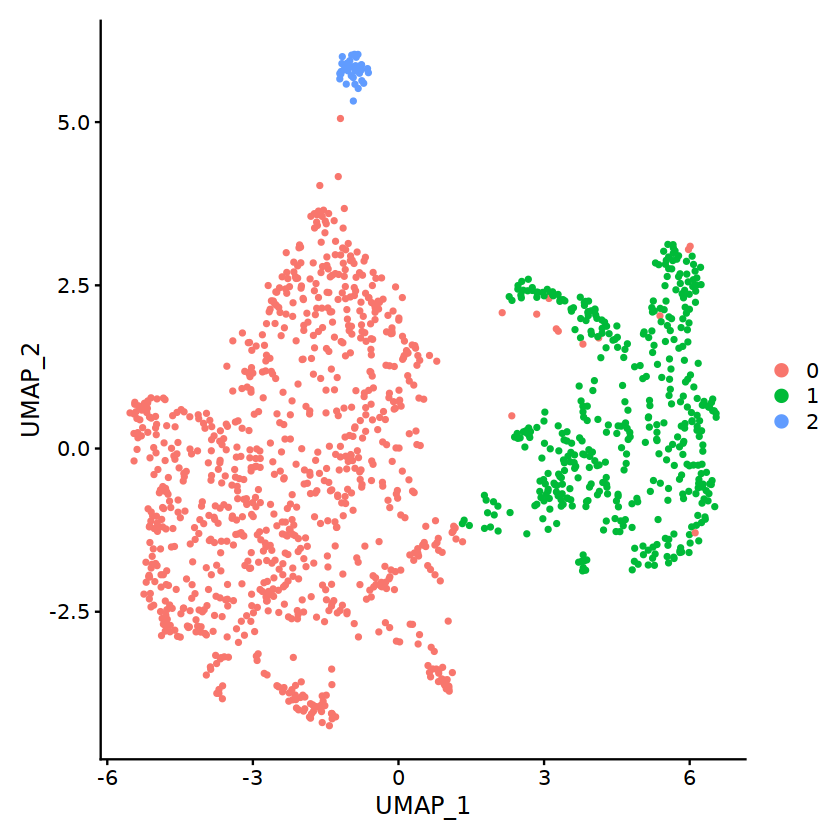

In [13]:
DimPlot(macs, reduction = "umap")

In [14]:
macs.markers <- FindAllMarkers(macs, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
macs.markers %>%
    group_by(cluster) %>%
    slice_max(n = 10, order_by = avg_log2FC)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2



p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster gene    
1   2.273377e-45 5.630548   0.426 0.064  2.810804e-41 0       APOBEC3A
2   6.454134e-09 5.544135   0.286 0.172  7.979891e-05 0       IFIT2   
3   2.799857e-08 5.427569   0.315 0.219  3.461743e-04 0       IFIT3   
4   1.192897e-31 5.170454   0.362 0.081  1.474898e-27 0       PLAC8   
5   5.419558e-16 4.556601   0.270 0.094  6.700741e-12 0       SDS     
6   9.727023e-07 4.321504   0.300 0.202  1.202649e-02 0       CDH23   
7   6.238011e-22 4.124373   0.265 0.051  7.712677e-18 0       MEFV    
8   1.055804e-21 4.013757   0.273 0.062  1.305396e-17 0       PLD4    
9   8.253850e-19 3.944978   0.582 0.479  1.020506e-14 0       GBP1    
10  2.422299e-12 3.871401   0.428 0.300  2.994931e-08 0       GBP5    
11 7.074649e-116 7.238331   0.526 0.021 8.747096e-112 1       MT1H    
12 5.533814e-137 6.988176   0.653 0.049 6.842008e-133 1       MT1G    
13  1.225315e-39 6.614168   0.290 0.045  1.514979e-35 1       CTSK    
14  3.622698e-51 6.436692   0.251 0.009  4.479103e-47 1       DKK2    
15  2.330572e-94 5.972427   0.425 0.010  2.881520e-90 1       SPARC   
16  1.479934e-87 5.951709   0.425 0.020  1.829791e-83 1       MT1M    
17  5.883786e-43 5.411376   0.262 0.026  7.274713e-39 1       TYMS    
18 2.179795e-137 4.638092   0.821 0.145 2.695098e-133 1       MT1X    
19  3.142701e-33 4.609761   0.280 0.059  3.885635e-29 1       KIAA0101
20  2.320020e-51 4.520024   0.262 0.013  2.868473e-47 1       GPR68   
21 6.682403e-189 9.186385   0.800 0.006 8.262122e-185 2       CLNK    
22 2.451508e-150 8.170922   0.714 0.008 3.031044e-146 2       ENPP1   
23  6.544510e-28 6.407105   0.314 0.018  8.091632e-24 2       TACSTD2 
24  1.250938e-62 6.308426   0.371 0.007  1.546659e-58 2       BIK     
25  8.377168e-73 6.247877   0.400 0.007  1.035753e-68 2       CLCN4   
26  6.176536e-16 6.217247   0.371 0.054  7.636669e-12 2       FCRL6   
27  6.871992e-60 6.178190   0.429 0.013  8.496531e-56 2       GCSAM   
28 3.137239e-117 6.054454   0.800 0.021 3.878882e-113 2       BTLA    
29  6.546862e-18 6.044983   0.914 0.402  8.094540e-14 2       SNX22   
30  2.778003e-62 6.011368   0.571 0.026  3.434723e-58 2       DBN1

In [15]:
macs.markers %>%
    group_by(cluster) %>%
    top_n(n = 10, wt = avg_log2FC) -> top10
DoHeatmap(macs, features = top10$gene) + NoLegend()

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1391
Number of edges: 47156

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8193
Number of communities: 9
Elapsed time: 0 seconds


cairo_pdf 
        2

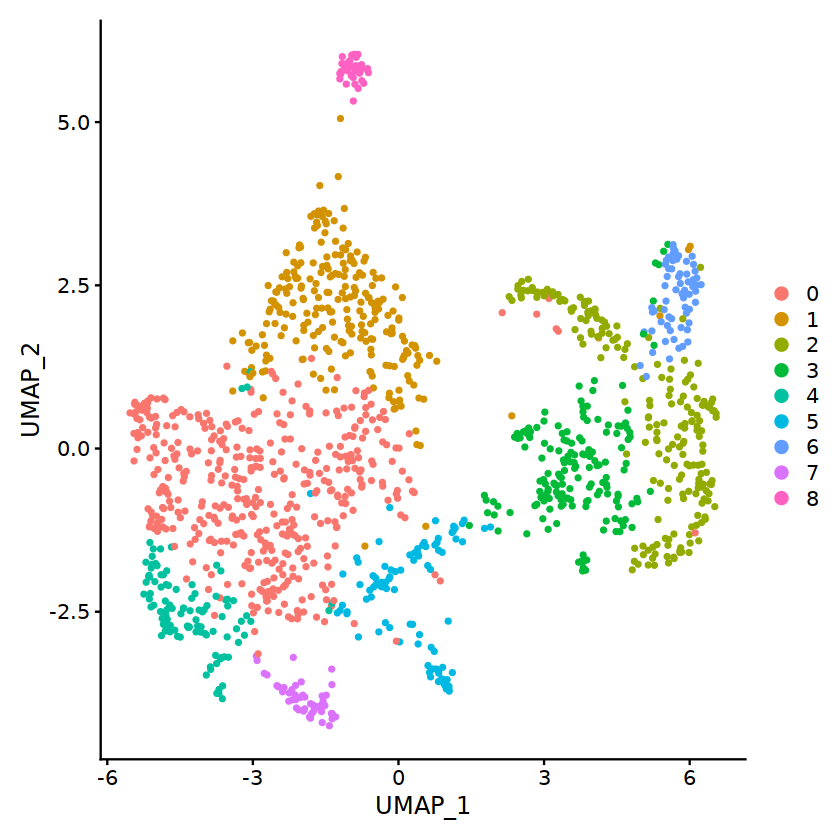

In [16]:
macs <- FindClusters(macs, resolution = 0.5)

DimPlot(macs, reduction = "umap")

pdf("/seq/hacohenlab1/arnav/olink_melanoma/paper1/macs-clusters-tsne.pdf")
DimPlot(macs, reduction = "umap")
dev.off()

In [17]:
macs.markers <- FindAllMarkers(macs, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
macs.markers %>%
    group_by(cluster) %>%
    slice_max(n = 10, order_by = avg_log2FC)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8



p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster gene    
1    4.179099e-89 4.226145   0.652 0.145  5.167039e-85 0       APOBEC3A
2    1.223916e-30 3.533104   0.452 0.161  1.513250e-26 0       APOBEC3B
3    6.343572e-19 3.454447   0.265 0.095  7.843192e-15 0       GPBAR1  
4    4.518557e-12 3.447490   0.343 0.204  5.586744e-08 0       IFIT2   
5    4.325403e-09 2.860474   0.362 0.247  5.347928e-05 0       IFIT3   
6    6.352765e-13 2.737049   0.300 0.146  7.854559e-09 0       OASL    
7    1.056354e-11 2.630628   0.620 0.534  1.306076e-07 0       NLRP3   
8    3.037777e-08 2.589696   0.286 0.165  3.755908e-04 0       LDLR    
9    8.400467e-22 2.566579   0.394 0.176  1.038634e-17 0       GCH1    
10   2.095454e-49 2.413330   0.710 0.353  2.590819e-45 0       LILRA5  
11   1.947964e-71 5.794518   0.384 0.027  2.408463e-67 1       FCER1A  
12   4.556920e-77 5.776283   0.392 0.024  5.634176e-73 1       SPIB    
13  2.674637e-108 5.500543   0.665 0.088 3.306922e-104 1       CD1C    
14   3.621760e-40 5.413787   0.273 0.031  4.477944e-36 1       LAMP3   
15   6.803961e-50 4.788936   0.404 0.068  8.412417e-46 1       CD1E    
16   1.179990e-42 4.227734   0.282 0.031  1.458940e-38 1       AFF3    
17   6.115437e-87 3.647980   0.800 0.229  7.561127e-83 1       CLEC10A 
18   4.004228e-59 3.280959   0.449 0.068  4.950828e-55 1       SLC38A1 
19   7.165269e-20 3.161540   0.318 0.100  8.859138e-16 1       RUNX2   
20   2.915421e-58 3.090519   0.473 0.081  3.604626e-54 1       CST7    
21   6.201312e-77 6.637080   0.320 0.007  7.667302e-73 2       CLLU1OS 
22   1.547129e-76 5.682070   0.379 0.019  1.912871e-72 2       SULT1C2 
23   4.117964e-41 5.387909   0.257 0.023  5.091451e-37 2       CYP27B1 
24   6.990318e-67 4.905051   0.340 0.018  8.642830e-63 2       NDP     
25   5.534282e-69 4.763754   0.388 0.029  6.842586e-65 2       SLC28A3 
26   1.410685e-62 4.538048   0.364 0.028  1.744171e-58 2       MSC     
27   4.587504e-82 4.128273   0.985 0.583  5.671989e-78 2       FBP1    
28   5.250337e-44 3.997688   0.257 0.019  6.491517e-40 2       FAIM2   
29   4.183001e-67 3.828237   0.490 0.063  5.171863e-63 2       AQP3    
30   4.887707e-53 3.688897   0.369 0.042  6.043161e-49 2       GPR68   
... ...           ...        ...   ...   ...           ...     ...     
61  1.186766e-139 8.155322   0.905 0.044 1.467318e-135 6       CCNA2   
62  4.275009e-161 8.019619   0.762 0.015 5.285621e-157 6       UBE2C   
63  2.596872e-151 7.782054   0.873 0.032 3.210772e-147 6       RRM2    
64  4.908097e-173 7.042054   0.730 0.009 6.068372e-169 6       CDCA3   
65  1.725357e-145 6.930050   0.635 0.009 2.133231e-141 6       KIF20A  
66  1.190395e-141 6.828873   0.778 0.024 1.471805e-137 6       TPX2    
67  1.552336e-138 6.770036   0.825 0.031 1.919308e-134 6       TOP2A   
68  1.655909e-136 6.763200   0.810 0.031 2.047366e-132 6       KIF11   
69  3.744386e-170 6.720268   0.794 0.015 4.629559e-166 6       CDCA5   
70  8.357452e-129 6.694232   0.952 0.059 1.033315e-124 6       TYMS    
71   1.879716e-70 7.133687   0.388 0.009  2.324081e-66 7       PCOLCE2 
72   8.637293e-16 4.923155   0.551 0.159  1.067915e-11 7       HS3ST1  
73   9.539533e-25 4.636387   1.000 0.671  1.179468e-20 7       CTSL    
74   3.659221e-31 4.592422   0.837 0.240  4.524261e-27 7       OLFML2B 
75   2.267221e-31 4.544599   0.490 0.059  2.803192e-27 7       ACKR3   
76   1.482291e-26 4.457872   1.000 0.639  1.832704e-22 7       CD163   
77   2.356079e-40 4.398049   0.408 0.028  2.913056e-36 7       EDNRB   
78   5.510094e-12 4.299824   0.367 0.088  6.812681e-08 7       CXCL1   
79   5.380864e-12 4.223781   0.388 0.099  6.652900e-08 7       CYP1B1  
80   2.826868e-18 4.116406   0.388 0.065  3.495140e-14 7       ANGPTL4 
81  6.682403e-189 9.186385   0.800 0.006 8.262122e-185 8       CLNK    
82  2.451508e-150 8.170922   0.714 0.008 3.031044e-146 8       ENPP1   
83   6.544510e-28 6.407105   0.314 0.018  8.091632e-24 8       TACSTD2 
84   1.250938e-62 6.308426   0.371 0.007  1.

In [18]:
write.csv(macs.markers, "/seq/hacohenlab1/arnav/olink_melanoma/paper1/marker-genes-macs-list.csv")

cairo_pdf 
        2

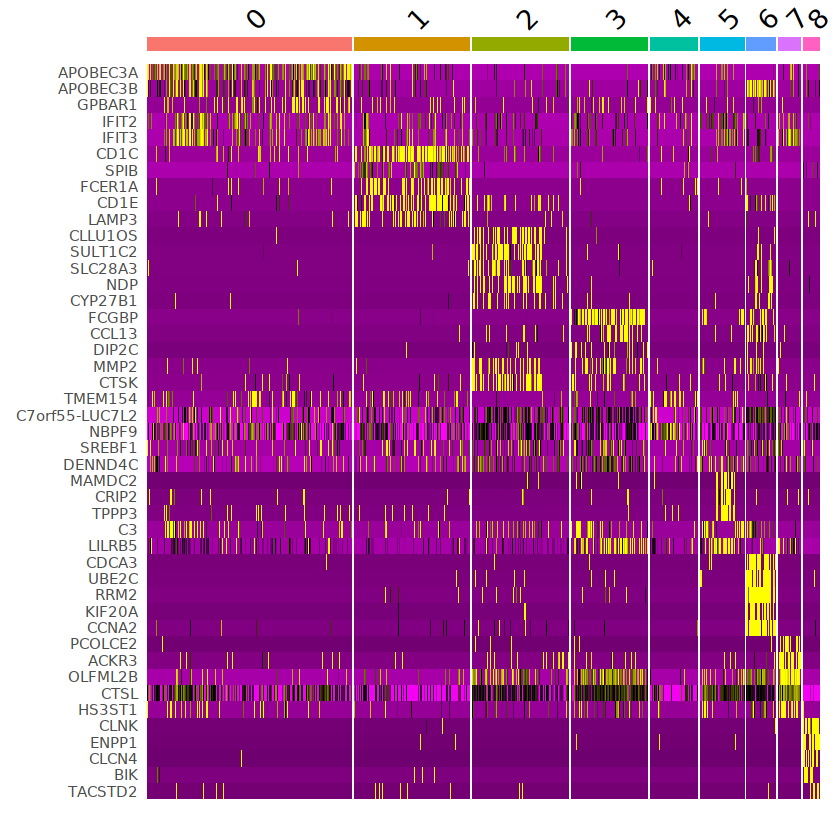

In [19]:
macs.markers %>%
    group_by(cluster) %>%
    top_n(n = 5, wt = avg_log2FC) -> top5
DoHeatmap(macs, features = top5$gene) + NoLegend()

pdf("/seq/hacohenlab1/arnav/olink_melanoma/paper1/marker-genes-macs-heatmap.pdf")
DoHeatmap(macs, features = top5$gene) 
DoHeatmap(macs, features = top5$gene) + NoLegend()
dev.off()

Warning message:
"The following features are not present in the object: EN-RAGE, CSCL13, Beta-NGF, BCAN, MUC-16, STC1, MIA, ADGRG1, OPN, GDF-15, NT-proBNP, KLK4, MK, HGB, vWF, ST2, MATN3, PRTN3, TNF-alpha, FGF-23, TFPI-2, IL-18R1, VWA1, OPG, CDH3, DRAXIN, WISP-1, TNFRSF19, SCARF2, EDA2R, CLM-1, U-PAR, TNF-R2, IL-18BP, GFR-alpha-1, N2DL-2, TNF-R1, FGF-21, FABP4, not searching for symbol synonyms"
Warning message in DoHeatmap(macs, features = genes, size = 4, angle = 90):
"The following features were omitted as they were not found in the scale.data slot for the RNA assay: FABP4, FGF-21, TNF-R1, N2DL-2, GFR-alpha-1, IL-18BP, TNF-R2, U-PAR, CLM-1, EDA2R, SCARF2, TNFRSF19, WISP-1, DRAXIN, CDH3, OPG, VWA1, IL-18R1, TFPI-2, FGF-23, TNF-alpha, PRTN3, MATN3, ST2, vWF, HGB, MK, KLK4, NT-proBNP, GDF-15, OPN, ADGRG1, MIA, STC1, MUC-16, BCAN, Beta-NGF, CSCL13, EN-RAGE"
Warning message in DoHeatmap(macs, features = genes, size = 4, angle = 90):
"The following features were omitted as they were not f

cairo_pdf 
        2

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



cairo_pdf 
        2

Picking joint bandwidth of 0.173



Picking joint bandwidth of 0.173



cairo_pdf 
        2

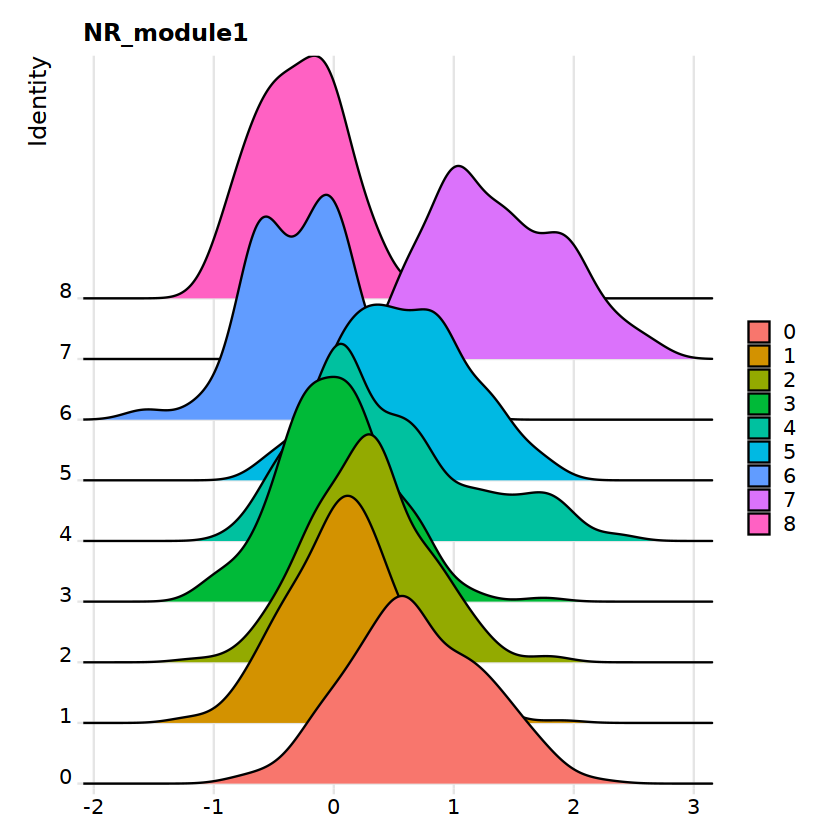

In [22]:
macs <- AddModuleScore(macs, NR.module, name='NR_module')

genes <- c("VIM", "ABL1", "S100A11", "EGLN1", "DFFA", "EN-RAGE", "TNFSF14", "OSM", "NAMPT", "LIF", "CSCL13", "IL10", "Beta-NGF", 
               "BRK1", "BCAN", "MUC-16", "STC1", "MIA", "ADGRG1", "IL8", "DCTPP1", "OPN", "NRP2", "GDF-15", "IGF1R",
               "NT-proBNP", "KLK4", "IL6", "MK", "HGB", "TNC", "vWF", "AREG", "ST2", "MATN3", "CCL20", "PRTN3", 
               "CLEC4D", "TNF-alpha", "FGF-23", "TFPI-2", "LTBP2", "TIMP1", "IL-18R1", "VWA1", "OPG", "CDH3", "DRAXIN",
               "WISP-1", "PGF", "EPHA2", "TNFRSF19", "SCARF2", "EDA2R", "TNFRSF6B", "CLM-1", "CD300E", "U-PAR", 
               "TNF-R2", "IL-18BP", "SIGLEC1", "GFR-alpha-1", "SCARB2", "N2DL-2", "LTBR", "TNFRSF14", "TNF-R1",
               "FGF-21", "CSTB", "FABP4", "CKAP4", "VEGFA")

DoHeatmap(macs, features=genes, size = 4, angle = 90)

pdf("/seq/hacohenlab1/arnav/olink_melanoma/paper1/NR-module_single-cell-macs-heatmap.pdf")
DoHeatmap(macs, features=genes, size = 4, angle = 90)
dev.off()

FeaturePlot(macs, features = "NR_module1") +
            scale_colour_gradientn(colours = rev(brewer.pal(n = 11, name = "RdBu")))

pdf("/seq/hacohenlab1/arnav/olink_melanoma/paper1/NR-module_single-cell-macs-tsne.pdf")
FeaturePlot(macs, features = "NR_module1") +
            scale_colour_gradientn(colours = rev(brewer.pal(n = 11, name = "RdBu")))
dev.off()

RidgePlot(macs, features="NR_module1")

pdf("/seq/hacohenlab1/arnav/olink_melanoma/paper1/NR-module_single-cell-macs-ridgeplot.pdf")
RidgePlot(macs, features="NR_module1")
dev.off()

In [44]:
FeaturePlot(macs, features = "SPP1") +
            scale_colour_gradientn(colours = rev(brewer.pal(n = 11, name = "RdBu")))

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



In [16]:
saveRDS(macs, file="/seq/hacohenlab1/arnav/olink_melanoma/paper1/macs_cells.rds")

### Exploration of tumor cell population

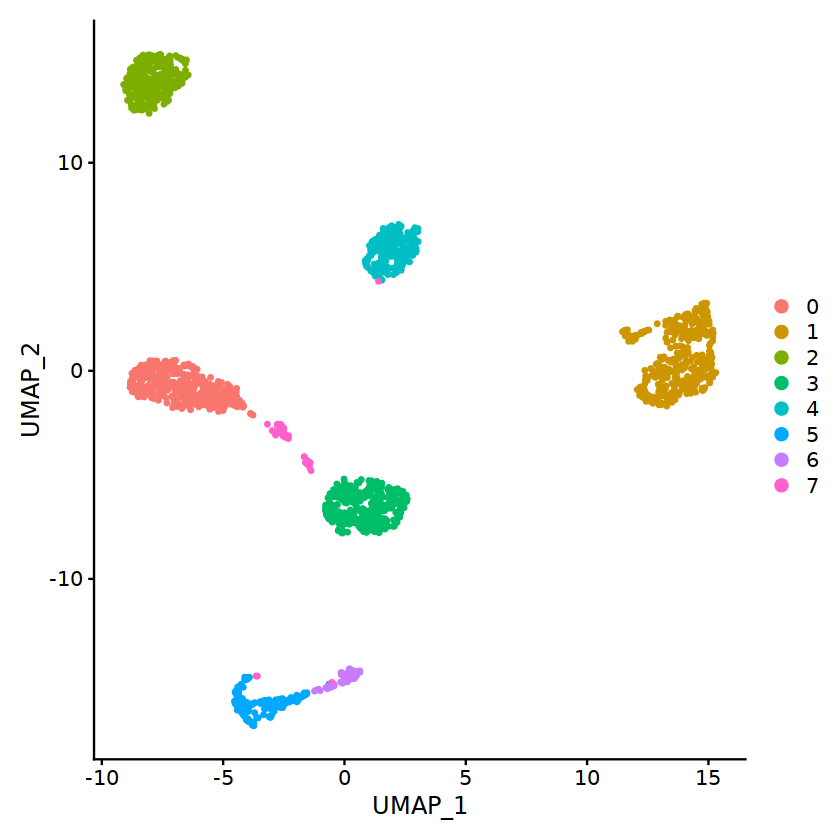

In [195]:
DimPlot(tumor, reduction = "umap")

In [196]:
tumor <- AddModuleScore(tumor, NR.module, name='NR_module')

Warning message:
"The following features are not present in the object: EN-RAGE, CSCL13, Beta-NGF, MUC-16, ADGRG1, OPN, GDF-15, NT-proBNP, MK, HGB, vWF, ST2, TNF-alpha, FGF-23, TFPI-2, IL-18R1, OPG, WISP-1, CLM-1, U-PAR, TNF-R2, IL-18BP, GFR-alpha-1, N2DL-2, TNF-R1, FGF-21, not searching for symbol synonyms"


Warning message in DoHeatmap(tumor, features = genes, group.by = "sample.ident", :
"The following features were omitted as they were not found in the scale.data slot for the RNA assay: FGF-21, TNF-R1, N2DL-2, GFR-alpha-1, IL-18BP, TNF-R2, U-PAR, CLM-1, WISP-1, OPG, IL-18R1, TFPI-2, FGF-23, TNF-alpha, ST2, vWF, HGB, MK, NT-proBNP, GDF-15, OPN, ADGRG1, MUC-16, Beta-NGF, CSCL13, EN-RAGE"
Warning message in DoHeatmap(tumor, features = genes, group.by = "sample.ident", :
"The following features were omitted as they were not found in the scale.data slot for the RNA assay: FGF-21, TNF-R1, N2DL-2, GFR-alpha-1, IL-18BP, TNF-R2, U-PAR, CLM-1, WISP-1, OPG, IL-18R1, TFPI-2, FGF-23, TNF-alpha, ST2, vWF, HGB, MK, NT-proBNP, GDF-15, OPN, ADGRG1, MUC-16, Beta-NGF, CSCL13, EN-RAGE"


cairo_pdf 
        2

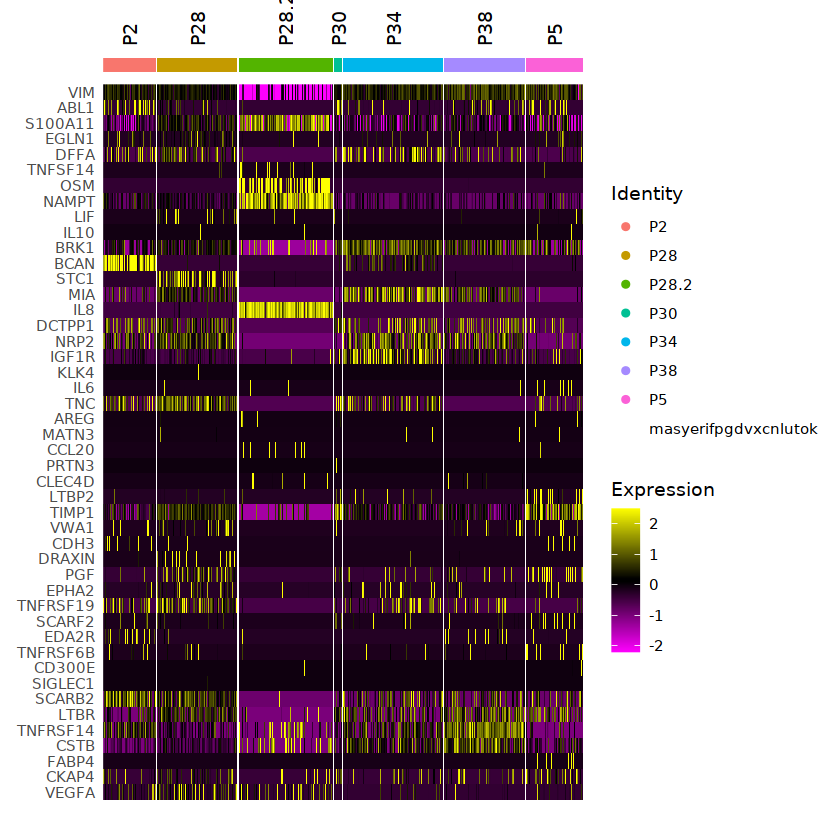

In [197]:
DoHeatmap(tumor, features=genes, group.by="sample.ident", size = 4, angle = 90)

pdf("/seq/hacohenlab1/arnav/olink_melanoma/paper1/NR-module_single-cell-tumor-heatmap.pdf")
DoHeatmap(tumor, features=genes, group.by="sample.ident", size = 4, angle = 90)
dev.off()

Warning message in FetchData(object = object, vars = features, cells = cells):
"The following requested variables were not found (10 out of 26 shown): EN-RAGE, CSCL13, Beta-NGF, MUC-16, ADGRG1, OPN, GDF-15, NT-proBNP, MK, HGB"
Warning message in FetchData(object = object, vars = features, cells = cells):
"The following requested variables were not found (10 out of 26 shown): EN-RAGE, CSCL13, Beta-NGF, MUC-16, ADGRG1, OPN, GDF-15, NT-proBNP, MK, HGB"


cairo_pdf 
        2

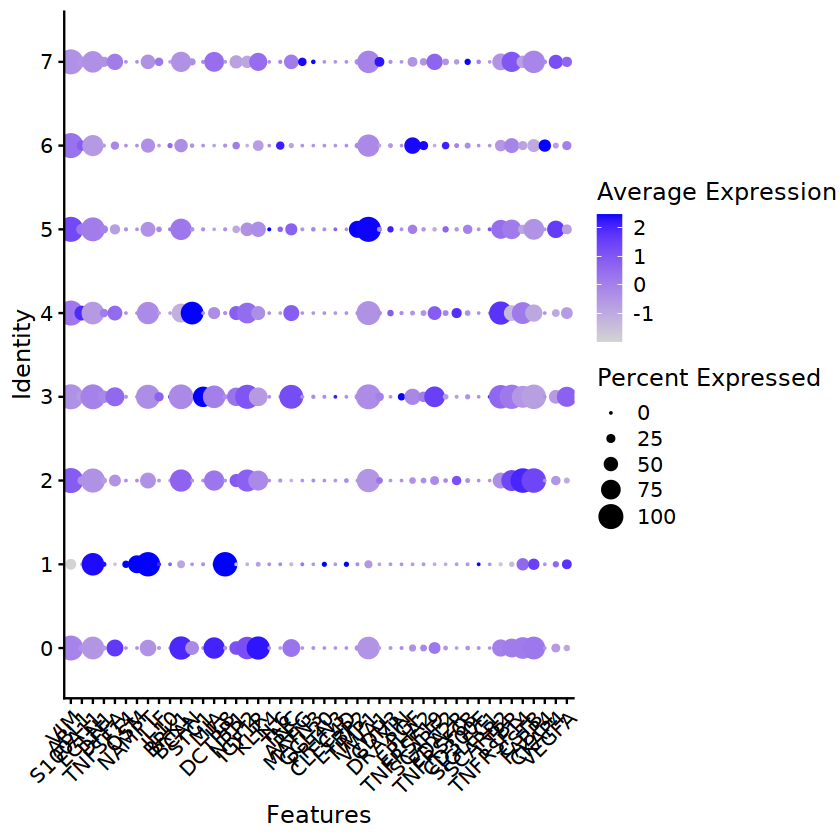

In [198]:
DotPlot(tumor, features=genes) + RotatedAxis()

pdf("/seq/hacohenlab1/arnav/olink_melanoma/paper1/NR-module_single-cell-tumor-dotplot.pdf")
DotPlot(tumor, features=genes) + RotatedAxis()
dev.off()

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



cairo_pdf 
        2

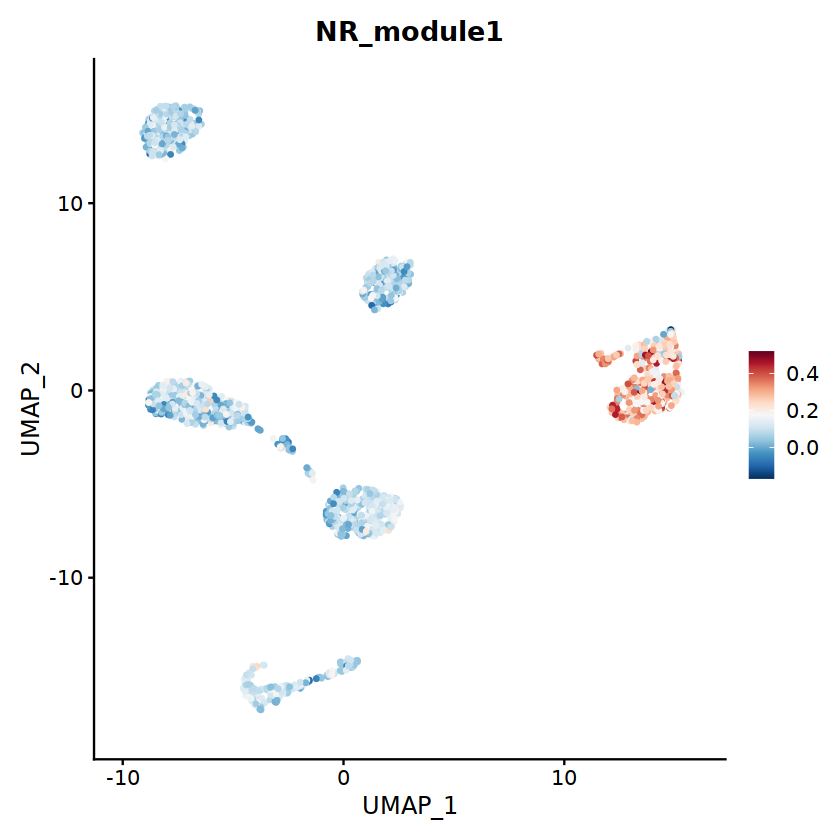

In [199]:
FeaturePlot(tumor, features = "NR_module1") +
            scale_colour_gradientn(colours = rev(brewer.pal(n = 11, name = "RdBu")))

pdf("/seq/hacohenlab1/arnav/olink_melanoma/paper1/NR-module_single-cell-tumor-tsne.pdf")
FeaturePlot(tumor, features = "NR_module1") +
            scale_colour_gradientn(colours = rev(brewer.pal(n = 11, name = "RdBu")))
dev.off()

## Next lets look at the Regev et al dataset

In [53]:
raw_counts <- read.csv("/seq/hacohenlab1/arnav/olink_melanoma/paper1/single-cell-data/regev-data/tpm.csv")

In [54]:
rownames(raw_counts) <- raw_counts$X
raw_counts <- raw_counts %>% select(-X)

In [55]:
annotations <- read.csv("/seq/hacohenlab1/arnav/olink_melanoma/paper1/single-cell-data/regev-data/cell.annotations.csv")

In [56]:
rownames(annotations) <- annotations$cells
annotations <- annotations %>% select(-cells)

In [57]:
regev_data <- CreateSeuratObject(counts = raw_counts, meta.data = annotations, min.cells = 3, min.genes = 200)

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"


In [58]:
regev_data <- FindVariableFeatures(regev_data, selection.method = "vst", nfeatures = 4000)

In [59]:
all.genes <- rownames(regev_data)
regev_data <- ScaleData(regev_data, features = all.genes)

Centering and scaling data matrix



In [60]:
regev_data_tumor <- subset(x = regev_data, subset = cell.types == "Mal")

In [61]:
regev_data_normal <- subset(x = regev_data, subset = cell.types != "Mal")

#### Analyze immune cells first

In [25]:
regev_data_normal <- RunPCA(regev_data_normal, features = VariableFeatures(object = regev_data_normal))

Warning message in PrepDR(object = object, features = features, verbose = verbose):
"The following 4 features requested have zero variance (running reduction without them): MIR3189, SNORD105B, CLDN17, TTTY6"
PC_ 1 
Positive:  CST3, TMEM176B, GRN, PLXDC2, CD14, CSF1R, GSN, TGFBI, IFITM3, LILRB4 
	   CTSL1, TMEM176A, NPC2, GLUL, IGSF6, SERPING1, FCGRT, HCK, CD163, CPVL 
	   PLAUR, TIMP1, FCGR1A, RNF130, FCER1G, SERPINA1, FCGR2A, C1QA, PLBD1, VSIG4 
Negative:  PTPRCAP, CCL5, CD3D, CD2, PTPRC, LCK, CXCR4, IL32, CD52, CD69 
	   CORO1A, ZAP70, IL2RG, TBC1D10C, KLRK1, ACAP1, CST7, RAC2, SEPT1, CD8A 
	   GZMA, LBH, SPOCK2, CD27, NKG7, DENND2D, PRKCH, IL2RB, GZMK, TRAF3IP3 
PC_ 2 
Positive:  CSF1R, HCK, IGSF6, TYROBP, LILRB2, LILRB4, CD163, FCGR1A, AIF1, CD14 
	   PILRA, FCER1G, CYBB, NCF2, FPR1, MNDA, VSIG4, C1QA, MPEG1, C1QC 
	   MS4A6A, C3AR1, MS4A4A, TLR2, FCGR3A, CSF3R, FPR3, SLC7A7, FAM26F, LST1 
Negative:  SPARC, CNN3, CTTN, FSTL1, NNMT, BGN, CAV1, PRSS23, CTHRC1, IGFBP7 
	   COL1A1, PPI

In [26]:
print(regev_data_normal[["pca"]], dims = 1:5, nfeatures = 5)

PC_ 1 
Positive:  CST3, TMEM176B, GRN, PLXDC2, CD14 
Negative:  PTPRCAP, CCL5, CD3D, CD2, PTPRC 
PC_ 2 
Positive:  CSF1R, HCK, IGSF6, TYROBP, LILRB2 
Negative:  SPARC, CNN3, CTTN, FSTL1, NNMT 
PC_ 3 
Positive:  NKG7, PRF1, CST7, CD8A, IL32 
Negative:  BANK1, MS4A1, CD19, CD79A, BCL11A 
PC_ 4 
Positive:  CD79A, MS4A1, CD19, CD22, BANK1 
Negative:  THY1, EFEMP1, COL1A1, DCN, LUM 
PC_ 5 
Positive:  PRAME, S100B, PMEL, TYR, MIA 
Negative:  THY1, DCN, EFEMP1, COL1A1, CDH11 


In [27]:
VizDimLoadings(regev_data_normal, dims = 1:2, reduction = "pca")

In [28]:
DimPlot(regev_data_normal, reduction = "pca")

In [29]:
regev_data_normal <- JackStraw(regev_data_normal, num.replicate = 100)
regev_data_normal <- ScoreJackStraw(regev_data_normal, dims = 1:20)

In [30]:
regev_data_normal <- FindNeighbors(regev_data_normal, dims = 1:10)
regev_data_normal <- FindClusters(regev_data_normal, resolution = 0.5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 5168
Number of edges: 163338

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8915
Number of communities: 11
Elapsed time: 0 seconds


In [31]:
regev_data_normal <- RunUMAP(regev_data_normal, dims = 1:10)

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
00:07:46 UMAP embedding parameters a = 0.9922 b = 1.112

00:07:46 Read 5168 rows and found 10 numeric columns

00:07:46 Using Annoy for neighbor search, n_neighbors = 30

00:07:46 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

00:07:48 Writing NN index file to temp file /tmp/27292166.1.interactive/Rtmpxi8cnM/file23545e205c24

00:07:48 Searching Annoy index using 1 thread, search_k = 3000

00:07:50 Annoy recall = 100%

00:07:51 Commencing smooth kNN distance calibration using 1 thread

00

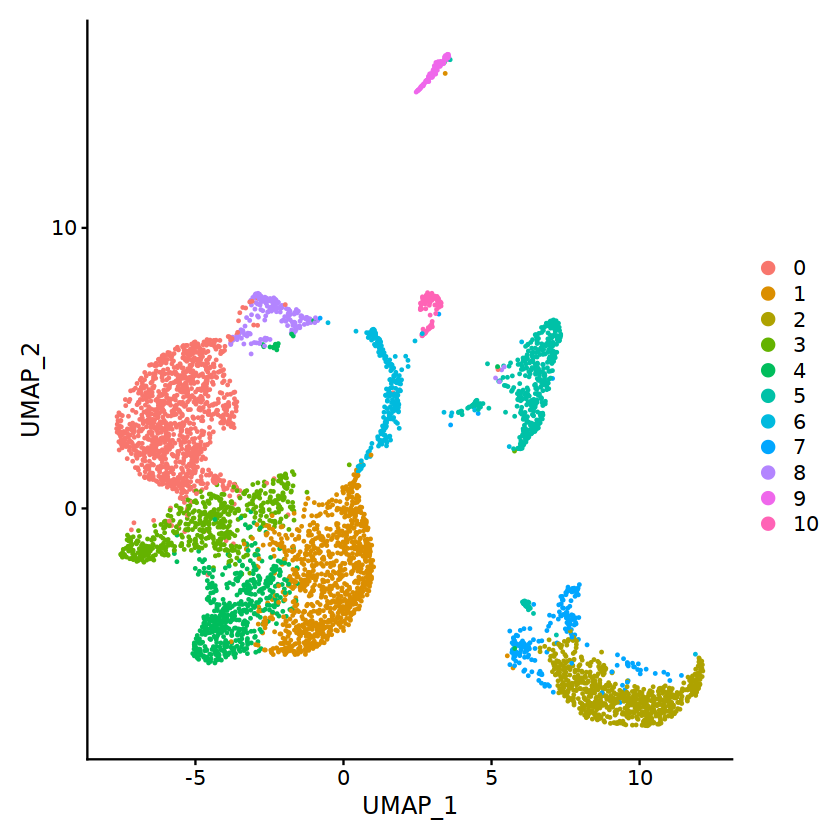

In [32]:
DimPlot(regev_data_normal, reduction = "umap")

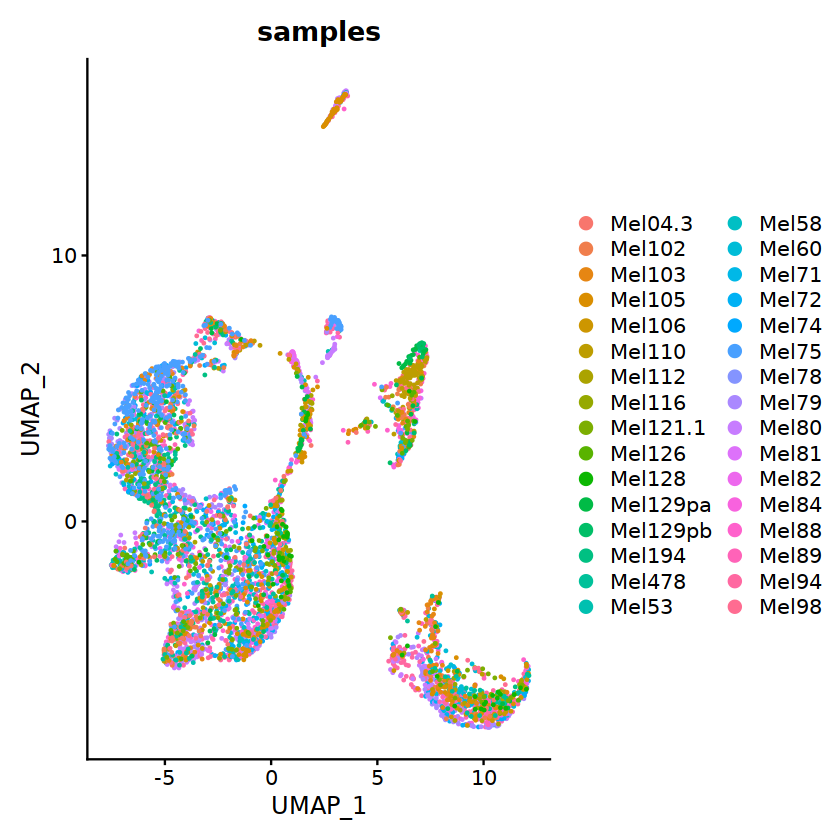

In [33]:
DimPlot(regev_data_normal, reduction = "umap", group.by="samples")

cairo_pdf 
        2

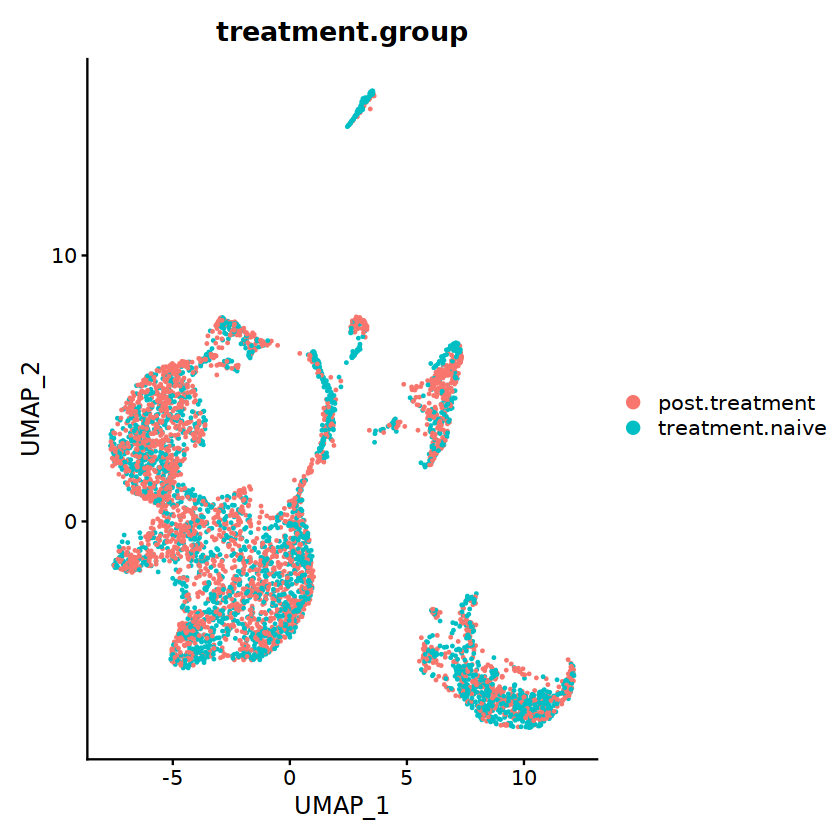

In [34]:
DimPlot(regev_data_normal, reduction = "umap", group.by="treatment.group")

pdf("/seq/hacohenlab1/arnav/olink_melanoma/paper1/single-cell-Regev-immune-treatmentgroup-tsne.pdf")
DimPlot(regev_data_normal, reduction = "umap", group.by="treatment.group")
dev.off()

In [35]:
DimPlot(regev_data_normal, reduction = "umap", group.by="cell.types")

pdf("/seq/hacohenlab1/arnav/olink_melanoma/paper1/single-cell-Regev-immune--celltypes-tsne.pdf")
DimPlot(regev_data_normal, reduction = "umap", group.by="cell.types")
dev.off()

cairo_pdf 
        2

In [36]:
NR.module_regev <- list(c("VIM", "ABL1", "S100A11", "EGLN1", "DFFA", "ENRAGE", "TNFSF14", "OSM", "NAMPT", "LIF", "CSCL13", "IL10", "BetaNGF", 
               "BRK1", "BCAN", "MUC16", "STC1", "MIA", "ADGRG1", "IL8", "DCTPP1", "OPN", "NRP2", "GDF15", "IGF1R",
               "NTproBNP", "KLK4", "IL6", "MK", "HGB", "TNC", "vWF", "AREG", "ST2", "MATN3", "CCL20", "PRTN3", 
               "CLEC4D", "TNFalpha", "FGF23", "TFPI2", "LTBP2", "TIMP1", "IL18R1", "VWA1", "OPG", "CDH3", "DRAXIN",
               "WISP1", "PGF", "EPHA2", "TNFRSF19", "SCARF2", "EDA2R", "TNFRSF6B", "CLM1", "CD300E", "UPAR", 
               "TNFR2", "IL18BP", "SIGLEC1", "GFRalpha1", "SCARB2", "N2DL2", "LTBR", "TNFRSF14", "TNFR1",
               "FGF21", "CSTB", "FABP4", "CKAP4", "VEGFA"))

regev_data_normal <- AddModuleScore(regev_data_normal, NR.module_regev, name='NR_module')

Warning message:
"The following features are not present in the object: ENRAGE, CSCL13, BetaNGF, ADGRG1, OPN, NTproBNP, MK, HGB, vWF, ST2, TNFalpha, OPG, CLM1, UPAR, TNFR2, GFRalpha1, N2DL2, TNFR1, FGF21, not searching for symbol synonyms"


Warning message in DoHeatmap(regev_data_normal, features = genes, group.by = "cell.types", :
"The following features were omitted as they were not found in the scale.data slot for the RNA assay: FGF21, TNFR1, N2DL2, GFRalpha1, TNFR2, UPAR, CLM1, OPG, TNFalpha, ST2, vWF, HGB, MK, NTproBNP, OPN, ADGRG1, BetaNGF, CSCL13, ENRAGE"
Warning message in DoHeatmap(regev_data_normal, features = genes, group.by = "cell.types", :
"The following features were omitted as they were not found in the scale.data slot for the RNA assay: FGF21, TNFR1, N2DL2, GFRalpha1, TNFR2, UPAR, CLM1, OPG, TNFalpha, ST2, vWF, HGB, MK, NTproBNP, OPN, ADGRG1, BetaNGF, CSCL13, ENRAGE"


cairo_pdf 
        2

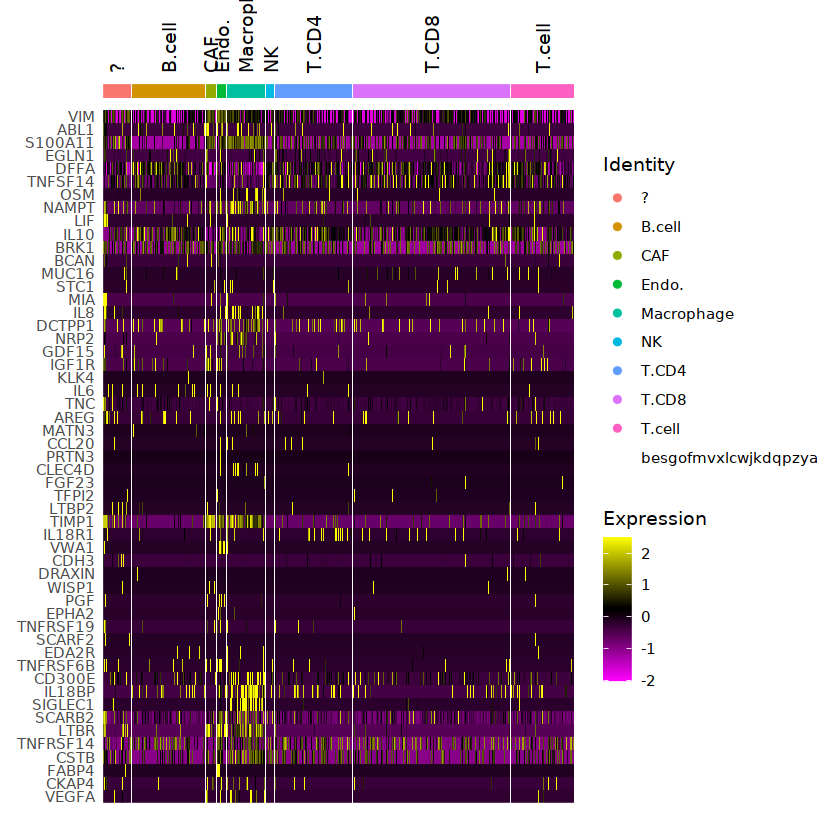

In [37]:
genes <- c("VIM", "ABL1", "S100A11", "EGLN1", "DFFA", "ENRAGE", "TNFSF14", "OSM", "NAMPT", "LIF", "CSCL13", "IL10", "BetaNGF", 
               "BRK1", "BCAN", "MUC16", "STC1", "MIA", "ADGRG1", "IL8", "DCTPP1", "OPN", "NRP2", "GDF15", "IGF1R",
               "NTproBNP", "KLK4", "IL6", "MK", "HGB", "TNC", "vWF", "AREG", "ST2", "MATN3", "CCL20", "PRTN3", 
               "CLEC4D", "TNFalpha", "FGF23", "TFPI2", "LTBP2", "TIMP1", "IL18R1", "VWA1", "OPG", "CDH3", "DRAXIN",
               "WISP1", "PGF", "EPHA2", "TNFRSF19", "SCARF2", "EDA2R", "TNFRSF6B", "CLM1", "CD300E", "UPAR", 
               "TNFR2", "IL18BP", "SIGLEC1", "GFRalpha1", "SCARB2", "N2DL2", "LTBR", "TNFRSF14", "TNFR1",
               "FGF21", "CSTB", "FABP4", "CKAP4", "VEGFA")

DoHeatmap(regev_data_normal, features=genes, group.by="cell.types", size = 4, angle = 90)

pdf("/seq/hacohenlab1/arnav/olink_melanoma/paper1/NR-module_single-cell-Regev-immune-heatmap.pdf")
DoHeatmap(regev_data_normal, features=genes, group.by="cell.types", size = 4, angle = 90)
dev.off()

In [38]:
FeaturePlot(regev_data_normal, features = "NR_module1") +
            scale_colour_gradientn(colours = rev(brewer.pal(n = 11, name = "RdBu")))

pdf("/seq/hacohenlab1/arnav/olink_melanoma/paper1/NR-module_single-cell-Regev-immune-tsne.pdf")
FeaturePlot(regev_data_normal, features = "NR_module1") +
            scale_colour_gradientn(colours = rev(brewer.pal(n = 11, name = "RdBu")))
dev.off()

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



cairo_pdf 
        2

#### Next analyze tumor cells

In [39]:
regev_data_tumor <- RunPCA(regev_data_tumor, features = VariableFeatures(object = regev_data_tumor))

Warning message in PrepDR(object = object, features = features, verbose = verbose):
"The following 121 features requested have zero variance (running reduction without them): DEFB4A, SNORD49B, PPP1R2P9, MIR3622B, MIR302C, MIR4648, IFNA21, MIR367, MIR4295, KRTAP19-2, RNY5, MIR4474, MIR320E, MIR663A, SCARNA11, MIR758, MIR618, MIR1276, MIR302B, MIR4784, MIR5685, MIR1288, KRTAP19-8, MIR4473, IL17C, IFNA6, MIR449A, MIR3128, MIR885, MIR1245B, SNORA38B, MIR1245A, MIR24-2, MIR4305, MIR103B2, MIR194-2, MIR4518, OR8D4, MIR29B2, MIR3615, MIR4453, NPBWR1, MIR4722, LOC728716, MIR4650-2, MIR4650-1, SNAR-A2, RNU5F-1, SNORD56B, MIR1537, SNORD113-1, MIR3607, MIR4435-2, MIR3945, SNORD82, SNORD116-27, MIR4632, SNORA11C, S100A7L2, SNAR-H, SNORD115-5, MIR4480, HIST1H2APS1, MIR4469, MIR643, MIR4519, MIRLET7G, MIR514A1, SNORD115-17, SNORD115-18, SNORD115-19, IFNA22P, MIR5690, MIR339, MIR1256, MIR601, MIR4681, MIR5692A1, RIPPLY1, MIR4284, DPYD-AS1, MIR548B, MIR934, SNORD18B, MIR1322, C2orf57, RNASE12, MIR378E

In [40]:
print(regev_data_tumor[["pca"]], dims = 1:5, nfeatures = 5)

PC_ 1 
Positive:  PRAME, PLP1, TYR, TMEM98, SPARC 
Negative:  TMSB4X, LAPTM5, PTPRC, ARHGDIB, CORO1A 
PC_ 2 
Positive:  CDH19, APOD, APOC2, MIA, TYR 
Negative:  GAGE2B, GAGE12E, GAGE12C, GAGE2E, GAGE12H 
PC_ 3 
Positive:  SERPINA3, TM4SF1, PAGE5, TRIML2, MAEL 
Negative:  DCT, TYRP1, BCAN, SNAI2, TRPM1 
PC_ 4 
Positive:  MAEL, TRIML2, APOC2, RDH5, GAGE12E 
Negative:  SAA1, HAPLN1, C2orf82, TF, TNFRSF11B 
PC_ 5 
Positive:  SFRP1, MAGEA4, C2orf82, ERRFI1, SAA1 
Negative:  HLA-B, KIT, HLA-C, MMP8, RCN3 


In [41]:
VizDimLoadings(regev_data_tumor, dims = 1:2, reduction = "pca")

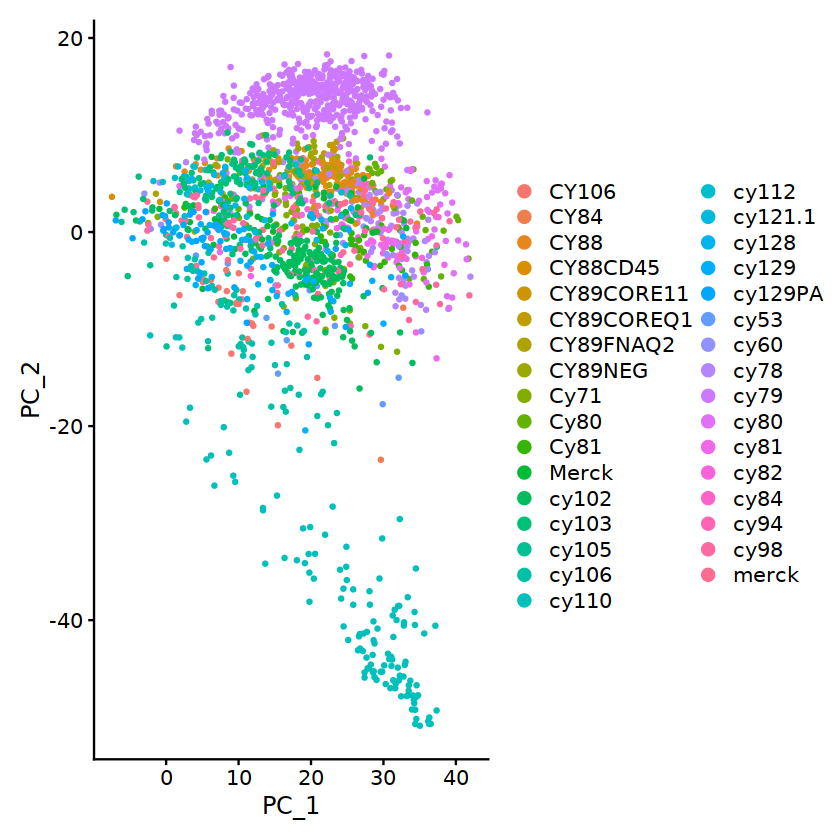

In [42]:
DimPlot(regev_data_tumor, reduction = "pca")

In [43]:
regev_data_tumor <- JackStraw(regev_data_tumor, num.replicate = 100)
regev_data_tumor <- ScoreJackStraw(regev_data_tumor, dims = 1:20)

In [44]:
regev_data_tumor <- FindNeighbors(regev_data_tumor, dims = 1:10)
regev_data_tumor <- FindClusters(regev_data_tumor, resolution = 0.5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2018
Number of edges: 56219

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9125
Number of communities: 14
Elapsed time: 0 seconds


In [45]:
regev_data_tumor <- RunUMAP(regev_data_tumor, dims = 1:10)

00:11:22 UMAP embedding parameters a = 0.9922 b = 1.112

00:11:22 Read 2018 rows and found 10 numeric columns

00:11:22 Using Annoy for neighbor search, n_neighbors = 30

00:11:22 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

00:11:23 Writing NN index file to temp file /tmp/27292166.1.interactive/Rtmpxi8cnM/file23542a488c67

00:11:23 Searching Annoy index using 1 thread, search_k = 3000

00:11:24 Annoy recall = 100%

00:11:25 Commencing smooth kNN distance calibration using 1 thread

00:11:27 Initializing from normalized Laplacian + noise

00:11:27 Commencing optimization for 500 epochs, with 78690 positive edges

00:11:36 Optimization finished



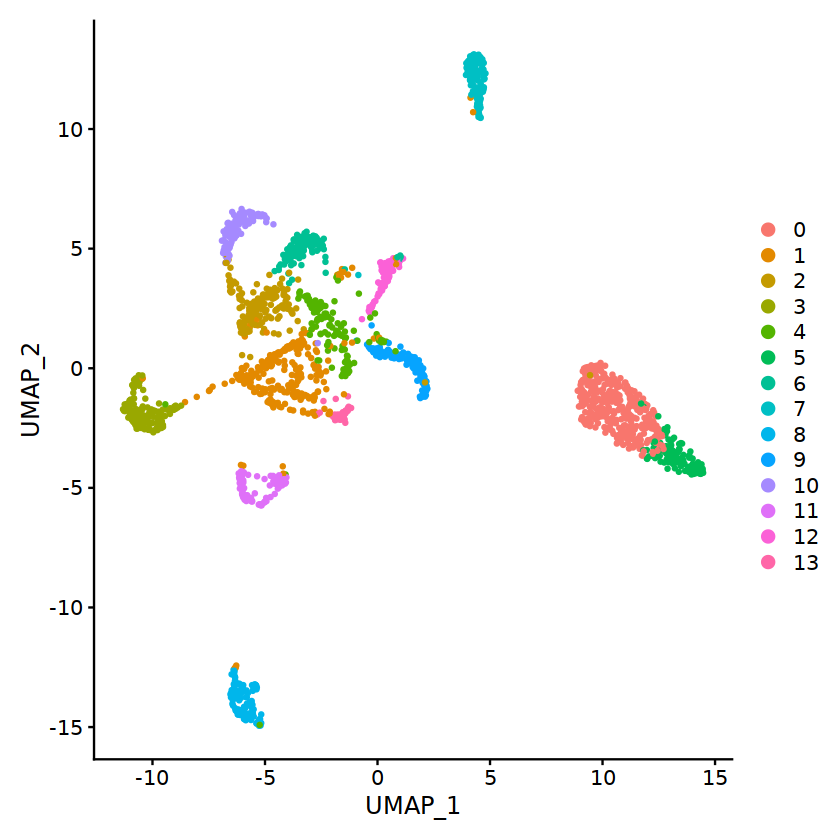

In [46]:
DimPlot(regev_data_tumor, reduction = "umap")

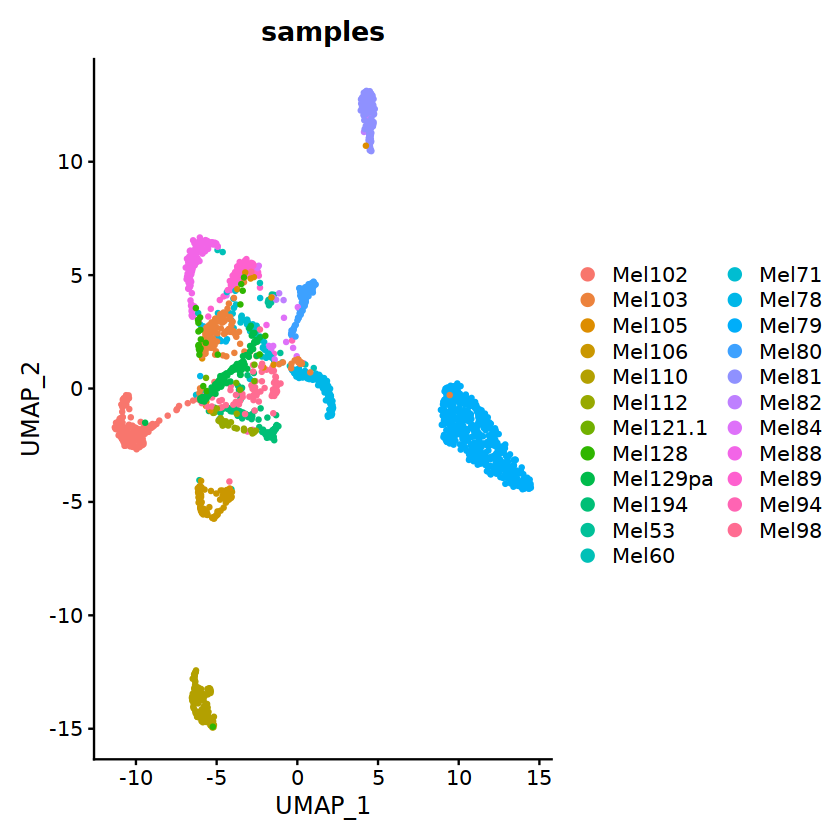

In [47]:
DimPlot(regev_data_tumor, reduction = "umap", group.by="samples")

cairo_pdf 
        2

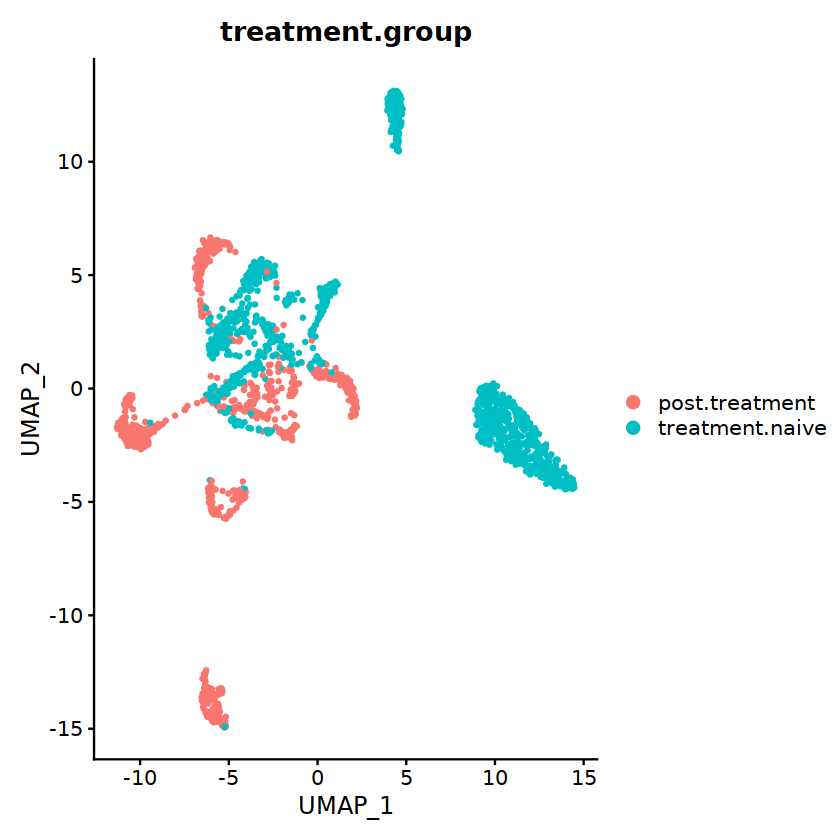

In [48]:
DimPlot(regev_data_tumor, reduction = "umap", group.by="treatment.group")

pdf("/seq/hacohenlab1/arnav/olink_melanoma/paper1/single-cell-Regev-tumor-treatmentgroup-tsne.pdf")
DimPlot(regev_data_tumor, reduction = "umap", group.by="treatment.group")
dev.off()

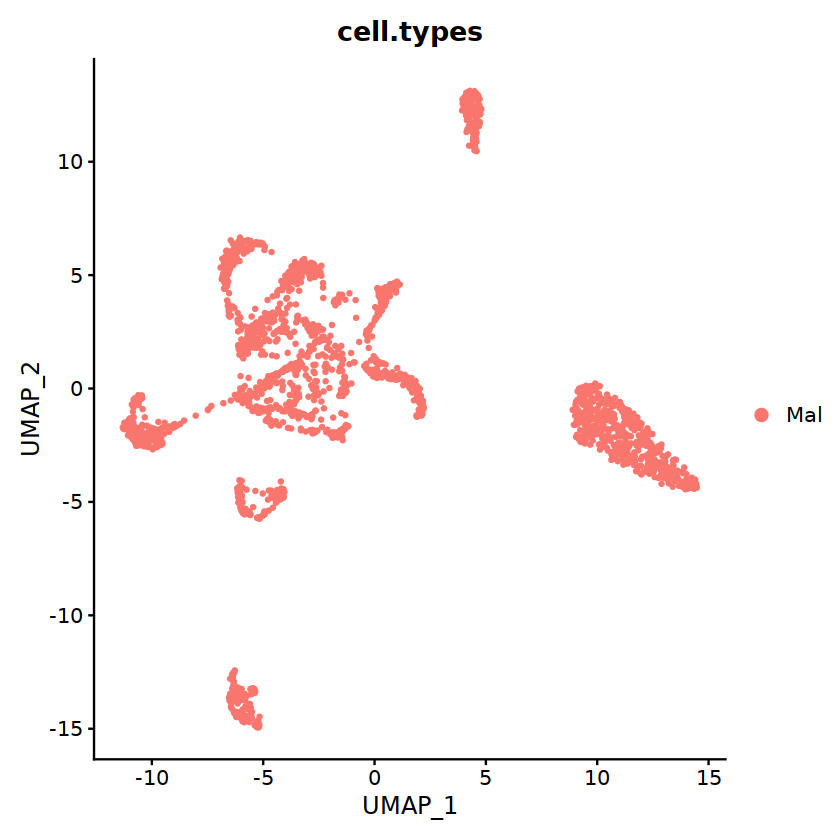

In [49]:
DimPlot(regev_data_tumor, reduction = "umap", group.by="cell.types")

In [50]:
regev_data_tumor <- AddModuleScore(regev_data_tumor, NR.module_regev, name='NR_module')

Warning message:
"The following features are not present in the object: ENRAGE, CSCL13, BetaNGF, ADGRG1, OPN, NTproBNP, MK, HGB, vWF, ST2, TNFalpha, OPG, CLM1, UPAR, TNFR2, GFRalpha1, N2DL2, TNFR1, FGF21, not searching for symbol synonyms"


In [51]:
DoHeatmap(regev_data_tumor, features=genes, group.by="cell.types", size = 4, angle = 90)

pdf("/seq/hacohenlab1/arnav/olink_melanoma/paper1/NR-module_single-cell-Regev-tumor-heatmap.pdf")
DoHeatmap(regev_data_tumor, features=genes, group.by="cell.types", size = 4, angle = 90)
dev.off()

Warning message in DoHeatmap(regev_data_tumor, features = genes, group.by = "cell.types", :
"The following features were omitted as they were not found in the scale.data slot for the RNA assay: FGF21, TNFR1, N2DL2, GFRalpha1, TNFR2, UPAR, CLM1, OPG, TNFalpha, ST2, vWF, HGB, MK, NTproBNP, OPN, ADGRG1, BetaNGF, CSCL13, ENRAGE"
Warning message in DoHeatmap(regev_data_tumor, features = genes, group.by = "cell.types", :
"The following features were omitted as they were not found in the scale.data slot for the RNA assay: FGF21, TNFR1, N2DL2, GFRalpha1, TNFR2, UPAR, CLM1, OPG, TNFalpha, ST2, vWF, HGB, MK, NTproBNP, OPN, ADGRG1, BetaNGF, CSCL13, ENRAGE"


cairo_pdf 
        2

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



cairo_pdf 
        2

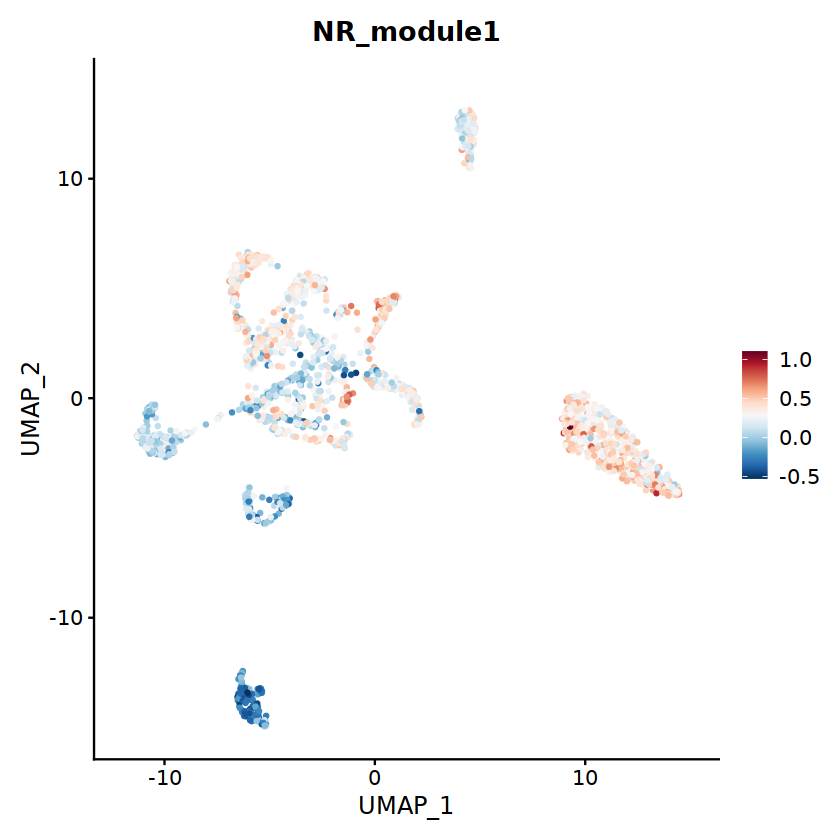

In [52]:
FeaturePlot(regev_data_tumor, features = "NR_module1") +
            scale_colour_gradientn(colours = rev(brewer.pal(n = 11, name = "RdBu")))

pdf("/seq/hacohenlab1/arnav/olink_melanoma/paper1/NR-module_single-cell-Regev-tumor-tsne.pdf")
FeaturePlot(regev_data_tumor, features = "NR_module1") +
            scale_colour_gradientn(colours = rev(brewer.pal(n = 11, name = "RdBu")))
dev.off()

## Plot mean expression in immune cells versus tumor cells for all differential response genes

In [196]:
# Can either run on Hacohen or Regev data

# Hacohen lab data
tumor_counts <- tumor@assays$RNA@data
# immune_counts <- immune@assays$RNA@data
# immune_counts <- myeloid@assays$RNA@data
immune_counts <- macs@assays$RNA@data

# Regev lab data
# tumor_counts <- regev_data_tumor@assays$RNA@data
# immune_counts <- regev_data_normal@assays$RNA@data
# regev_data_macs <- subset(x = regev_data_normal, subset = cell.types == "Macrophage")
# immune_counts <- regev_data_macs@assays$RNA@data

In [197]:
head(tumor_counts)

   [[ suppressing 1806 column names 'P2_A10_P11_M39', 'P2_A10_P8_M39', 'P2_A11_P10_M39' ... ]]



6 x 1806 sparse Matrix of class "dgCMatrix"
                                                                               
TSPAN6   . .         . 0.8216302 . .         .           0.112901154 0.19703275
TNMD     . .         . .         . .         .           .           .         
DPM1     . .         . 1.4883158 . 0.9839268 .           0.707951926 0.68579360
SCYL3    . 0.1732729 . .         . .         0.003111949 0.041091894 0.03277686
C1orf112 . .         . .         . .         .           0.007398736 0.08509427
FGR      . .         . .         . .         .           .           .         
                                                                               
TSPAN6   0.17558300 .          . .         .       0.700902 . .        .       
TNMD     .          .          . .         .       .        . .        .       
DPM1     0.30855783 0.04091751 . .         1.05774 .        . 0.892252 1.163599
SCYL3    0.07045461 .          . 0.7531024 .       .        . .        .    

In [198]:
head(immune_counts)

   [[ suppressing 1391 column names 'C2_P6_M11', 'H4_P5_M11', 'A5_P6_M15' ... ]]



6 x 1391 sparse Matrix of class "dgCMatrix"
                                                                             
DPM1     .    .    7.69 7.81 .    5.66 5.98 . .    .    . 6.19 .    8.57 .   
SCYL3    .    .    .    .    .    .    .    . .    .    . .    .    .    .   
C1orf112 .    .    .    .    .    .    .    . .    6.86 . .    .    .    .   
FGR      .    7.17 9.60 6.08 4.32 7.77 7.48 . 8.79 6.96 . 7.88 9.31 8.94 7.02
CFH      .    .    .    .    .    .    .    . .    .    . .    .    .    .   
FUCA2    4.59 4.42 7.21 .    4.99 7.42 5.89 . .    5.99 . .    .    .    .   
                                                                              
DPM1     .    7.98  .    .    .    .     7.69 7.62 . .    .   . .    .    .   
SCYL3    .    .     .    .    .    .     .    .    . .    .   . .    .    .   
C1orf112 .    .     .    .    .    .     .    .    . .    .   . .    .    .   
FGR      5.84 8.26 10.81 4.43 .    8.42 10.86 9.75 . 8.37 7.2 . 8.47 8.15 2.45
CFH      .    .

In [199]:
tumor_means <- rowMeans(tumor_counts, na.rm=FALSE)

In [200]:
# tumor cell counts were already log normalized
# tumor_logmeans <- log10(tumor_means)
tumor_logmeans <- tumor_means

In [201]:
immune_means <- rowMeans(immune_counts, na.rm=FALSE)

In [202]:
# immune cell counts were already log normalized
# immune_logmeans <- log1p(immune_means)
immune_logmeans <- immune_means

In [203]:
logmeans <- merge(tumor_logmeans, immune_logmeans, by = 0, all.x=TRUE)
logmeans <- logmeans %>% rename(tumor_logtpm = x, immune_logtpm = y, gene = Row.names)

In [204]:
head(logmeans)

gene     tumor_logtpm immune_logtpm
1 5S-rRNA  0.0009741554        NA    
2 7SK      0.0012411664        NA    
3 A1BG     0.2129811572 0.9315241    
4 A1BG-AS1 0.0545084847        NA    
5 A1CF     0.0000000000        NA    
6 A2M      0.6677848521 2.8716463

In [205]:
# subset genes to those that are significant for response / interaction
logmeans_sig <- logmeans %>% filter(gene %in% union(lme.response$Assay, lme.interaction$Assay))

In [209]:
plot <- ggplot(logmeans_sig, aes(x=immune_logtpm, y=tumor_logtpm)) +
    geom_point(size=3, alpha = 0.3) +
    geom_point(data = logmeans_sig %>% filter(gene %in% genes), size = 3, color = "red") +
    geom_point(data = logmeans_sig %>% filter(gene == "IL8"), size = 3, color = "green") +
    theme_classic() +
    geom_text_repel(aes(label = gene), box.padding   = 0.35, point.padding = 0.5, segment.color = 'grey50') +
    xlab("Expression in macrophages (log(TPM+1))") +
    ylab("Expression in tumor cells (log(TPM+1))")
plot

# pdf("/seq/hacohenlab1/arnav/olink_melanoma/paper1/NR-module-Hacohen-single-cell-tumor-vs-macs-expression.pdf")
# print(plot)
# dev.off()

Warning message:
"Removed 78 rows containing missing values (geom_point)."
Warning message:
"Removed 13 rows containing missing values (geom_point)."
Warning message:
"Removed 78 rows containing missing values (geom_text_repel)."
Warning message:
"ggrepel: 78 unlabeled data points (too many overlaps). Consider increasing max.overlaps"
